# Scraper
A matplotlib-based tool for interactive visual element selection in Jupyter Lab environments. The Scraper enables precise definition of visual elements for GUI automation by allowing users to select click points and areas directly from screenshots, generating Scope objects for use in automation workflows.

## Core Components
The Scraper operates in three layers for complete visual element definition:

### Interactive Selection
Provides direct screenshot manipulation:
```python
from pyperiscope import Scraper
import pyautogui

# Initialize with current screenshot
scraper = Scraper(pyautogui.screenshot())

# Or with saved image
scraper = Scraper(Image.open('screenshot.png'))
```

### Position Management
Enables programmatic control of selections:
```python
# Get coordinates after interactive selection
click_point = scraper.get_click()  # (x, y) or None
box_area = scraper.get_box()      # (x, y, width, height) or None

# Set positions programmatically
scraper.set_positions(
    click_pos=(100, 200),      # Click point
    box_dims=(300, 400, 50, 75) # Area box
)

# Reset selections
scraper.clear_all()
```

### Scope Generation
Creates automation-ready Scope objects:
```python
# Generate Scope from selections
step = scraper.get_scope()

# Verify selections
step.find()  # Test detection
step.save_string()  # Generate settings string for automation
```

## Interactive Usage
The tool provides visual feedback and interaction methods:

Mouse Controls:
- Quick click (< 3px movement): Place/update click point
- Click and drag: Define/update box area
- Matplotlib toolbar: Access zoom/pan tools

Visual Indicators:
- Red dot: Selected click point
- Red outline: Selected area box
- Red squares: Box corner markers

## Integration with Automation
Typical workflow for creating automation steps:

```python
from pyperiscope import Scraper, Scope
import pyautogui

# 1. Capture and select
scraper = Scraper(pyautogui.screenshot())
# Use interactive tools to select elements

# 2. Generate Scope
step = scraper.get_scope()

# 3. Test detection
step.find(tries=3, confidence=0.85)

# 4. Generate automation code
scope_string = step.save_string() # will convert the cell into base64 string and object deffinition
```

## Technical Details
The Scraper provides:
- Single point and box collection (updates replace previous selections)
- Integer pixel coordinate system
- Independent point and box states
- Compatibility with matplotlib navigation tools
- Real-time visual feedback
- Direct integration with Scope object generation

## Best Practices
- Keep matplotlib window open during interaction
- Use zoom for precise selection
- Test generated Scope objects immediately
- Save successful configurations for reuse
- Use with Pilot and Binoculars for complete automation workflow

The Scraper serves as the bridge between visual element identification and automation execution, providing the foundation for creating robust GUI automation steps.

# Image Click and Box Scraper from screenshot
[layer1](../src/pyperiscope/scraper/layer1.py)

A simple matplotlib-based tool for collecting a single click point and drawing a single rectangular box on an image. This tool allows interactive placement and updating of both markers independently, while maintaining compatibility with matplotlib's built-in navigation tools, used for quick editing the ```Scope``` object editing in jupyter lab.

## Core Concept

- Place and update a single click point on the image
- Draw and update a single rectangular box by click-and-drag
- Visual feedback with red corner markers for the box
- Point and box persist independently - updating one doesn't affect the other
- Compatible with matplotlib's zoom and pan tools

## Basic Usage

```python
from PIL import Image
from pypersicoe import Scraper
import pyautogui

# Load your image
image = pyautogui.screenshot()

# Create collector instance
scraper = Scraper(image)

# Do something
scraper.update_image(pyautogui.screenshot())
```

## Interaction Guide

- **Click Point**: Quick click (less than 3 pixels movement) places or updates the point
- **Box**: Click and drag to draw or update the box
- **Visual Feedback**:
  - Point shown as red dot
  - Box shown with red outline
  - Red squares mark the corners of the box
- **Navigation**:
  - Use matplotlib's toolbar for zoom/pan operations
  - Point/box drawing is disabled while using navigation tools

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib
from IPython import display
matplotlib.use('nbagg')

class Scraper:
    def __init__(self, pil_image: Image.Image):
        # Initialize state variables
        self.point = None
        self.box = None
        self.start_point = None
        self.corner_markers = []
        
        # Setup display
        self.fig, self.ax = plt.subplots(figsize=(10,10))
        self.fig.tight_layout(pad=0)
        
        # Initialize point marker
        self.dot, = self.ax.plot([], [], 'ro')
        self.box_rect = None
        
        # Set up event handlers
        self._setup_event_handlers()
        
        # Display initial image
        self.event_ids = []
        self._setup_event_handlers()
        self.update_image(pil_image)
        plt.show()
        
    def update_image(self, pil_image: Image.Image):
        img_array = np.array(pil_image)
        
        # Remove old image
        if len(self.ax.images) > 0:
            self.ax.images[0].set_array(img_array)
        else:
            self.ax.imshow(img_array, extent=(0, img_array.shape[1], img_array.shape[0], 0))
        
        # Force update
        self.fig.canvas.draw()
        
    def _draw_corners(self, x, y, w, h):
        # Clear old markers
        for marker in self.corner_markers:
            marker.remove()
        self.corner_markers.clear()
        
        # Draw new corner markers
        corners = [(x,y), (x+w,y), (x,y+h), (x+w,y+h)]
        for cx, cy in corners:
            marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
            self.corner_markers.append(marker)
    
    def _setup_event_handlers(self):
        def on_press(event):
            if event.inaxes and event.button == 1 and self.fig.canvas.toolbar.mode == '':
                self.start_point = (event.xdata, event.ydata)
                # Start drawing new box
                if self.box_rect:
                    self.box_rect.set_width(0)
                    self.box_rect.set_height(0)
                else:
                    self.box_rect = Rectangle(self.start_point, 0, 0, fill=False, color='red', linewidth=2)
                    self.ax.add_patch(self.box_rect)
        
        def on_motion(event):
            if event.inaxes and self.start_point and self.fig.canvas.toolbar.mode == '':
                width = event.xdata - self.start_point[0]
                height = event.ydata - self.start_point[1]
                # Update box size while dragging
                self.box_rect.set_xy(self.start_point)
                self.box_rect.set_width(width)
                self.box_rect.set_height(height)
                self._draw_corners(self.start_point[0], self.start_point[1], width, height)
                self.fig.canvas.draw_idle()
        
        def on_release(event):
            if event.inaxes and event.button == 1 and self.start_point and self.fig.canvas.toolbar.mode == '':
                # Check if it's a click (small movement) or box (drag)
                if abs(event.xdata - self.start_point[0]) < 3 and abs(event.ydata - self.start_point[1]) < 3:
                    # Update point only
                    self.point = self.start_point
                    self.dot.set_data([self.point[0]], [self.point[1]])
                    # Restore box if it exists
                    if self.box:
                        self.box_rect.set_xy((self.box[0], self.box[1]))
                        self.box_rect.set_width(self.box[2])
                        self.box_rect.set_height(self.box[3])
                else:
                    # Update box
                    self.box = (self.start_point[0], self.start_point[1], event.xdata - self.start_point[0], event.ydata - self.start_point[1])
                    self._draw_corners(*self.box)
                
                self.start_point = None
                self.fig.canvas.draw_idle()
        
        # Store event handler IDs
        self.event_ids = [self.fig.canvas.mpl_connect('button_press_event', on_press), self.fig.canvas.mpl_connect('motion_notify_event', on_motion),self.fig.canvas.mpl_connect('button_release_event', on_release)]

# Get and set positions
[layer2](../src/pyperiscope/scraper/layer2.py)

functionality for in-python object manipulation

## Core Concept
- Get coordinates for both the point and box in pixel coordinates for creating a new step
- Set coordinates for both the point and box in pixel coordinates for editing existing step

## Basic Usage
```python
from PIL import Image
from pypersicope import Scraper

# Load your image
image = Image.open('your_image.png')

# Create collector instance
scraper = Scraper(image)

# Option 1: Interactive use
# After interaction, get the coordinates
point = scraper.get_click()  # Returns (x, y) or None if no point set
if point:
    print(f"Clicked at: {point}")
box = scraper.get_box()      # Returns (x, y, width, height) or None if no box set
if box:
    print(f"Box at: {box}")  # [x, y, width, height]

# Option 2: Programmatic setting
scraper.set_positions(
    click_pos=(100, 200),           # Set point at (100, 200)
    box_dims=(300, 400, 50, 75)     # Set box at (300, 400) with width 50 and height 75
)

# Or clean all markers
scraper.clear_all()
```

## Technical Details

- The tool is designed for single point and box collection - new clicks/boxes update rather than add
- All coordinates are returned in integer pixel values
- The point and box states are independent - updating one won't affect the other
- The matplotlib window must remain open during interaction

In [7]:
class Scraper(Scraper):
    def clear_all(self):
        self.point = None
        self.box = None
        self.dot.set_data([], [])
        if self.box_rect:
            self.box_rect.set_width(0)
            self.box_rect.set_height(0)
        for marker in self.corner_markers:
            marker.remove()
        self.corner_markers.clear()
        self.fig.canvas.draw_idle()
        
    def get_click(self):
        return tuple(int(n) for n in self.point) if self.point else None
    
    def get_box(self):
        return [int(n) for n in self.box] if self.box else None

    def set_positions(self, click_pos=None, box_dims=None):
        # Update point if provided
        if click_pos is not None:
            self.point = click_pos
            self.dot.set_data([self.point[0]], [self.point[1]])
        
        # Update box if provided
        if box_dims is not None:
            self.box = box_dims
            if not self.box_rect:
                self.box_rect = Rectangle((box_dims[0], box_dims[1]), box_dims[2], box_dims[3],
                                        fill=False, color='red', linewidth=2)
                self.ax.add_patch(self.box_rect)
            else:
                self.box_rect.set_xy((box_dims[0], box_dims[1]))
                self.box_rect.set_width(box_dims[2])
                self.box_rect.set_height(box_dims[3])
            
            # Update corner markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            corners = [(box_dims[0], box_dims[1]),
                      (box_dims[0] + box_dims[2], box_dims[1]),
                      (box_dims[0], box_dims[1] + box_dims[3]),
                      (box_dims[0] + box_dims[2], box_dims[1] + box_dims[3])]
            
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        self.fig.canvas.draw_idle()
    

# Get Scope
[layer3](../src/pyperiscope/scraper/layer3.py)

Generate ```Scope``` object from the current screenshot or presaved PNG image

## Usage
```python
from pyperiscope import Scope
from pyperiscope import Scraper
import pyautogui

s=Scraper(pyautogui.screenshot()) # Use current screenshot as base to mark are and click
step = s.get_scope()              # Create Scope object based oninput
step.find()                       # Find the bitmap again from desktop

# run this in sepparate cell to convert the step b64 string
step.save_string()
```

## TODO:
- [ ] Only area is required, the click will be center then 

In [8]:
from pyperiscope import Scope

class Scraper(Scraper):
    def get_scope(self):
        #Check that collector has clic position and area
        if not (self.get_click() or self.get_box()):
            print("Collector must have area and point set before scope can be made")
            return
        #Get offset of the area box
        neg_size_comp = [0,0]
        if self.get_box()[2] < 0:
            neg_size_comp[0] = self.get_box()[2]
        if self.get_box()[3] < 0:
            neg_size_comp[1] = self.get_box()[3]
        area_offset = (self.get_box()[0] - self.get_click()[0] + neg_size_comp[0], 
                       self.get_box()[1] - self.get_click()[1] + neg_size_comp[1])
           
        area_size = (abs(self.get_box()[2]),abs(self.get_box()[3]))
        return Scope(mouse_offset=self.get_click(), area_offset=area_offset, area_size=area_size)

# Testing and ideas

In [9]:
import pyautogui
import time

screenshot = pyautogui.screenshot()
collector = Scraper(screenshot.crop((0,0,screenshot.size[0]/2, screenshot.size[1])))

<IPython.core.display.Javascript object>

In [18]:
# Click action
stepdef = collector.get_scope()
pyautogui.click(collector.get_click())
time.sleep(1)
collector.update_image(pyautogui.screenshot().crop((0,0,screenshot.size[0]/2, screenshot.size[1])))

In [ ]:
# Keyboard action
# comment: Automated step generated with pyPeriscope V2 
payload = '''gASVnZEAAAAAAAB9lCiMBGFyZWGUWJwEAABpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBRE1BQUFBdkNBSUFBQURCMTJXZEFBQURPMGxFUVZSNG5PMllPM0xhUUJpQTl5RUpTUWlFWVVLVktsekRMdHh5QWhmWU0rSU1MdHliR1h0OEE0NWdYMEtOaDRZVFVDUk4wc1FKRGtqb3NYcnNwcEFIeTJaNVM4S1p5VmVobGREL2FYZTEyditIWDcvL0JCOFNkR2lCcGZ3MzJ4NWhxNnNSUXFvc0tTVkpFakhHQ0NNRUlWejdMOFpZSE5PWTBpQ01YRC93U0VncHpjd01RWGlrbDZ1YXVsNWtBUWloSUdBQjRKSWtWc29LQThDeTNUKzJReW5iMTZ4U2x1dFZEZU5zaGg0Q29GZFVUWlhIMDluTTlYYzNxMVhVdXE1bDRwUUdZOVNzVnpGQzA1bkx2V0NOMmFkNnRhTEttV3ZOYWRRMFFVRGp5V3p4MUtvQjBqVTFWNjE1RkYxVEY5dVhtaWtscVZITGZoQzVOR3FhSWt2dkd2bG1FTUptdlpxLzBpdk5vK3E3QllodnBtdEtWbS9paG1DTXFtVWwzYkxNakRQd2VWT3J2QW5LTVN0SllzRWRsb0F4S2tuaS9KQmpVRlpLQmZvc0RjMHhrMVBpQlNPdjdyT0RET1ZpYUo0Wk9wd1pXbW1HMEE3N2lXeEloLzY0TzhkOXpZYkRvV0VZaEpERlU0UVF3ekNHdytGdWQ5N0xiRFFhblorZm02YTVLT2Y3dm1FWXBtbGVYRnlNUnFPaXpWcXQxc25KQ1FCZ01CaWs1UWdoM1c1M01CZ0FBSTZQajF1dFZ0Rm1naUQwKy8xMnV6MlhDNElnR2NSRXE5MXU5L3Q5UWRndTIwaUFpNW53bDgvTnJXN0JHTHU2dXJxL3Z3Y0FuSjZlaG1INCtQZ0lBRGc3Tzd1NXVka2toVW56N2NkVDhtT1hwM2tIaFBEMjlwWXg5dkR3WUpwbTB0anBkSzZ2cjdmVlNwTlIwZ0hoM2QxZHA5TkpEcnZkYnEvWDIwY0xaTkpuYzNxOW5xN3JFTUxMeTh2OTc1YkJQTXVXK1R6N3A3NEJqSzFLblhNbG5iVnp6T0lOaWc0NWtRN05NNHNQWnhhdk5DTmhWS0RNRzRMb05UVEh6UFU0RzRkaVNJZm1tSGtrWEYwL3lnbEttVWVDK1NILzNiUWNyMENsRnl6SFM2OEsvUFZzWWprRnY2RXhwUlBMU2Jmd3pTaGpUODlXSVVvdlBJMHQrbllkWGZvTjhQemdlY29wYStYQmVESkx6N0NFVlYrbmllM2ErVTg0eS9HNFpjYzFlNDFmZit3Z2loczVWRU1UZms5c2E4Wi8rUFc3b0tudFJsSGNxRldFVEhQM0tJckgwNW16Zk8zY2FIL21lTVR4U0tVc1Z6VzFKTzY3cFNOaFpNMWMyMWxhMWQ3Q0xNRjJmTnZ4TVVLcUlwVkVVUklGVWNTYmxCcGlTc013RHNLSWhLSHJCUnV1UjF0M1FFeXA3ZmcyV1BQRSsvTVhnTlZOWERuTit6Z0FBQUFBU1VWT1JLNUNZSUk9lIwNY2xlYW5fcHJldmlld5RYHIwAAGlWQk9SdzBLR2dvQUFBQU5TVWhFVWdBQUFvQUFBQUtBQ0FJQUFBQ0RyMTUwQUFCbzNFbEVRVlI0bk8zZGVYd1RkZjQvOFBkbmNwUW1GQXBOcWdMU2dtQnBGUkFveUNFRlJCRjBCVmZBbjZzaWVDQ0t1eXR5Nkhvc25uaUFJSWl3b3VDQ0NMTExJYUJDRmZtQ0lJZFlXQVJ0cWFDMENDaE5DcVZ0VXBwalByOC9KcGxPMHFSTjJ5VFQ0L1Y4N0w1OTk5M0paRm9nbjN6bWM0VGRNK25wUWIyN0VBQUFBRVNSbGhHNzZaWmIxYjRNQUFDQXBrVlErd0lBQUFDYUlvR1kycGNBQUFEUTlLQUhEQUFBb0FJQkhXQUFBSURvRTRpaENRWUFBSWcyM0lJR0FBQlFBUnBnQUFBQUZXaHJmUU5hRUFSRE0zMXNqRjZ2MDJnMGdrWVFXQWgzc3pubmJyZm9Ga1dIMDJXLzVDZ3JkNHFpV050TENFYTZESkVUWTV3VGt5c0EwTEJ3NHNRWkkrSUNFemduSWg3dXA4RExCYWhHVzR1L2JRSmpyVm9hV3pRMzFPTHZLV05NcTlWb1NST2oxOFVaWXpsUmNZbjlRb2xORk1Qdzc0b1JjVTZjY1NZOWxUY0FRTVBFaUVtdlVJeHpUL3ZMaFBDMHduaTVBTlZwYS9wWExzN1lySFdMNWhwTmVPNWRNNktXY1libWhtYUZGMHRMN1pmcWRpN0dSZTc5NXdvQWpZMm5keW9TRTRqWHNRM0d5d1hVQTlvYUhSMGZaMmpkc25uWUwwS2pFUkpidDlBSXdzVlNlMjNQd2Noeit3Z0FHalZHbkVzZDJMcWRBaThYb0xZYWRHVE5yVnRFb3ZXVkpjUTNUNGl2emZrak16SUVBUFVZcitVL2VyeGNRUDBoaEhnbnAyVnpRNXloV1lRdmhsbzJON1JzYnFqWll4Z0diZ0NhSkZiekdTeDR1WUQ2SktRZWNHeU12blo5MDFwSWlHOGUyMHdmNnRGMXVnMEZBQTFjalc0azQrVUM2cG5xRzJER1dHTHJGbEc0RkZsaXF4YWhyR2dpWWhUMkZVd0EwS0J3VHFGMWhQRnlBZlZPOVExd3krYXg0WnJ6SENLTlJtaGhqSzMrdUZyY2dBS0FSb1lSc1JBNnRuaTVnUHFuK2xuUU5SNlVEWWY0T0VQMU02SkZ6R01FQUNJeGhNYTE1aThYbkhOT29zQTBidEY5ck9UZ25wTFBPc1JjYzMzTFcxcm9XeEZIY3c1aFVFMERIS1BYUmJuN0s5Rm9oQmk5cnR6aERIWUFJK0sxK2dkUWJMMXdzZUI4VVVHaHM3emM1WEl4WXJvWWZUTkRyRFpHMStweWM0dkUxanFkcnZiWERRRFJ4M3lHZDR1c2Z6akx5M1F4c2ZHbXk3M2ZyOW5MQmVlY0V4ZVl3RWh6eW5iaVlNbTI0NWQrY0x2Y0Y5M1czOTIvcHNYMHZTNHVRNnZWY3VLY2M0RmhRMStvcFdvYVlHTnNUSFN1SStCVFY5RUE4NXE4QlJWRmtUaDN1OXlpeUMybmZzODdlaXp2eU04Tys2VVlmUXhqekY1ZUZwK1lZR2hoN05nenJhTWhob3dHalViRFF0dFpFd0RxQStVTGd1T1NYWTZWdjFzdGtZc0NFeGl4RXNmRmZVVmJqemtQT0hnWmQ1Q1c5SzVMenVPWGpqcGEyYStMNnhGcnY2eU1PUmhqSW9tTUdMYjBnRnJRVmoxNDBreXZXbmV3NnFjTy9kOFQ1MXdRaEpMQ29qTW44ci8vN1A4dTJjcGNUamNSSncwcmR6bUlTTkFJRjYxRnhlZUxyS2ZQSGRuK1hkZkJmZHBmMDZuMUZZbWNjN1RCQUExQzFTOElJYjVjY001RkVqVk1jOGxWbGxQNjNYZWwyMHJaZVVlcFV5L0VNSElYdTRxTTJyaFJiZThiZmZVNERkUHVjWDc5WThGUDZjYWJXc1dZaVlpVHlQRFpObEJEMWZTQVZibi9ITXBUaDk0d2ltNTMwYm5DVTlrbnp1Ym1sWlhhbk9WT2FVOVp4cGlnMFVnSGNNN0pUYUxMelVVeC84aHhVZVJNbzJtWjBJcHAwQUFETkFCVi8wTU44Wjh4WTB4RG1oT2xSN0xzWDU5Mm5IQmVjbW5jR3AxR2IzZmFuQzVIZXVJTkk2LzZ5MVh4S2JrWGZ2ejg1SDhPVzc0enRteCt2T3p3ZGJHRGVyUVlIS3RWWWE0TU5IVFZOY0NDZWcxdzFVL05RN3Jsd3prWDNhNnpKL0pQSFBxcDlPeDVsOHZGQk1aSXd4aHBkVnBkakk2SUhPVk90OVBGT1JHSkxxZnJmUDd2YmhLYng3ZUlheFhIQkIwNndRQU5RTlV2Q0tHOVhKd3ZMOWhUdFBtRTQ0aVRPNmhjb3lXZGt6bnNsMnh0RFVsM2QzK29WMkovSWpwd2J2ZkNIMTZ4TysyWEdkcVFuUzZ5ODN2cDgyUDJnLzFhak9nUzF3c3ZGMUFqMVRUQWdxRGEzNmRxbmpxMDYzSzczWmZLSEllMzdiR1hsTHFjTG9FRWJUTjkvT1VKM1lmME0xMTVlWXZXOFVSa0x5NHBLamgvNExQL3UvQkhvYXZjWVhkZWN1U2YrZTc4eGFScnI5YnE4TThKSUp6T0YxcVhMMTF5ei8wUFhINUZHNzl2L2ZINzJkVWYvWHZpWTMrTmE5R3l4dWNOUnhmNDhJVnZUeHFPT292ZG9rakVYS1dPNGhiYStORlgzWDlINTN2SUlYejc3YmR0MjdXOTlvcWVUM1I3NGZPVGEzT0xqamJUeGVxWTNsM0t6emMvdSsvUzUrMmJkVGJxYTM3bDZ0bnkrYWJQTjY1ZnZQUWp0Uzhrc2lZL2ZQK2Y3aGg5NjU5R3FYMGhBZFRzd3hnYW5LSS9yR2VPbjdTWDJsMU9GeEhwamJGSlhUdTNUNzBxc2YwVmhwWXR0SG9kRVJsYU5HY2FUZmNoZmZOemZzay9ldnlTM2VaeXVzcHNaYWR6VHBpVHJtaGhhcTMyRDBFem41bG10VmlrZk1EQVFmZU9mMGpkNndHb3RSWEwzajl4UFBmdE9hODlPZU5aWlJ2OHgrOW4zNTd6V2tseDhZY2YvT3VKYWY5UTVkb0VwbkdXdWhnblRxTEw3YnloemMwak85N2Rybm55a1I5K1dQL3ArdThQWktXbnA4OThmbWI2NVFONlh0NDM4K1NubWZrYmJPNFNMZW5jNVNUeW11M0tGVGxoZWJuNGJ0K2VGY3VXS0N1UmJzTW1QM3kvOHN0WDM1elhPc0VVOW1kWnRXTFpudDNmMVAza001K1pObVg2TTNXL3dtb21ZZFhJOTk5L3Yzang0dmZlZXk4bXhuL3VkSGw1K2FPUFBqcDU4dVRldlh1SDd3bXJkK0VQeXk4SHM5MU9GeGU1VnFlTFMyalpzWHRxeCs1ZGxNZG85Zm80dlQ2dVR6ZXRYbi9oYklHenZOemxkTHFjenJ3ZmY5WWJZbXJVQUU5KytQN3hEMDI2dnQrQXVsenpncmx2bUV4bStaL05pWjl6K3c3SWtQL3FUMzc0ZnF2Vm90WXJGRUFkM2YvZ3hQbHZ2VkZvdGN4LzYvVXAwNStSMnVBL2ZqODcvNjNYUzRxTEUwem0rOVI4ZjhtWndFaWdzbkw3L1NtVGIwNjY0OXp2NXhiOGU4SGViL2RxdGRxLy9PVXZOOTk4ODFkZmYvVy93Lys3ZGZpSVczdU82Vzd1TSt2QWRJZFlybUVhWHZOMWtmWC81VUp1cUU3OG5EdHY5cXdMaGRiYU5lZFYvNlJTWTY4OFlOV0taU0UrTnZxa1gwVzR6aWFFYTNQVTNOemNjZVBHN2RpeDQ0RUhIaWd2TDFkKzY5S2xTdzg4OE1DT0hUdnV2Ly8rM056YzhEeGZhTndPWituRmk0d3hSb3h6M25ma1RlYjJiZHh1dHlqNjdFb25pcUxiN1c3VkpySDcwSDZjYzJuRDlsOStPSGF4NEVMb3ozVyswQnFXYXk2MFdwUmZkcm82UmZuR2MveERrM0p6c3NQMVhBQlJsbUF5VDVuK2p3U1R1ZmppeGZsdnZmN0g3MmVsMXJmNDRrWDVXMnBkR3lPQk9IRXVFcWVyV25jcEtTcCtmZmFzZlh2MjllclY2OFVYWHh3M2JseENRc0lmZi95UmUrelluTGx6dnZ0dWY5dm03WFZNN3hKZHhHdmMramFzbDR0T1Y2ZU1mMmpTbnQzZjFPSlUxVDdraTgwYkJnd2NwR3hpN3gzL2tOVHdoLzJGN3Q3eER5MWUrbEh0ZXE3bkM2MlRINzQvakswdjFlampDS3QyMVZWWERSdzRrSWoyN3QycmJJUEx5OHNmZlBEQnZYdjNFdEVOTjl4dzFWVlhoZXNaUTNISmZzbGQ1cERlMkdyMXV2akUxckhHV0kxR0kvak84QklFUWFQUkdPS01waXV2ME9wMVRHQkVuRnp1OGt1WG9ubTFBRTJCMU5DMmFObXkrT0xGZWJOZm16Zjd0ZnJRK2hLUnczM0pLVG8xcEdHTXViakQ2WFQ5OGNlNTY2Ky9mdnIwNlowN2QzYTczWXl4Qng5OGNNS0VCOHJLeXN2TG5VU2l5RVdOSVBEYWZ6cGlnNUhnYVJFTEkzSHlWaEc0Mnh4MjBzLys2cHZ6eGo4MEtWem4xSVpyMkVLcjFTNVpzdVN2Zi8zcmxpMWJwRFo0K2ZMbG5QTUhIbmhBYW4xdnZmWFdkOTk5VjRqdXRPcnlTNWZJUmFKSVRCQjBlcjJ4VlF1TlJoUHNZSDFzVEh4TWdrNnZjem9jb2tneEdvM2I1UXJ4aWFTaEJTSmFzV3pKaW1WTFVsTFQ1TnMreXJFTjVYd0h2MXNaaTVkK0pJKzdXQzNmU0dlclBEK2lzTkJxTXBzak1Ub0NFRFVKSnZPVTZjL01tLzFhYVVreDV6eXVSVXZWVzE4aVNvN3JsT2Y0MzI4WFR6UE9SVkdNajI5NTFWVlhTZnNCT0oxT3JWWXIzVHlMaTR0alRGcW1JVERHUkNJdFl6WGFhcnFodjF6NGpSQlBmZXE1VGxlblNQbk1aNmFsZEVscmxXRDZmT042azltYzBpVXQyRThxU3pDWlA5KzR2dklBYzhEZjBvSzVieENSOGlRQks3azUyZksxS2M5WmVkNlovQ3hFWkRLYlgzNTlickNmdXRQVktkNEhodTArYmpnbllRbUNzR2pSb24vODR4Ly8rYzkvOXU3ZE8yblNKS2ZUS2JXK2Q5OTk5K3V2dng3OU9mcU1NYTc0eEdOVzNhWnh2Z2Y3UExacTk0NS9hTVNmUmozLzlGVGxjTVg1UXV2elQwK1ZKeStzV3JGczhzUDNTMytFMHQ5ZytTK3VOT1p4ZmI4QjEvY2JJUDBORGpqV2N1TG4zTTgzcnZmN0t3WFFFRWw3dnRhcjdXNzZKR1FNTm1Vc0V4WitjM3Fydysza2pQLzlpYis3SEM2MzJ5MzFIS1FYQktmVDZkMzZpaE1SNDV4Q2ZxR1FOTVNYaTU5L1BrWkUwZ1Y4c1htRDNJWnQrWHpUdk5temxOT2FjbzlscDNSSmt3K28vSlA2ZVdMYVB5WS9mSC9sdWNvQmYwdlZtdm5NdEFTVFdYNTJ2N2xkbFE4bXhSdVhCWFBmbVB6dy9SR2EveFZRbVB1ampMRTMzbmpqcnJ2dUlxSWRPM1o4KysyM1JIVGZmZmVwMHZvU2tVYXJkWE8zSUJDSm90UGhLRHBuY1pTVkJ6dlk1WERhaW9xZERpZUpYQkNJTkJUVHJGbGRubjNsOHFVcHFXbnlYeW5wSDhtV3p6ZVI5NTJwL0xheDZxa05XejdmSlAwRi9lamY3eTllK3BIOEtJQUdxdEJxbWYvV0c2VWx4WEV0V2phUGExRmFVaXpOekZMM3FvN2JzeDNNT2JucjA5TjZ2SHBaOHlzS3psbmVudmQyWGw2ZU5FVEZPZGZwZElJZ2FBU055KzF5dVYyZVRpL3pmQjVUSFc5QjErZVhpKy8yN2ZsODQzcjUxcXV5bXloZDhQR2ZmVHFGTloycnRYanBSd01HRHZwODQvckpEOTh2L2NpMXMrWHpUVmFMejZTekt0NS9TQWNyZjVZbnB2M0RaRFp2cmNNRjFGVDRseUV4eG1iUG5xM1g2ei8rK0dNaWV2REJCMmZPbkJuMlp3bFJUTE5tWEtzaGg4aEYwZVZ3RnY3MnU2RFJhUFJheHBqeVpyZ29pcHp6TWx2WmhYT0ZMb2VUaTV3SmdxYVp2bGxzblJyZzNKeHN2OUdDbE5TMEM0VldJa3BJTUZrdGxsVXJsb1h5Ti9YV1A0MlMvcFpMc3dDcXZrOENVTTlKclcraDFkS2laY3NwMDU4aG92bHZ2UzRWMWIwUmZmRGMzbzNGUzI1cS9lY2IyOXhLQXAwM25uYzRIRysrK2ViMTExOC9ac3lZTGwyNjVPZm5sNVNVdU53dWc4SFFxblZyTjdta3ZpOW52TzZmZGxnUFh5NmVmM3FxblB2MUMvMXVpUmNxWmt1bGRFbXJ4WFBkTy82aGU4Yy90R0R1RzU5dlhIODhONmQyTTdlUDUrWU1HRGhJV2FuaS9VZmxnNGtvcFV0YTdySHNXangxN1dnajlLbGFyNzc2YXN1V0xSbGowNmRQajhUNVE5UXlNYUZqOTlTZnZ6L0NpVFBHRG0vZm56NWlVSHhpZ3Q5aFVtTnN6VCtidGZVYnhwajBJU2ZOVzhkcm0rbHIvZFRTL0QxcDlNTG5HNmxwUkhSOXZ3RUpDYVo1czJjRkc3d0pxSFdDYWZIU2o2UTNpZlZ6WFRsQTFmeGFYMmtaMHBUcHo5U0hOamhXWnlpOFpQMTM5anU3ejN4NVI4ZHgzYzNwYjh4NmM4Tm42ek8vMlByU1N5OE5HalJvMzc1OXZYdjNIajFtOUt5WFozWHMxTEhVVWF6VmFzbEJBaE5xZUJQYVgvMTh1UWg0TTFhNlZhNzhidFczZVd2a2lXbi9rSnIyNy9idHFjWFNvMEtyeFJUeVg1NkFCMGQ1T2xnRU4rS1lNV05HNUU0ZW9wYm0rT1N1blg4OW5PMFUzVzYzcTdqdzRpOC81TGdjanNzN0o4VWFZN1Y2UFJFNUxwWGJMNVpZOHMvbTUveFNmUDZpMisxaUF0UG90QjE3cExhNnJQWi9HTkpmelNwR0wrUWgvWm5QVEt2UndJUEpyUEpjRllCYSsrakREd3F0bHJnV0xlVFdsNGd1djZMTmxPblB2RDNudFVLcjVhTVBQM2p5cVdkVnVUWTNkK21aVHFlUE9YSHgyTnovUGQvdjhpRzNkaGp6bDd2K011RDZBUnMyYmRpMmJWdHloK1FoTjk1NHhlVlhGRnc2KzRmdGRPdFlzOGc1Y2VKdVRucnU1bUwxenhGRUEzcTUyUHI1cG9qZWhPdDBkWXJKYkQ3eDg3RklyLzBOK0Q3dlFuUlhlQXIxWmdKRVJMUXd0YjR5OWFwWVk2eFdweVZpRG52WnljUEhmdGo1M1lYZkxmYmlVcGZENlhJNFM0c3VGcHc2KzhPTy9TY1BIM1BZeW9oSXE5TWFtaHM2WHBmV3NpWU5jT1YvRDlKZm8yb2ZLTjJGa3dkUnFuMzdiN1ZZRWpBTEdocW04UTg5MHFseml0ODJXRVIwK1JWdG5wenhiSEtIanVNZmVrU3RhOU96WnFSajVWUVdwMnRoMEJwMy83N3R0UU16VnVlOGI3b3lZY3JmcDd6KzJ1dXpYbnJ0bXJTMGJmbWJudHN6K2RpRm96b1dJMzNRVWt5Y1JzOWpZNFFhZkhocmczNjVVRDdwaVorcm1SSmN1d2xOVWs4MHdHL0paUGFiSzZEOHN2SU41Ty8yN1FuMkZKMVRVdVg1ejdMY1k5bDlCMlRVNG9KcnB3YXpncU5NRkt0NjZoQXZqSE91MFFwOVJnNDFKN1V6NkdJNGNhZWp2Q0QvOXk4V3IxNHo2NzJQWnk3NGVPYUM5Vzh1M2I1aVk4R3BQNXlPY3M2NFFSZmJ1czFsM1cvcUgydU0wV2lEcmxrS3lPK2YwUDBQUExKbjl6ZktPUVVMNXI0aDNXdGF0V0tadk1aYytyZlUyVHRXWVRLWmxYK0g1SWRJWmo0enpXUTIxNTk5WVFCcXBIV0NhZXJUejFYZUNKcUlMcitpelZQUHZWakxDYWhWdmg2RStITFJwL1ZOR2NLZHJYU0paQkJGSnNicldydko5ZG1wL3p5NzY3SC9PL1ZGaDVTazA2NWZYdDcvNUVmSEZwYzRMK3FGWm94STIxeUlqWTFONHdOSG1SNkowY1hXNkpJYjZNdEZxd1JUYms2MjNPNkdzakZGMWU4dC9PNWdyMXF4ekdxeDlQVmVzOTlqTzEzZHhXcXh5TTJxZExEODNSRi9HbVcxV0tTRlNVUjB2dERxZjB0ZlFib3RMMDJFbGl5WSs0YlZZb25tNkY0MVcxRzZSVkViZk9Gc1JMbkZxdTduaFA3NVlvS2dUVXh1YTd0WStoc1R6dVg5NW5RNE9YY1JrZWgydTUyZVJQNkFRbDJNTHJIVGxXMVNrdHQwVGhZMDJwck8zTDcvZ1Vla2NScHB5VnFucTFPbVB2WGN2Tm16UHQrNFhqcmdUM2VNbGw1ZldpV1lnazF3dUhmOFE5SWtSaUphdlBTanppbXB5aVByN2E3aUFHcGlWWDNtYjRqL2pIVmFmYS9XUXpvWnV2L1B0dk1IOTI2bjVwSlFxbW1sVDdqZ3NDN0xmbnZINlMxLzJNK1V1VzB0OVBIRmptSkJJeENqSzRXVXRGWjlyMnB4YlMwdXVZRytYTno2cDFFWENxMXl1eXNOTTFmOUVMK2Z0UElCeWpPWXpHYmxJTGZmWTYvdk42Q3cwQ29QbG85L2FKSlYwUU51bldCNjljMTV6ejg5VlRxaGRLb3FMbS94MG8ra3BVZlNseW1wYVZIK2FBcDI3K1RuWG43bTc4RyszVGF4Vll4ZUY4MExrbDBxZDU2MUJOMEprb2Y0QVdQZWhZYm4vN0NjK3VuRTBSMzdMOW5LWEM0WEY0a3g3bm5YektUL002MU8wOHdZbTM3N2tMYWRrbG9rdEtwWEt4UUJvQXJLRjRTQzA3OUtTV0s3anBXL1d6V1J1d1dtSWFJL2JLZStLODdNdmZRL3pqaHpNTVlFbTdNa1J0dE16L1FPN3VDeDdudmJUTDZtMllBTFpjVTZyVjdrYmtaQ2czdTVhQ0tmaGxTZlZUTUpxOXpwVXFzQmRsUzVDeFVMOVIrVVp6K05lSFByNWpmMDdOUXo3Y1Qvc244NTlKTzkxRlo4N3J4Qkg4dUpsenZLOWNhWTl0MnU3bkJObHl0VHJ4STBUS1BWaUtJWTVVMjdBS0RXcW41QkNQM2xRbUFha1l1Y2k1Y2IyNDh5UG5LOCtJYzlGN1pZWS9ORmw2czVqM09UbXh2Y1JqR3VhN01CWnZIcVV1Y2xxZldWMm15QW1xcW1BYmFYbGJjdzFteGdJMXpzd1hmTUlDTEdhckRzblRIR05CcTlSaU1JbW5aWGR6UzJhTzV5T3N0dGw1emxEazVjcTlYcW1zWEVKeWEwTUxXS01kUmdHZ1VBMUJOVnZ5RFU2T1ZDWUFJeFFlUWlZNnh6aSs3dERTay9sWHozUC91Tzg5cHp2SnhmcGUzVnUvbU43WXhYS1k1SDZ3dTFwSzM2ZldGWnVWTVV1U0JFKzlhS0tQS3lja2NWQjNER1NLeng1MjlxZFZwVHU4dE03UzZyMDhVQlFIM0NPVEdCVmJFZlpDMWVMZ1FtRUpISXhSaHRzNTZ0QmwxbDZIcnc0dmJXeHN1N3Q3cUJNWVplTDRSRk5UMWd6bm14clN3K3poQ2RxNUVWMjhxcW1iZkllZFhUTGdDZ2lmRGJ0VjJqMWJsZFRvMVdNWFpXMjVjTHdidDdmTXVZMWpjbWpsWFVHMFBySysrWkJXcXBmaWVzb21KYm5MR1pKb29Eb201UkxDcTJWWDhjWTlKbjkwYitpZ0NnbnVMRUJXTEt0K3NKbDE4WjREaThYRUQ5VTMyektuSmVjTDQ0Q3BjaUt5Z3NGa05adDhkSndEOG5nS2FOTVJiYW5nQjR1WUI2SjZSK2Jka2x4L21McFpHK0ZFbGhVV25Wbzc5SzB1cmRTRjRPQU5SanJBWWZRb1NYQzZodlF0MktzcWpFWG1JcmkvREZVTEd0N0dLcHZXYVA0WnpYOVhQQUFLQUJxc1ZIQU9MbEF1cVRHb3pzV2k2VUZFYXlIMnd0S3JGZUtLbkZBeG5lMWdJME1ZeHFPWjZMbHd1b1AycjJhVWdYUyt3dWx6c2hQazZyQ2VlY0xKZkxYWGl4MUZibHd0K3FjVy9FUHkyQVJvNXp4VDUydFRxQk4rTGxBdFJWNDQ4anRKV1YyOHJLNDR6TldqUTN4T2pxK21tRzVVNVhjYW05eEhhcGp1ZVJNQ0ppaklzY2IzRUJHaC9PaWJHd1RXVEd5d1dvcnBZdGFJbnRVb250a2tZUURMSDZHSjFPcjlQcWRKcFFsaXE1UmRIcGREdWNybktuMDE3bXFQb1RGMnFEUy8rY0dESGkzby9ueE5vRGdJYUlFNWRtV1RFbWtOVHZEZThJTGw0dVFGWFY3SVJWTmJjb2x0Z3VsVkI0K3E5aHhZbmpIeEpBdzhhOG41UlN4UzVYNFlDWEMxQUhQbThBQUFCQUJXaUFBUUFBVklBR0dBQUFRQVZvZ0FFQUFGU0FCaGdBQUVBRmFJQUJBQUJVZ0FZWUFBQkFCZmlFTGdBQUFCVUUzUWxMRUZqejJHYUdabnFkVHF2UkNLRithaElBQUFDRUlFQURyTkVJOGMwTkxackhNalM2QUFBQWtlRy9GYVVoTmlheGRRdjBkd0VBQUNMS3B3Y2NIMmRvM2JLNVdwY0NBQURRZEFoeVZ6Zk8wQXl0THdBQVFIUjRHbUM5VG10dTNVTGxhd0VBQUdneVBLTzlyVm9ZMWI0U0FBQ0FKa1FnSW8xR01NYkdxSDBsQUFBQVRZaEF4SnZITmxQN01nQUFBSm9XcmNBWXVyOFFkbTZSTzF4Y0ZMbkl1U2lTeURubmFsOFRBRUI5b21XTTlQcWcrMkVCMUlqTHpSMHUwZUVVUlRTM0FBQlYwcEk4RVF1Z0Rod3UwVjd1RmtXMXJ3TUFvSUhRRWo2TkFlckc2ZWIyUzI0Mytyd0FBRFdoUmZzTGRXRzc1QzUzb3RzTEFGQmpHUDJGV2hJNWxkaGQ2UGdDQU5RT0dtQ29EYWVMbDVhNTBQWUNBTlFhR21Db3NiSnlkNWtEdDUwQkFPb0VEVERVak1NbFZ0djZhZ1NtMHdvNkRlbTBRckJqbkM3UjZTYW5TNHpZVFd6R09jY0Vmd0NvdDdUWUh3RkM1M0x6MGpKM0ZRY0lqTVhHQ0RHNm9PMnVUS2NWZEZxaUdLSGNLWlk1eERBdUhHYU11RWpFMFBvQ1FMMkdIakNFU3VSVVV1WUs5bDNHcUpsT2FLYlgxTFRaaTlFSmVxMXd5ZUcrNUJUci9tNlFFWW1jMFBRQ1FQMkhCaGhDWlN0ekJXc2dHU05qTTQwKytBM25xakZHc1RFYWpZYlpMcm5yMkFaekxHd0hnQWFpbHErWTBOUzQzTnpwRHR3MkNnS0xpOVhXdXZXVjZiVkNYS3kyMXZ1eW9kY0xBQTBMR21BSWliMDg4TkF2STJyZVRLUFZoS2YxMDJwWTg5aGFuZ3U3WUFKQXd5SmdEaFpVeStFU1hVRzZ2OGJ3dGI0U3JZWVptMmxxOFVEMGdBR2dZVUVQR0twbnZ4UzQreHVqRS9RaFRIaXVLYjB1cEhuVUFBQU5XalFtWVowN2Q0NXpmdm5sbDBmaHVXckhack14eGd3R2c5b1hFb0RkYnYvcHA1OU9uejVOUkpkZmZubHFhbXA4Zkx6MHJYUG56bjMxMVZkRU5HN2N1TWhkZ05QTkF5NFJZb3dNTVlHN3FpNlhLemMzVjYvWGQrellVYU9wVFhjMk5rYmpjSVZoVWpRQVFMMmxKWXJzaTV6VmFwMHhZNGJMNVpvelowN2J0bTBqK2x5MVUxcGF1blBuVGtFUWhnd1pFaHNicS9ibFZQamhoeC9XcmwxNzZOQWgwWGQ0czJQSGpnODg4RUR2M3IzUG5UdTNhdFVxaW5BRDdBanlXUXV4UVZZY0hUOSsvTDc3N2p0Mzdod1J0V3ZYN3VPUFAwNU9UcTdwa3dxTVl2V2FZQVBQTmJmckgxMGYraXI1dWM4L205QW1UR2NNN016eU80ZlBvcWQyYkJqWExnSm5QNzN1M2lHdm5ibnozUy9mN0I5VCs1TnNmdUt4TlRUK3JRVmpJdnVyYUxUT1pTMmE5ZDZlazNhbkx1UFpEWS8ycU92cExBZm16MXUwSzkvdTFBMStjY1hqdmNKeGhkQmdSTFlIYkxWYXAwNmRXbEJRRUJjWDUzYUg2OFUwek54dXQ4dmxjcmxjTzNic3FDZHRNT2Y4L2ZmZi8vVFRUNlV2MjdkdjM3Smx5N0t5c3J5OFBKZkw5ZXV2di83em4vOGNQbno0b0VHRG9uQXhEbGVBQmxnanNHYjZBSGVKUzB0TDc3bm5Ib3ZGY3UyMTE1NCtmZnIwNmROMzMzMzM5dTNialVaalRaODNSaStVT3lPM1QxYmpjL1M5OGM5bTlYbHQ2ZU5kMWI0U0lxS2lMNlpQWGs3ajNuOXJSQ3R2NmNMUnJSOThzUDd3U2J1VGlIU20vbE5lZmpJalhqcjR3UEwzMW00L2NhYkk3aVRTR2ErNFpzeERrOGVrdGZJL3ArWEFvb1hMdDUrd09JbDBwdXZ1ZWJUeU1RWDdsODMvWU5meEFpZVJ6dHh6OU9OVFJsNVQ2U3gxVXBvMSs0bDUzMVBTelEvZjN2YWtWZm56L3JScDJmSlBqdVRabkVTa1MrejMrRnQvRzFEOVU5c092UHJNbk84b2VmaTRPOXJsRjBpMS9Rdkh6dHJuZDF6LzUxWS8yVGZnR1lxK21ENTVlZTRWOS94cjdwL2JCWDI0Vjc4Wm4vMnRUN1VYVmZlVDEvRkhxSWFqWU5mSytTdThmOG9wR2ZmT0dEZmdNcjM4N1F2N1AxbThldGZQcHkvYW5VUTZRNXV1SXgrcC9WK0QwSy90N0tlUFRsOTlKdkQzMmdSOXZ4dkJCbGh1ZlpzMWF6Wjc5dXoyN2R0SDdybnFvbVhMbG9NR0RkcTVjNmZkYnE4bmJmQUhIM3dndGI1RGhnd1pOV3BVbHk1ZHBMb29pai84OE1PNmRlc09IanlZbVpsNTVNaVJTRitKeXgxNHE3UmdZN1RMbHkrM1dDeGp4b3g1NjYyM3lzdkxuM3p5eVMxYnRxeGV2WHJpeEluNzl1M2J2MzkvNVllMGI5OSs5T2pSbGV1TVNLdGhhSUFWMm8xWmRYeE1rTzg1OXF6YlpVKzgvZGJvdEw2TzdFOW5yZHpZYXZTS0tlbUJEL2gxNnhlNWROMk1vZDdYUGR0UGk1NTVNZE9xYTl2dHRvY3prbHRkek51MUwrK0NuU2llaUlqeXY5OXROL2NkZVd0WGs5NWhQWnk1ZGVlS1Y2ZjhPblh4VSttS3QyMW5QLzM3OU5VblczWWVldmZZbnJyam16ZHZxM1RNbVhYUFRGbVJINStTY2M5ZnV1bHpNemRtcm5ueHNmd1pTLy9XcDNuWWZ1NEx1emQvYnpNTWZ1MzFSNVMvNTlMczk1OTRkVnVCcmszUDRST0dKc1ZmeU4rek83L0lSbFR0aS82RmZSdS9zeHVHUGovbjhUUzVWbkR1TEpFaCtmcjBaTVZsZDA0TWZBTEgvcFgvemZVdEphWU9IcXFyZE56Wnc3dFBGUFhzZGsxMVZ4U1drOWYxUjZqU21YVXZURm1ScjJ2YjY1NG4rc1VYN2R1NGV2djhoMDhVL090MXVZSE0yNy9QbHBoK3g4alVSTDJ6NE5EMkxkdHIvOWVnSnRkbVNPNmJNYmpJdjFwMGJOL2hNeTJ2Nnhuc2JsT2tHbUM1OVkySmlYbjk5ZGM3ZE9nUW9TY0tpMWF0V2cwYU5PaWJiNzZwRDIzdzNyMTdOMnpZUUVRUFBmVFEyTEZqbGQ4U0JLRkhqeDQ5ZXZSWXZuejVtalZyenA0OUcrbUxDZGo5SlNLZE52Q2M0NXljSENJYU1tUUlFY1hFeEF3Yk5tekxsaTAvL3ZnakVlM2Z2My9CZ2dXVkg5Sy9mLytBRFRBUjZYVUNQbXc0TkJlMmYzR0lPajg4SWtyL3pncE83RHlVYng4WTlQcy9iZDV1TVdZOG51SHBsOWkrWHZoaXBqVjU5R3V6SmlSTHBRRVpJeFNIZDM5OFdYZjVpd0UzRGUzOTZoTnpkbiswY1V6NnZSMDl4UXViM2x0OTB0RC91YmVlN0dza29pRVpHZGZOZm1MTzd2ZVdqL0QyK0M5c1hiUWkzekJ3Nm55cFNiNnAvK0JlQ3lmUDJyZG82ZEErVTlJb1RPdzJHMUhMTmo0dHEyM0huRmUzRlNUZHNlQ2xlenRLUDF6L0FhTkNPNTNOYmlPS2J4ZXZyRG1kRHFJMk56Lys2TERxTzIxNXF6N1laL2VyZGJ6cDhTazMrZFhPckp1MmMvY1Y5MHdjVkpQN1VMVS9lVjEvaENwYytIclJpbnhLZVhEUld6ZTFJaUxxUDZUdkowODg5dG5xRDc2NTdhVkIwbSsveDVSM0tzWUZNZ1lONnp0MzhxeDl5OWZkM21kQ2N1alBVL05yaSs4eG9kSjRoQ1ByN2Z0M0dRYmVMLzgxcmtRYmlYa3VjdXVyMCtsZWZmWFYxTlRVOEQ5SHVMVnUzWHJnd0lHN2R1MVN0dzB1THk5LzU1MTNpT2lPTys3d2EzMko2Tnk1YzlMWWFzK2VQYk95c2s2Y09CSHA2M0VIV1gya0VRSTN3TzNhdFNPaXI3NzZhdGl3WVp6emJkdTJFWkYwODZOdjM4QTNvS3E0TmFMVE1NWUlVN0dxZDNMVDF1UFViY3FJZUxVdmhJaUlISHMzYnJlYlJ3LzNkb215VnkwOVFpa1BQdXR0ZmF0ajdITlRkL3B1WDBFQmtlZVZLMi9MNWhPVU1tNUNYMlBGTVJOSGQ5NjljdWZXck1lN3BwUG5OOUJwd3NTS0RyR3g3N2k3VXZZdDM3Nzl3SlMwbXR4M3JhR2phNVlmb3M2VG4vYTJ2blZXU2tUbStCQnVtWjdadEdSTFFiZGJoMXUyWkZaNW5DUHJ2K3QrTnd5Y2VsdE41aVhVNmVSaC94Rmt2K1ljSjJyVFZ6SDAwRzdRNExhZnJUNTMwVUlVY0lxUnNlK2c2K2pnM2dJclVYSm96MUhiYTZ0OGhzMmY3TFZkY2M4OTZjSC9ab1MvQnl5M3ZscXQ5dVdYWCs3YXRWNk1TSVhDWkRMZGNNTU51M2Z2VnJFTjNycDFhMUZSVVlzV0xSNTQ0SUhLMy8zcXE2K2tXVmRSVTlPMmIrellzY3VXTGR1MGFkUHUzYnRkTGxkeGNYRk1UTXhkZDkxRlJQMzY5ZXZYcjE5TkwwQWpzR0JMa0FNcFB2TGZtYTh0M3Zaem9ZT0k5QW1wazk3Yi9FQ1hRQWVXbjk0eC8rbUZtdzdrbFJBUk5VKzU4NlgzM2h4aThueno3TXBiL2pTYnBtVitlYS9pbjNTZ1l2R1JsVSsvK0srdjgwcUl5TlRydnBkZnZ5dlFVNTNadHZENVdldXl6amlJS0M3MTlsY1hQM3RqdTJDVHFFcCsrR1RXSysvc3pMVTZpRWpmZHZDVStTK051eTdPODgzVHEyNGZNamZ2dG5lUHp1L3YrNmpzTFpsV3c5QkhCL2o4UXkvNmFkT3k1ZXVPNUJVNWlVZ1huelQycGRmL3JId25maTdyL1RrZjdjeTFPa2xuNk5EdjhlY2U3WE5aeFRjZDUvWXVuN04rejYrL1N3TnB5Um1QenBpU25ramtNOWExZTk3WTNVU1ZodmN1Yk0wOFRKMG1qRXIyZkwxLyt6YWJZZkQ0bTJvL0duc3U1M0FCdFJuWTNlY01yYnBmMDNibDhWK1BuNkgwdG1USlBtU2x0djJ1OHpraS9ycHJyNkRjdk9PbnFZKzNlVkNPUStzU3U0MmQ4dWlmdThZckh4UDBBTVc0NXVySDdsbE5SQU9ucm4wcS9jRFc3WFpqeHIwMWZ1dVQ5ZmJ0OC9aSzZZcnBZMWVRUElaNnB1RDNrSnFLMDF2bkw4M3ZQSG54TU5zclc2bzhNSVJtSU13bkQvdVBVS0ZqYW1mYVp6bG5VNVNLemhZUnRhdnBFaFpId2E2VjgxZnZ5enZqbVhiUWUvSS92VE1TYW50dC9zOFE1SDNQaGV4UDV5L2JlUFIzdTVOMGlXRnVnT1hXVnhDRW1UTm45dWhSNXptQzBaV1ltRGhnd0lBOWUvYW8xUWJ2M3IyYmlHNjg4Y2FZbU5yUGN3MmptcTRFNnRTcDA1SWxTNlpObTNiKy9Ia2lNcGxNYytmT3ZmTEtLMnQ5QVRYWVhxUDR1MWxqNzF0L2xoTFN4ejg3OC9xRThqTUhOMjA0YXcxODdON25oMHpMTkhVZDlkenJON2FsTXh2ZW1iMWgya2g2ZDBlTlpoZi9zdXJlNFhPUFVFSzM4YzgrZEgzY21hOVhMNXQ4NS9lcE1VUnh5cU5PTGg4L2N0YlBDWDN1K2VkenZlTE83UHg0eVdkUERNbDlLblBOdUtzQ25QTE04dkgzemNwTEhqamhuMy9wYXJJZVhEWm45ZXl4RTJuSG1xcm5WRHQyYmQ1cE05MHhVbkdqMVRzcWFVN0ptREF4TmQ1aC9XbjNOMmN2S0I1ekx1dnRKOWJuWFR0NjRveVdSYnMyci8xdTE1d25uTTkrOUxjZW50ZlJyRVVQdjdzM3Z0UGdleVpkbDBnRnU5YXYzajV2aHVQcEQ1N3FyaWRUbjRsL1RUeTliL25TZzBVcHc2ZU03RVJFNWhUbDVlUnQyWHlDZXY3MVptOWIrTlBCSDRoU2U5ZmtqZmpKbzhlSnV2WHBLWDk5SW8rb2Z4ZS9nYlEyblRzUzdiYWVJV3BMK1QrZkpCclkyYThQMUxaTE10RytndE5FN1lpSWJQc1hUcG0xejltMjE5Z24raVhhOG5kdXpWejk3UFM4NXhZODZlMVlWM1ZBeXZBcE0zb1Y3VnE1L0R2cS9mQzRBYTJJRWpzUlpSOCtSSFJ0ZW8zR1ZvbUlxTk50TS83YTU4Sys1VXNQMHZYakptUzBKREozcnJqdXBPcldpNXo5ZFBiS3ZBN2o1bytJcDNWVkg1bTljZDN2MVBPdk5lbitodVBrNGZ3UkZGcmQ5UGo0N1ZOV3pKdWQ4czhwTjdYUk84N3VtRFZ2cHkzcG5pbkIzOTc5bW4yYzZMcSszWlJQL2RVek16LzQwYTZUL3FEMWZqTVNhbnR0dmk1czNielhacnBqak8vN250TmJaL3g5Wlo2elplZmg0MjdyYWlnNEZNNWxTRmFyZGRxMGFRVUZCVVNVa3BLU201dWJtMXY5Q0haRWw5RDR5YzdPRHVXd1ZxMWFuVDkvWHBVMldGcnZlKzIxMXdiODdyaHg0Nkw1NnlLcXplM2ZvVU9IWm1WbDFYRWRzRXhnTExTL29zVmZQblhmK3JOeHcvNjE4NDBiV2tpbElTTW1CRDI4MnlQTC96bWptK2ZBbS91YkhoejAxSVovYjUzZS93NXppQmRtM1RoejdoRzZ1cUlwdmZtV2NZK3NHak44cms4RGZIald2YlB5aGkvK1pzN05jWjVMdW5Qd2pIN1Racy9jUEdMVlNGUGxzOFlOZm1YSHBEczgvZU1oTjNiWDN6SnErZndsUjhhOTBxM3lzVjVGMnpZZm9aUnh0MWIwYnFWUlNVTi9SZE15NEthUnlzZWN6ZHljL056aUJkSjNNd1pkOThIZm45cThiOHV1U1QxdWtsNHVkRmVQZkg3Q1JPK052b3owK0JjbUx0NjlmdWZFN3NOYTZkdjI2dC8yTXV0L2x4NHNTa3dia0ZGcEV0YlJ6SzhLRElPbjlQZSs3aFNkT1dtbnRtM01GN0kvbmYvZTJrTldKNUhPbURSZzh0U0pHZWJLZlRKSGFkN2hkU3NYYmJhblBYRy8zS0cvY01GQ1JGUnA5ZzhSRVZtS0xoQlJVVlZIWENnaWlxY0xYOCthdFM5KzlHdHpQSGZDK3c4WU5XalZvOU0zemw4emJNMUQxeEJWYzBDcnpnTXlPcDhwV0UvZlVlZGUvUWRJVGM2RnJEd2J0V2xudW5CMDgrTDU2dzhYT0lsMGhnNzlIbm51UWVXODNFRGlyODdvZi9WcDYzK1hIcVF1M1Fka3lPOHRpb29LaU02c21YTDdHaUxTR2E5SUhqaHk0ajJET3ZnMkwyZldMVng5TXVtZWY0MW9TeFJrNHEzM1Y3ZHB6VTZiNlk3eC9VUHYvdGI1NUdIK0VmeTBIZlBTckhQVG4xc3cvVjdQaEJMVHpYTmVDanhGMldFN2VXano4dm1adG1zblRjaW91TWFUSDd6eHdZLzI1UEZ2emZIT1RQYWRrVkQ3YTFQSVh2M0pDZXI1MTdFK283OUZYODFmbWVkTXVrZWVNcFlSemg3dzdObXpwUkZLSXNySnlaSG00MVNySGpiQU1ydmRmdURBZ2VpczlwR1VscFlTVVMwVzdVUkk3Y1pmdFZydE5kZlV2Rk1RaUJCa3NObmZtUTFMOXBCKzdML2sxcmRxL2NmTlVINFoxeTBqbVhZWGxwU0hmRjIvclA3WEFXcnp5T3MrSGRtcjduMzY3b1VQcnBHL0x0KzZaSDFKeDJsVGJsWTB5UzJHM0hlblBuUE4zaU0wOHNaS1oyMDcrdTgrL1lhMDlHNjBQTE9rdEtvcjhaOXZUSFI2KzhaRFpCZzY5Y20rd2Y4YXBZeFdqS2RTaHhIOTJteityT0MwbFVoNlNlcCsyMFRsMGNhcnUxNUJoMnkyNm1mMlZwNk1iYmVWRXRtT0xIN3NzNkoyR1dPZjZKWm95L2xpM2ZhZGM1N0lLNmg0QlpSV0ozdm1GQnBUSjh4WmNGc1hvK0lVTnFJcmtoVjN5QlZzTmhzUjJXMUViVG9HZnZka3M5bUo0azl1Mm55YytzM3dHWWR1Yyt1b1Roc1haeDgrVGRlMG8yb1BDSFJxdTQzSWZtakpsUFZGYlllT250elRaRCthdVRGejEveUg4NVh6Y212RWZHM0dIUU83SmJlaW9sK1BITjYvNzNEbWtxZDI3NXI4MWorSGVNL21PTGp3MlJYNXlRKy9GY0w1UFdQbnR3YWRCT1F2TENjUDY0L2d4L2J6QjY4K2wzbXh6ZlYzMzVGaDBsL0krV0xkOW0zUHZ0RDJuZGNWdlhEbGlpQkQyc012TFI3VldmRXZJV3ZqWml1bGpIczJ5RHI0T2x5YjRpUzdOdSswR1FhUDhYMXI4dXZXamJsa0hqMUpjZVp3TnNEVHBrMmJObTJhMVdvbG9pdXV1TUprQ3ZBT1gxMGhYbEpaV1puMHJ6bzJOclozNzk0UnZpZ2ZjWEZ4UlVWRnhjWEZvUnk4YTlldXp6NzdyRVdMRnYvODV6OGpkRDBSbWdQbGRydC8vdmxublU3WG9VT0hxcnZJWW1qTGtNcVA3TW9qdXYzRzYwTy9odktUMyszOGR0dmVJemxIdi8vMWJLSFZRVVJIZnZYY3E2eVc5ZkRSczZRZmU3UC9wT00yVnluL1ZlZCt2NHZJTVhkNDU3bVZUdkR6bWRPQm42dmNrdnY5MTE5bUhzNDl0dXZuczliQ0VpTEtPWG1HK2dlN29lYzMzNWlJSE1leXp4TDFIMWpWMU44MjEvcU9wNUtSaU00V25QVTJ3RVRrT0hOMDM0RmRPY2RQSGo5K3pscFU1Q1NpdkNEWFhDSFlaT3lpZkJyLzFnZWVsN3orQTBhTitQVHYwMWV2ZU8rTG9TL2ZKbDFIWXZxRUdTWTdrYU1nWisvWHU1YlBtTGp4K2ttem5oK2tXTHBpTDNJRWZFcHpmQ0pSQVJHUi9VTGdJeExqVFVSRngzKzBFbG5uM0I1Z0dXdkJhYUoyMVI0UTlJY3VPa24zL090ZjNqNU4vOXRHYlo3eDJKclY4N2NPbHRaQSt5K0tyWHBScVdJeWJVYi8yeVk4ZW1IL3dpbXo5aTMrWU8rQWwvcnJpYWcwYTlHY2ZUUnc2b3VqUXRoSDVXam1Wd1YwM2ZpaGZ1K2F6cXliTm1YRjc0cUNkd2x2T0U0ZWpoK2gwcHJhZ1ZQWFBwVk9SSTc5SDg3YW5LL292SHIrTGkyZnZyQk54UUNLcWMvRXZ5YmFpQnpXbjNaL3MzUHBDeFBXOVpyODFyUWgwaHU0WDdPemlaSUhwZ2QrSjFtSGExTW8ycmI1Q0ZWYUUzZ2hOOGRDaHB0N0pTdHE0V3lBTDd2c3NybHo1MDZkT3JXd3NOQm1zNzN5eWl2U25OajZZL0Rnd2RVZVUxSlNzblBuVGlKcTFxelprQ0ZEb3J3L1pkdTJiWXVLaXJLenMwUHBkbi85OWRkSGp4NU5Td3ZiSW92S0JNYnErZ205bFd6ZnZ2M3BwNStXM3FnbEppYk9uajI3aWorWEVBZWhDNjFuaURwZUhlb2luRjgyUHpEMnhhd1MwcHV1N3AzUmRjVE5rem9jZnV1Vkx3cERmRFFSbFpjVUVyWHBVTTM3dWRJU0IxSDNleFpNcXJ5L1VWeUhBTDIxa3UvL2VmZURhMzRuYXA3Y3AzLzNqTnZ2dXNteGFmTHFxaFo3Kzg4M0ppS3lGRm1DOXhlOXFsNFRlZnJyRjZaL21HMGpYWHpTTmIwNjkrNDdzdTJ4TmN1L3UxamxZNGlxbW96ZGE2eFBoNlBOYlNPN3JWNXc1S2RjdWsyYXZhVnYwOE56RzdiL2tERVAyZll2bkR4cnlZeEY1aFdQcHhGUjIzYkpSUHVLS2laRkt4bU5lcUoyYlpLSjlsNElQTlBWMEZ4UFpMV1ZFc1gzbWpDeFgrV0xNNmVRcDZkZTFRSEJYVC9hcDBGdE4veldubXNXSDhvK1RpUDZFRW1EeDhvTFRnNnlJamFnVnRKYzdrTUhmNkwrUGVqc3A4L08yMHREWC9SWklSM1VUOXV6N05UdjVnei8yOC9tdnZkUFNWVE9ZNUtHbjhOejhuRDhDTjRXVkpiWWlZaUlISHUyN3JNYmgwN3cvYnYwNTRrWkc1L2RwUmhBMGJmdDVYbkRPdUNta1krVVpyMzk4THpGVHl4TGxBWWFDaTRXRWFWZEZ2Qm1TVjJ1VGVIQ3ZqMjUxR2I4SUwrWEkya05tOW1uNVEvekpLekxMcnRzM3J4NVVoczhkZXJVZWZQbTFiYzJ1R29sSlNVN2R1eHdPQnpObWpXNzhjWWJvNzg3ZEk4ZVBYNzY2YWNkTzNZOCtPQ0RWYy9EY2pxZGh3NGRJcUpldlNLNGZaM0FLTHdibVAzNjY2K1BQZmFZdytHUXRzb3FLQ2lZTkduU3RtM2JnaTFHQ3ZsREJtT0lmc216QmxtSzRNdjYzNmRmekNvZnR1RGdHemQ2NzFlZldiNkVhdElBRXhGUmliVzZHeFV4Uk9TNEl1WG1JU0h0d2ZyZE80K3UrVDE1K3ZwMWt6cDQvK1QzZms5Vk5jRCs4NDJKaUVpbjB4TlpMQmRDN2MxWFV2VEYvQSt6cWRlVWo2Ykplem1kV2JlWnFtK0FBMDdHYnRPMkhkRVovNWRwZlhNakVWbk9XWWdDdkJRYSs0NGUxbmJmeHFNbnpsQmFXeUpLYkJsUGROYi80TFBIZnlYcTBDbVppTWdVSDA5MDJsSkFwR3pkemh6TEkwcTZ1Z01SNmZSNm9qUDZOaG45ZzB3TXJmYUFRTnExYVV0MHR0SVBaelFTa2RWeWp1Z3lvbGFkQjJSMER2VGdFTVdiRTRseXlVbEUrOWV2UGtsRTIxKzhmYnZmUWFzZnUyZTFmOTg2NjZ2dGRocllyL0lTTEgyNzdnTXEvOTBJMDhuRDhTTlV0S0MrckVYbmlPTE44WDdsVm0zaWlRcUtySXI3TndyTjArOGFmc1hlOWRrL1MrTUlPaUo1V29DZk9sMWJoVFBidno1T1Y5elROMkFmMnU5R1R2aVhJVFhjTmxqMTFwZUloZzhmdm5yMTZ1TGk0aFVyVmp6eXlDTlZITGxvMFNLWHk2WFQ2VzY1NVpiSVhZOGdNS3JCS2lBaW9yVnIxMHBUeWZ6MDc5Ly8rdXV2WDdObWpjUGhHRHQyN0p3NWMrU3RzdGF1WFR0dDJyU0Fad3V4Qjl5bVczYzk1ZXo5djErb2U2RFp4YjUrL3Y0SG90dEczcWdZTGJiK290elRSQjluSWpydzgwbWY1anp2eUs4VlBiQzJIYnNTZlpiMWc1WFNsTDFnNjU3UDh4U2RzS3ZUKzlDbUEzdVBsTi9iTm9UWjFXZHlEam9vK2E3Yk9sUWNhN0VHbWNYdHVTUy8rY2FTeEk2ZERKUi8rR0FlZFUwTy9MaHFuUGc1bDJqZ0lPVk9pa1huZkZ0Zm5TN0EvS25LazdHSmlLaHpyMDcwbmNWeXdXZjgyRkZxSTZJMjdVS2I4OVl4TFkweTl4N0tkb3dhcE5oeThJZWZ6cEI1ZEdvaUVWSHlOVjFweSs0ZmZuS01TS3c0b3Vqd2o3OVQ0dTFwbHhHUk9UbkZRQ2V6RC85S1BRSVBpRlo3UUVDZHJrdWg3d3Y4ZnppYmpZamF0S242SmtTb2lpd0ZSRWFEa1FKdlJHWDdOZXY3azVSOGZYcHk4NWJKeW83YjBSOE9FL1d2UEVzdW1BaWV2TFkvZ2orZFhrOVVjTGJJNzMzMmhiTkZSSW02d0ZQdy9IVk03VXo3anUvUGRveW9OREd0VHRjbUsvcHAvKy9VOXU0K2xWcTl0aDJTaWZZZFAxcEVIZU85dFlqc2hOVVEyK0Q2MFBvU2tjbGsrbi8vNy85OThza25HelpzWUl3OStPQ0RsWWRJUlZGY3RteFpabVltRVUyYU5DbWlZKzFhRFN0M0JxaTczRHpZeHdDdlc3ZnV1KysrQzNBcXJmYjY2NjgvZGVvVUVkMTQ0NDFFRkJNVGMvUE5OMi9ac2tVcVZ1WU1zaEZtQU4wbjNOTm16ZklQbi96M0hXc2Y2QkRLV3FMVFo2MUVudC9jTDZ0ZVdhTjhYMnJxY2wwQ0hmaHkwN2JwTjNqblQ1MWM4cGJQY3Z5TTI4ZnFQMXM3NTYxdmI2dVk5bFc4NjYzNVB5Z1BNdDF3Wnk4NnNPK1ZwL2NPbU45ZmJ1N0xmMW0xeVhydlhZR0hxOCtlUENQM1hFdStuZlZXVmhVL2d2OThZNit1UTRjbGJ0KzRmc21xakpkcXZ6dUVzbEU1dlhsNXB1K09RSmVaMnhEbDJXd09Jbm0yYzZYSjJCNnRoZzYvYnZHNy8vMGdhM0RGbmIyemE5Y2RJZVBRWWIySWlQNjNmQm1OZXFpSG9nV3o3Vi8vMVJreWorN21mWjFOSHpiY3NEZHo1UWRIK3ozZVZYcEMyNEVQMWgrblRoTzl2ZjgrSTRZYWRtOWZ2amg3d0pRMHp4SDdWLzQzbHpwUDlneElYNVBSejVDNWZjdjh6Y1BlR1ZueDhuMGg2NHVEU2JmZFpBN2xnRURpQjQvczlzR2M5Y3YzWjFSTWVUdTlmdU1oTWd3ZkdwWTFtQmQyTGZ0dkxwbEhENzJHZ201RTlmMUo2ai9oVWI5eDVaUDdzK3pVN2JxZUZLcUluYnpXUDBJbDV2NURPeTFmdW12NXVwRVYwL2NjZWFzKzJHV25Ub016ekVSRUJ6OTVuMFk4MGl1KzRrR2xXZi9OL0owU2I3OU9Pbm1yak50NmZqai8wSWVMOXFjOTJUZmU1L1IxdWpZdnh3L2Y1MUw4eUc0QmVzbTloZzQyN3R2NXljb0RRK1Y5TVNPMUZXWERhb09MaTR0Mzd0eXBldXNyR1RkdTNJOC8vbmowNk5IMTY5Y2ZQSGh3MHFSSjExeHpqVjZ2SnlMTytjR0RCMWV0V2lYTk1PL2Z2LytmL3ZTbmlGNk1UaXRRb0p2UURwZW9EVEo1YXN5WU1RRTN2ZXJUcHc4UlNXdUN0MjNiZHROTk40bWkrUFhYWHhOUng0NkIreHpCUG9ncGtLdisvdDV6QjBmT1dqaXk1NWNESm95NTZ6cHBIWEQ1Zlp1ZnU4SC8wRjZqN215ZXVlRzFNV1B5SmsvcVJZZlhyWHovcUtsUE1oM0lrNC9vOHBjSktlL1B6Wng4NTlueGt4NjZucjVmc3VSalI2L2hIZk1VYlhENmxIOE55M3pvcThkNi9UemdrWHZ1dW81KytHVDFoN3NUeHQ2ZHZMWmlGalNaUmovNzFDZWpaMy94MXdFNS9SNmNNS1o3M05uLysyVDVwZ09GdzVmZGV4Y1JVZm0zVC8vcHNRMDBhdG5ucjJiRXRMMXBkTXFzdVd2dnU3UGt1VWtqVE5iL1c3NThVMHhLTnpvWTVCWjBGWnMvSjkvNzByakRmMSs1OFltSkIzb09IelkwU1ZvSDdCdzVON1FQMitrMmVLQmg3KzZWVDAwL2U4ZklWUHAxMTFlYlR4aFRycUJjNWJTZFRsZW4wTjVESzJjdHAyR3RqdVMxKzl1OXJTcE54cGJwKzA5NCtMTVpTK2ROL0xYYmJTTXkyamlQYk51MDYzaFJ5LzdQM1MwTlhUc0x0cys1ZjFjYjZWSXY1Ty9admU5d3J0WFo0ZTdYRkhzSFhqUCswZjY3NSsxODlva3p3MGZlMXBWKzJyeDVXNjQ5ZWJ4aXM4T3VkejgrY04rYzdhOCtmbnJvSFNOVDZXam14c3dUOWc1M1B5NFBTSGU5Ky9HQldYTjJyNWt5TG12d3FLSFhKZHJ6dG4vOXhhSGZ6ZVBmdWkzRUF3TFJaOXcvWWQwenkyZE56dXM1Zk5qUU5vNUQyN2RzUDFFVTMyL0crRnBOelRpOTlka1g5c1gzVE8vZDFhUy9rTDluOTY3dmN5K1M3NjhpTkpic294ZXBiZExWWWRxZXF3WW5EOXVQRUVDclVZL2VzMzM2NmhYVEorN3YxYnR2bXZuY0R6dTNIem5ycE9UeGozcG04em10MjJaTjN0bTIyMjBqUEZ1Tzd6bDB3dUpNdXVldHYzaEhaUFVEWmt3OThOaTh2Yk9lT0o3UzcrYmgzVHpyZ0xzKytsd29VOCtxZGZUSVlhTGVnVzgrcFUyWTB1L0FySDF6N3MrN2J1Uk5nenRTM25adDVMYjU4MnVENTh5Wms1U1VGTEZucTczaTR1SWRPM1k0bmM3NjBQb1NrU0FJTDd6d3dzeVpNN096cy9QeThwNTU1aGtpU2s1T2pvdUxzMWdzZi96eGgzUlk3OTY5cDArZkh2R0xZU1FJQVFaaUhTNHgySWNCVjk1QlUrbisrKy8vejMvK3MySERocDA3ZDBwYlpiVnUzZnJ1dSs4T2VMQXp5RTdVZ1hXWXNHTFBkZXRlbWZsTzV2dXY3U0VpZlVMS3pkTURUY3VLdWVITkRRdm9yODl2V1AzSzVOWDZ0b09uclAzaXhzUGpoeDlRSE5MdTNnL1gwdk5URnU1WThkb1RLL1J0YnZyYngyOE9PVEwySzJVbnVFWEdHNWxydXo0L1plR085MS9iUS9vMmZjWXMyRHM5NVlzNzEvcGUxTGgxMzNSYi9zTHo3K3o4Y09ZK0lvcnIyT3UreFN1bVpBVDZBYnhQbWpucm1VeHFubkxuU3p2ZWpIbXpjNUFHdU9yTm45dU5tTE1zNll0RksvOTc2TFBsaDRoSUY5K2gyNFJRNzRqcWV6ejErZ3o5dkVXN3RpK2ZzMTJYMkczc2F3djYvRGh6aXMrYS92amJaa3pOZTJIaHp2VkxzbldtVzE4TE1CbGJxZTJvMXhkMTNMeDQvdnFOUzQ4UTZjd3BRNmU4VmZFSk5uMG1Qai9Cc1hLajkxSU5iWk1HUHpGMTdFM0pQbTE1OC9Rbmw3NlVQR2ZoMnN5Vjh6TkpsOWpwNXVkZWZxU3ZzbU5xN1BQVWdsa2RGODVmdlgzNW5PMmtNM1VlUG5YVzQrbUp2Z2NzNnZ2aG5BLzI3Vnl4WkNlUkxqN3B1b2VmbjFqeHNsdnRBUUcxdWUyZEJjbnIzbHUwK3JQbGg0aDBwczdEL3pwcll2L0UyclY4eGpadGpaWUQyOWQ4bjBsRXBJdFA2djN3M3lhT3F2ekJVTlVLdkROSm1GUjU4ckQ5Q0FHMStmTTdpNi9ldEd6NUowZTJyVGhJcEROMDZEVmg0a08zeWR1WjlSMzM0c09PNWV1T2JGeDZoS1JWeUVNbnpmQmJoZHc4L2NsbEMvcDhzSERWOWwyckYreVMvc29OR3hXZUc0bG5UdVlSWGRFNVNHL1QyUGR2ODE5TFdqeC8vZUgxS3crVHpwekNIdmpic3grK015c3NUeDNRdVhQbnBrNmR5amwvODgwMzY3SWpVdVFVRnhkLzg4MDNqTEg2MFByS0hBN0gyclZyMTY5ZmI3Zjdid2R1TXBuR2pSc1gwYUZmSlh1NSs1SWpRRU5vYktZSjlwbElWVHQ5K3ZRTEw3eXdmZnQySWhvNmRPZ3JyN3pTcGsyQWw3aHlwMmk3VkU4L3dsSjlKNWYvL2FuMWJhYXMvOGVBaUhSeGFzaXhkOWJvZDgrTWZtMXhPSG81QUUxR3hCdGdJdnJqano4WVk1ZGRGcDRwQ1pGZ3M5a1lZL1duOVpVNW5jNkRCdytlT0hGQ0dnc1ZCT0hhYTYvdDJyV3JJTlNtNWF2bE5iaDVpZDFWdVM0dzFySjVrQTlGQ29IRlloRkZNZGpmQ2s1MHNkUlYwNDB3bTQ3c1JYZS9lcUR2OHl2Qzl6ay9kWEZoMDh4SGx0S0VqN3lMZWdFZ0pORm9nS0doTzE4U2FDSVdrU0ZHMDB3ZmtiY0NseHlpdlJ6ZFh3Qm96S0xYa1lLR3k5Z3M4SEJ2V2JtN0poOVZGQ3FYbTVlaDlRV0F4ZzROTUZRdlJoZDRTMlpPVkZMbWNvZTJXMlNJM0NJdktYUFY1b3k0WHcwQURZb1E4a0pMYU5JTVFUckJuRk9KM1IydXdWcTN5RXZzdGQzN01vcmo0Z0FBZFlmWExBaUpYaXRvZ253d2tjajVSWnZMVWFNbFE0RTRuR0t4clE0VHIvQldFZ0FhRkFFdldoQ2l1TmlnYzU0NXA5SXl0KzFTTGJ2Q0l1ZTJTKzdTUzJFWVQyYTFucFlOQUJCZDZBRkRxQVNCbWh1cTJqcXQzQ2xldExrdU9XbzJmK3FTUTd4b2M1WFhZTk9ycWtodkFEQ3dBZ0QxbnhhdlZCQTZuWVlabTJtcTJCK0RjN0tYaStWT3J0Y3l2VmJRQk5rdm1vamNidTV3aVE0WEQrOGNMZ21UUDhjWVBXSUFxSzhpdFJjME5GWXhPc0V0OG9CN1k4bmNJaTl6OERLSEtBaE1JekNCRVdPZU5wRnpMbkp5aTF5TVFMdnJRMnA2R1NOT2pIRk9MUFNQTmdRQWlBSTB3RkJqaGhpTlZtQ2xJZXdUS1VhaG9hMGE1M0pBYnhnQTZoV01BVU50NkhWQ1M2TVdMUm9BUUsyaEFZWmEwZ2lzcFZFWDdGT0JBUUNnYW1pQW9mWUVSaTBNV21PellDdUVBUUFnS0l3QlExM0Y2SVFZblZEdUZNdktJekdqR1FDZ2NVSURET0VoTmNNdWFYR1JVK1dwVndBQTlSOGFZQWducllacE5ScERqTVl0Y29lTGl5SVhPUmRGRWpuMnhnQUE4SUVHR0NKQ0k3QllQVWFHQVFDQ0VvandLZ2tBQUJCdEFtNE1BZ0FBUkI4YVlBQUFBQlZnSFRBQUFJQUswQUFEQUFDb0FBMHdBQUNBQ2dST0dBUUdBQUNJTnZTQUFRQUFWS0Fsb2xPblQ2bDlHUUFBQUUwTGVzQUFBQUFxMEhKT045MTRJL04rdERybkhIbXRjbUtNR0NQT2lUekQ2b3lJUzNVcDkyNDZ4b21ZOTdIY2J5Y3k1VG05SnlIdm93QUFvUEhRRXBIeUZSOTViWE5TZnVWN1RJQzIwL3RZLzMxQUdXUFMxaWh5eTE3NXNRQUEwQWpnRm5SNFNPMmxiOXRKQWZmWnJtTHJNYzQ5SFdnVzRIRUFBTkNvNE5PUXdrTnVWcjEzb1pVM2szMDZ1MUpOUGt4K09HT01NVjc1U0FBQWFKUzBGR0RjMFFQMW10YWxabFdxQjN5STRyRWtEd0J6emhrVC9PNDJNK1ovZmtXRDdUOXlqRHJxcUtPT2VvT3IrNDhCSzZGZXd6cVRQblMrNnFZMzRKbXFPSCtnVzliQnpvODY2cWlqam5xRHFXTU1PSXc0K2JlWDhtZ3VWOFNRbW1kcFBCaWZWUVVBMEZpaEFRNHZuM3ZHM2kva093OEJtdDZBVFN6YVhRQ0FSazhnNXJseEtrRmV0N3lpNHIyQnpPWFViNVJYYW84VlhXU21lQ3hWaVNOSGpodzU4b2FlQzh5MzE0YTg3cmxFbW8wbGZjZmJQRFB5cE1vL0NXVWJMUCt2YWd3NWN1VElrVGYwWE1CaWw0Z0owUHFTcDZWbVJOSjlacjlmdnZ3bGxnSURBRFJ5MnBwUDJZV3F5TDlPenFWVzFyLzFsYnJGMHBHS0RTa3JUdUI1ZEtVMVRoZ1lCZ0JvVExBUlI1aFZXcTNMNUZ6WitpcjJqdWJlRWVLS2h3ZFpnSVFXR0FDZzhkRGlaVDI4L0hyQVV1clgrcEtuKzF2eCtRMXlaMWVhRWhkazZ3L2Nxd0FBYUR6UUF3NFh6NjFteGRSb3BreThyVy9nTmxpaG91VlY3aThOQUFDTlROQjF3UFZtZTZtR1VwZnZOZ3VWOXFIMEdRWlczbklJTUhXYWM3a0p4MFljQUFDTldOQWVNQS95Mm85NjFYVjVXWFdsZTlIU2ZXWHUyeEw3dCtMeWtpVDVjd2tCQUtCUndrNVk0ZVQ5akNNdU5kQnlGOWE3UmJTOENMaWk5YTNVa0VzOVlMUytBQUNOSE1hQXd5akFoekhJczVxbDJjN3l1Sy9jK2lxbVg1SGZvNVVybE5BZUF3QTBNZ0xtMW9hUDFINzZsQlMzbEQzM291Vm1WZEg2U2w5V25NZlRVK1krM1dnQUFHaE0wQU1PUDcvMmtqRVNSV0xNTTZ6cjdmNXllYk5vM3g2emZ4OGFBQUFhSll3QmgxbmwzbXFsUmxlZUZFMUVQcmVnaVVnNWc3clNiR29BQUdnODBBT09CTDlHT05pR3p4VzVkd0RZKzNocHdqUnVQUU1BTkY0K1BlRDY4RkZDRFQ4bkJYbUlWOW5ySmUrWGN2dksvVnBmQWdDQXhrNVFOaGhxZjVodXc4NFpZOUx5SVZhQnZCdDArT3p0N1AyY0J2bExDbmhhQUFCb3hEQUdIQjdlZlRQOFAwWXdoREZjdExnQUFFMlJsakcwd1ZIaXUvbXpQQXRhc2YyVnQvc2JiTzRWK3NjQUFJMkdWaEI4eGpLVmJRRHkwSE1pOHQzeldaNzhYUEhiOWZhUG1YS25TZVdjWi9LRjVVa0FBSTJZVVBsVkhua3RjdVZYaW5yRitDNWpYSmxVYm4zOWVyZktiakU2dmdBQWpZOGdDQnExcjZFcHE2WmxSZE1MQU5CWUNSb054b0NqS3ZRbUZhMHZBRUFqSm1nMEd2TGU4RlE5R28yR1JMT3BQbHhKcmE5TnlidTVWZDMraUFBQW9ESFNTZzJ3dlB0L3VLTFJhR2pmdmowUkdZMEdveUhXWmkrejJleGxkcnZOWnJOWUMvMk9OeGhpMjdkdm4yaE9TRTVPTnNRYVB2cDRsYzFtajhSVjFTSksxM1pOV2hlajBVaWNyMWk1T3NpUkFUYXVrZ3JveHdJQVFHV2VCamlNekthRXBPU2thOUpTazVLdUpDSkRyTkZvTk5oc2RudVp6VzZ6MjJ4bGVmbjVlZm1uY25LT3ljZmZldXZ3cEtRcnpTYXoyV3dpb25VYlBwVWFZTlVsSjdVZk5HaGdVdEtWYWFtcFJKU1hsNi8yRlFFQVFDT2hEZS9LbHRUVUxvTXpCaVlsdFRlYkUvSlBuU0tpL1B4VDlqSzdJZFpnVGt4SVRlMWlOQnJUYlQzeVQ1MzYvdnREdTNaL0t6ZTBobGlqMVBvU2tkMWVMMXBmV1ZMNzlsSmlMNnZpd3REUEJRQ0FHdEFxV3c3bStkejRpaGg2dlhselk2K2UxdzBhTkRBdE5kVmlzYTVidnpILzFHK2M4MEtyMVdhM0cySmpUV2J6dGRla3BxYW1wS1dtcHFXbUpyVnZuM1h3a00xbXQxZ0wxMi9ZT1B5V201T1RQZTJjM0NyWDVYckNVcy9MUDJYZHNER3AvWlZwYWFrQmYwdUtpclRQaHQ5U0l2TFc2LzRuQlFBQWpZcFdGUDNYdGlwajZQV0JOd3k0ZGNRdFpyUEpZckd1VzcvaG0xMTdsRThqTmJTblRwMzY4YWVjc1dNb0xUWFZhRFRLM3kwdHRWbXQxc29YVjVmckNWZTl0TlJXWUNsTUMzSlZpZ3JHZ0FFQW9BWUVNUnp0UTJwcUY2bjFKYUl0VzcvMGEzMWxOcHM5SitmWWxxMWZTVjhhRFlhNlB6VUFBRUJESklSbHNlbllNWGRJclc5ZTNxbGR1Nyt0K3VDY25HTlpXUWVKeUlBR0dBQUFtaXF0dkNlaTMyaG82TEZEY3BJMFNaaUl0bVorWmJQWnF6N2ViaS9ic3ZVcmk3WFFZckhJZGIvTDhudVV3UkNibEpSa05yVW1ZZ2FEd1c2MzIrejJZOGR5UzB0dHltTVN6ZVptc2JITm14c01zYkZHWS9NdFc3OE04YnZLa2V3cnI3eXllWE9ES2NFa1BjdXAvRk5WWDV2MEcyZ1dhMGcwSnhnTUJtdWhWZXJvay84WXNHZVA2TkNIaEN2dlR3a0FBSTJHVm5xQnI4dEsyZUczREpOUGw1MlRFOHFqOGsrZHlqOTFTcDVzRldqMHRPTDRwUFpYU211QnpDYXp4V294eEJxTVJxUE5aczg2ZVBDbjdHTlNVOGM1VCsvVnMzZDZUNFBSSUMxOE1oaGl0Mno5VWo3UGlPSERrcFBheTkrMTJXeks3MG94TmJWTG45NjlrcEt1bEk0aElwdk5ucDkvS2ltcGZiQnJNeGhpMDN2MTZKM2V5MkEwbUUxbWd5SFdZaW0wbDlteXNnNmR6RHZsdlRiUDR3TDkvbG5WMDZmUkJnTUFORmJhdXIrOHA2ZjNrUE1RVnhDRnZzelhiRW9ZTS9xTzlQUmVSTFJ1L2FjV2k0V0lwTG5XWm5OQ1dscVhmLzNyQTJsbkQwbFMrL2JLNlYxKzVKNjZ4V3J4KzlhSTRjTjY5KzZabHBxYW5aT1RkZkNneldZM0dnMUdvekZqNElCZ0o1UldNS2YzNmtsRU9Ubkg4dk4vTTVzU2twS1NrcFBiSjdWdm41MXp6R3F4eU5jbS81NlZ2M0M1Y1EzNEZrVGVZQXR0TUFCQTQ2T3Q0eVFzcVpXU2NvdkZHdllOTk5MVGUwbXRiMTdlcVhYck4wckZBa3ZoK0hIRzVPVDJhYW1wZ3dZTmxPcFpCdy9sNTU4YVBmcU8zdW05aU1obXN5blBzelh6SzdQSmxKU1VKSzgyVmhxVU1XRE02RHVNUnVNMzMzeTdjOWR1ZVpNUXFhODhadlNmQTE3Ym9FRURSd3dmSnMzNnpzbkp0ZG5MekthRXRMUXVvKys4dzJnMHBxVjJ1WFhFTFI5OXZOcTN4WlYzcHVSRTB1Y0JWOXlCVjY1ckl0OVdHVzB3QUVBakkzQlJwRHJza0d3MlZiUm5OcHV0THZzdEt5bDNZSllxMHMxdHFYN3NXRzdXd1lOU1hlcUFNc1pzTm52K3FkK3lzejF0cDkxZXBqeVA5TjI4L1B6S3o1Sm9ObzBaZmFmUmFMUllyT3MzZkpxVGMwejVxTXd2dDFrczFzcVBTa3RMSFpReGtJaTJiUDF5MSs2OUZtdWgzVzdQeXorMWEvZWVnd2YvUjBSR296RWo0d2F6S1VGK25OejZlcGNuK1hkLzVWOUQ1ZVkydlB1bEFBQ0E2clIxR2YzbG5DdG5NaHVOeHJxY1RVbXVaMmNmeTBvNmFMT1ZmWjkxU0ZuUDk4Nk5rbnEwY3IzTWQ3TXF2MmV4MmNvcWY3ZFhyNTdTU2JJT0hpeXdXUDBlVlZwcXk4dlBWL2FicGZxSTRUZWJ6U2FiemJacjk3ZmU2MmRtVTRMSmJEWVlZcVVqN2ZZeWs4bGNZSkh1UXZ2OWpBSG1aRlhkeTBVYkRBRFFtR2lWcitxVmQ0T3FObGNPK3NvTlR5M09FL0RpR0dQNXAwNnRXNy9SWnJOWkM4OUxSYVBSa0dnMm03dzliNlBSczlkMDFlY0plQXRYcXZkTzd5bDlLVGZxZnRmbTEyeExrcE9TaUVqcUhLZWxwUm9Nc2NsSjdjMG1zOEVZYXpBYXNySU81dVdmc2xnc0ZvdkYyL1JLMThhOVRXK0FTOFZ3THdCQTArSFRBQWNiZEt3aXR5aDJzRElhaldaVGdzVmFXSXZ6Qkx3NHpybk5acmZaVGhHUjlQRkswaWNtbVUwSnlwNjN3V0JRZm5wU3dQTlVVWmNuT1FlY2xSM3NzZks3alRHai81eVVkS1hVcEZvS0NyT3pqK1hsNTVmWjdYbVYxaStGTWhFYWJUQUFRQk9oOVg1bWJTM1hBZHRzOXJ5OFUvSTJ6cjE3cHdkY1gxczVKcHBOQ1NiVHNXTzV2THAxd0dscHFVbnRyMHhNTkNjbFhXbUlOZGpMN0RrNXVZYlkySUQ3TTFkeG5vRGZOU1cwbGllUkJWdkJYUGxSMG1JbUlqS2JUZll5ZTM3K2J3VUZscno4VTFhTHhWb292ZitRSHVYVDJaVkdscjFKeFlpdjN6TjRueGQ3V0FJQU5HWmFRVEhodG5ieG0xMjdrNVB2bFU2WDNxdkhON3QyaC9KcHZoa1pONlNsZFprNzd4MmJ6VjdGR1BDZ2pBR0RCZzFNYXQvZWJpK1R6aXg5bEdGYWFwY1JJMjZwZkh5dzh3VDdybktKa2RtY2tKMFQ2dmkweldZekdvMUdvOUh2WTUza282U1luTlErTC8rM1NyOTJwb2drM1R0WFBnOWpyTm9sd2dBQTBLQUpHazFGLzB2WjJ3czl6OG82S004VFRrcHFuOTZyWjdXUFRVNXFQeWhqb0x3cXQ0cXgyekdqNzVRK3VXRnI1bGZyMW0vY212bVZQRXM1NFBFMXJTdHZvVXZybmFyNGVXVTJtMTMra1pPVGtxUVoxOTdqaVVocVBpazFOVlZld2hTd3Y2dDhub0NYNTUyUEhmRHlBUUNnQVJNMGdpQi9VYnV4VzR1MWNNdldMNlYxdDBhamNjVHdXN3AwU2FuaWVLUFJNR2pRRGRJVTRxckhicFBhWHlsUFA4N096bEdlUjE2ZXBDU05HVXU1UEVhclBML1JHRnY1ZUxrcFRVdnRrcHJhcGZJMSt6MUtrblBNczk0cFBiM0g4RnR1OXJzZW85R1FudDVyN0pnN1RDYXo0aG9xcis2dGVCYS9WdFozaGhxVEcyTUFBR2djUEQzZ3VxemZaWXp0MnYxdDVwZmJwRFk0T2JuOTJERjNwS1oyQ2JKdU9HSE02RCtuOStwRlJCYUx0ZXAxd0ltSkZZdC9wQkZmcWQ0aE9XbFF4ZzN5dDR3R2czd2V1VFUxR28zcDZaNitlUFBteHVTazlyZU91RVdhdWt4RWhsaURmTGF0bVYvSkQ1R3VQTkZzSXU4cTVFRVpOd1I4MUs1ZGU2VG5NaHFOWTBiZklXMmtsWnpVUGpXMVMycHFsekdqL3p6bXpqOG50VysvWmV1WFJLUVlDYTQ4LzFsZURlejlyekx6VmVVZkpRQUFOQ1JhcmFDaHVvMEJTLzFJYVd2bDlGNjlwQTJxeG82aDc3OC9aTEZhclJhcnpXWXptYzFFbEdoT1NFdE5HelRJMDNaYXJGYnBEQVpEckhLLzVmVDBuams1eDJ3MmUwRkJ4ZjNoaklFM2NNN3RkcHZaYkU1T2FrL2VVVmdpR3BSeHcwODV4NlNQUUxEWjdSYUxWZW8zajdueno5SStJWW1KWm1uaXRNMW1ONXVKaU14bTA0amh3eXhXYTFiV29XOTI3VTVQN3lIZEQ1ZXUzRkpRbUplZkwyM3lsWlIwcGQrajdIYmJON3Yybk16TDM3TDFTMm4vTEtQUk9HTDRNSXVsMEdxMUdJd0c4dTU1dVdYTGx3Y1BIVkkwc1hJM2x4UEpNN3o4cG5wSmM3QUNUUDRDQUlER2hQM2p0UVVibGkvMGZGRnBEbkNONmdaRHJQU0pDQ2FUT1RtNXZjMW1zMWdLclZhcnpXWTNKeVlRa2Rsa2x1NDg1NTg2bFovLzIwL1pPVmxaaDVLVDJnOGFORERkdXhzR0VlWGxuY281ZG16ZCtrOFpZNDgrOHBBOE5HdXoyZXoyTW9NaDl1REIvMjNaK3VXdEkyN0p5TGhCcWxzc2hkL3MycDM1NVRhRElYWlF4c0RSZDQ2UzJtWjVROHFjbkdQZjdQNDJZK0FOdmIxbnMxaXMzMmNkL0dqbGFzWllseTRwdDQyNEpUVTFSVEVqMm1ZMEd2UHlUbTNOL0RJMU5YV3cvS2JCWXJWWUxTKy84b2IwODQ0WVBpd3RyWXM4bUMyeldLeFpCdzl0MlpKcHNWb1ZjNkdsOXlzVmJhdWlvUTNRTTJhTW9kTUxBTkJZYVRXS25sYXcyYjhoMW0wMnU3UWhzOGxzdWlZdFZkcUYwV0EwR0l5eFJHUzMyYk1Mamxtc0Zta204eW52cHlFWkRBWkRyRUhlUWxJaTNld3RMYld0VzcvUllpMDBteEtrbnFXMDRDY3I2NkJuNE5sdWw3NlZuLzliVHM0eDZScSsyYlZiMmhaRGVuYXBPNXVUY3l3di8xU3ZuajJ6YzNJc0JZWHlaVWhYbnBOenJNeHVUMC92YVRhWmpjWlk2VkVXcXlVdi8xUlcxcUdrcFBiS1I5bnROdm5uM1pyNTFVL1p4L3IwL3MwUWE1QWVhTGZaTFZaclhsNSsxc0ZEaXFuUm5uMG9wYmNyY3ErWE1ia05ac3BmcmJkblhQR2I5djdDNi9qSERRQUE5UVdiT1h2aG1xVUxhcjBPT0ZpVVBuK1hjMjR3R3FXSzNXYXoyKzBGRm12bEk0MEdRK1V6eUVjMmIyNDBKU1JJNS9udHQ5OENmZ1p3d0xyMDdKYUNBbXZoZWFuZXBVc0tZMHhacVh3bEJvT2hSbytTcmpDMldUT2owUmhyTUZ3cXN4ZFlMSFo3bVR6cnltK3pTZVY5Qk1ZODdhN2NLZmFkZXdVQUFJMFdlMm51NGxWTDVxbDlHWTJaOXdNWWxEZVp1ZHpscmR3R2UrOVVvdzBHQUdqTXRNSDJRVVJldTl5WHB5bVZqcElxMHIxbjd5MW9ycndYTFcvUXdSZ3BwbXVSNGlRKy9Xbmt5SkVqUjk1d2M2Mnk0YWc4dm91OHBybUNYSlJ2UkhNaXp4Z3c4NDcrS3RwZ3FTc3NyUldXRzJEbE5wYUVIRGx5NU1nYlRTNUliVWZBTmJ1SU5ZbGNXWkYvejFLQmVkN3lNRyt4b2czMlBvS1Q5OCtCTVdJc1lJc09BQUNOaDVaN2JwTWkxakY2N2tLTFl1V09MeWxXR1VuZFhmL3VyL2RiOHFPVXJUaGhGalFBUU9PamxScU15ak43RVdzYXBWK29mOVBwb1d4OTVlalhCbGQwaFRrblFWQXVRMkpWbmh3QUFCb2VyYWgrMzdHUnhHQzhBN3B5MzVkNWg0RXIybUI1OU5kN0h6dEFaeGZkWHdDQXhrUXIzVEd0RHozSUJoMUZVYXhVOTNSWXZmMWFxZldWdnF5WUJTMDN6RktyVEpWMnk1S2grd3NBMEpob3BmL1VoeDVrZzQ1U0srdHRjVDI5V01YdmxzbFRydVFXMXpzd3pLVW1Xekg2eTcyTnNmVHcydi9wQWdCQXZlVnBnRlh2UVRiODZQZUw5Y3lMRmtWdlkrc1phaWZGaldnaXo2Y3lrR0wwVjI2SnZTZnlOc1RrczZjMElpSWlJbUxEamxwNWZCS3hMdEczQWViUzc5ZmJNNWI3dkQ1Tk5oR1RFcWs5Sm1MZTVwWjdtM0R5dHR6eWw0aUlpSWlJalNScUdST0kwQU91YTFTMnVJb1JYS251bmQrc09KeDdwbHdSVmVvQk04WDRzZmNZV2IxNDE0YUlpSWlJV1Blb1plZ0JoeWN5dWJGVTNEUW03ak1GdW5JUG1LUWVNQkZUTk1tZWlrL0R5K1VXSFJFUkVSR3hNVVN0UEcrb1B2UWpHM2lVbWx2UGpHanBWOHlZTkJMczMyR1dvcUlabG5lL1lsSkZFSHltWDJFa0dCRVJFYkdSUmM5ZTBQV2dCOWtJb3ZTYkZMMDNvTG5VZEhyYjVzbzlZS201RGR3RGxyNnNoQ0VpSWlJaU5vNm81VndrcXRqN2tDc0dNSkdIbmt2dmFMamlYclMzQmVYeW1LNTg1MW5lTkpwekltSnlUMWN4Y2l5ZFg3bVdpUUFBb0RIUmtxSVBKMEZldTl6YjVaV0xUUEg5d0RldGxXUEE1RzFsQTA2L3dpNGNBQUNOakNBMUVSV2RNc1E2UkhsQVhlNE5NLy81ejNLMzJkTlJKbUlCVzErWjk4NDJJaUlpSW1Laml1enAxeFo4dW53aFFWakp6YXdpSWQvNXp4VjE4bTZocFd5SmxTZUw1cFVEQUVCMGFFVVJZOERoekRrbmFSNlczTnRsekdjZUZubW1QWHViWEc5djJJdExLN01WN1M3dVBnTUFORUphVVNRaXFnOWpxQTA2NTF4cWc0bTg3Mlk0RjZXMlV4VGxGVXJFT1NQdnRDeEZJcTlCSW1ua21BTDBnd0VBb0ZIUmltNU9oSFhBZFkza1hkZkZLajVKME5QM0ZRUW10OEZVTVdETTVmblB5dGJYMjA1elFaRG5WS01wQmdCb2hMUnVsMGplbmh4aTNhT1N0eTdLWFY1U0xBc20veFhBWEs1NGo1ZHVQdU1XTkFCQUk2UjF1ZDJWaGlGbEhQVVE2N3ppMDMrbFpsalpQeGE4ZDZmbGsxUU1BWHNmVXZFdDd4R0JuakRxUHhmcXFLT09PdW9ScW12ZGJyZTNjeFlRNmpXcmk2THlreFZFSXVZZERPYlMzQ3RwT3JUMy9qTW5iMXNyYjl3aFZhb2JBNjR2UHkvcXFLT09PdXExcStQemdNTVdGWXVMdUhjOFdQRGVmNWJtTmt1TnE2ZWhGUVJXc1JxTXlmM2dpcmRJMkh3REFLQVI4elRBOVdIMHRFRkg3dDNUU3FwNFdtU1Nlc0JjMFE4bWIvUE1PRmNPRzFjMHZWTE5ld1lBQUdpY3RONEdJMEJ2eTl1ZlF6Mmt1cnpXU0dwaUdlUGVHODVTbERjZEUrU21OZUJwR1pOT0lxQUZCZ0JveEh4NndKV2hIbnJkTy9vck5jUEt2cThueWplcmxTMTN3RGRBVXI4NmhKRmdBQUJvcUFST0ZUdGhJZFk2OG9yTnJhUytyMEFrUjZZYy9lV2NDNEt5Mzh4OFcxL1BQVzNsT1JFUkVSRVJHMkdjT1AyVmJ6YXZJQWdIZVlhelBBK0xQUE9mcGQrMk12SDhBWGhiWE04WnZFVUFBR2prdElRWC9URHhUbVlteGJpdk5NOVprRmY2ZW4vVGdyejdsYlR6YytVcFY5TGJveWhlUGdBQVJKV1dnZzl3UXVqa2pUaThLNHM0RVJORmFUYVdLTzk3SmM5d2xqdkIzbDgrOTM2THlTY012cGdNQUFBYVBPbURkOVMrRDk3d0kyTnlyNWU4dDVlNUlEREd1TlRmbGIvcjNZV0RDUUtUUjN5SkJDS21IQnV1aENNaUlpSWlOcVlvU0lucTYyZ2JRWlErY1VFVWlURXVmY2FqMUE4bWtudkFuSE5TNU55N0M3VGNQK1pFbnZ2WWpNbjNxeVVNRVJFUkViRXhSWXdCaDR2VTFrcjdXekZCOE15M2tsWUFTKzkzR0JPOHQ1eVo5QWZBZkQ2RmtIei9LRHlOTVFBQU5FcGEzLzJZb0M3OCtzR2lLRXB0c09odGpFWHZvbC9QL1FmRmhoeWV6UGVQQW44dUFBQ05Wc1ZlMEZMaXQwY0U4dEJ6K2JmSXViSWZURVNDbEhET0JFR2VwVVdNQ1lJZzNjSDIvQ0VReWF1WTVHUFUvN21RSTBlT0hIa2tjczlXbEZ6UjgwSmV1NXlJUzV0aE1WYlJEeWFTaDRUSk93YnNtYlJGSkVwZmtxZnBsaHRqOVg4VzVNaVJJMGNlNlZ6THFhSlpobHJqRll1QTVkOG5Gd1RpbkhrVEloSVVPVWtqd2RKSE9NZ25BUUNBSmtKTEdBTU9FM2t2YUZIazBwMWthVVkwRVJkRlJrU01pZEpoaWx2K0lubmFYZVp0djFXNmVnQUFpSzdBNjRDWjl5WXA2cUhYQllGNXYrbjV4UW9DRVhIR21DQklqU3VUZXIxUzNmdjdGNlErczl6MHNvbzFTRkxuV1BxR3NtWG1sU0xxcUtPT091b05ySzdseElrOG5XQmw5RHdDOWREcTBuL0owdzlXRHVoSzM1WGFhVTRralJBenhaUXJMcmUrVWxlWWV3ZUdwZHgzM1JncGN0UlJSeDExMUJ0d0hldUF3NE41UHd5WVZYd3FzR2ZjVnhybGxjZUF5ZE16bGc1ZzBwK0VvcWRMM2k4QkFLQXh3MTdRNGFUOFNHQWlJdUpFbkhPcEkrc1pBeVlpUmNWek8wTHhKK0RmOXVJUEJ3Q2dVZkpmQjB6RTVUWkFNYUVYOVdycVV1N3Q2WHJxM1BzWkRJeDViaXhMaHpQRmp0RGUwekx2eVN2SVhXby84bmxRUngxMTFGRnZ1SFd0UEU2cFBGTHhHTlJEclV0cmZ4VzU5QzBtaXRKRGxNdU5tSEpVV1BxdTl6UVZmMFRCYmtTampqcnFxS1BlQ09wYXdqcmdNR0dLMFYvbW1mTXNqZmd5b29vdnlkTUQ5cVNLYVZaK2NPc1pBS0F4d3hod2VNaTNvLzErbDV4TDMvTDBocVdpNkJrTGxuckFQdDhDQUlBbW9tSWRzSEp0Sy9LYTVzb3ZwZCtvOXhjck5jeUN0N05MUkNRSXhCZ1hCT2t3UVY0ZjdOY2hWcmJseUpFalI0NjhrZVZhNzlkYzhUM2t0Y25KWnhpWWsvZTNMRTkrWnQ0dU11ZEV4T1Nlc1hJRVFEcEVrUk55NU1pUkkyK1VPZFlCaHd1bmlsNHZ5WW52WkN0Uy9ySVZVNkNWQndBQVFKT0F6d01PRDg0NVZhdytrdnE0RmIxYnFjdExGVDFtL3o2dXNqRUdBSUNtQUQzZ2NHSGVGbGZxOHNwdEttZktqcTYzayt6M25nYzlZQUNBcGdhem9NTkc2dlg2N3RwQjVOa2VTKzc0Qm42dmd6OEJBSUNtQmozZ3NKRzZ2dkxOWjdub3JTdC95Zjd0TGY0RUFBQ2FHaTFqNkFHSG4vYzN5bm5GOW1OQnU3K2tXQm1zUEVja0xnd0FBT29KOUlERHcrL09zKzlZcjg4d2NNQ0hCL29UOEI4bkJnQ0F4a1JMeE5BRHJqc3VmZXB2a0laVzBjRU4wTlVGQUlBbUNEM2c4R0NzcXM1dXNJWTUwRHNmdkJrQ0FHZ1NNQVljWm9wSldGVU4rZ0lBUUJPSEhuQWtLSWR2cTVqd2pGODdBRURUNWJNT21ER0dQTnk1L0t0bW5JdEV4RGtKZ25RTUoyTDE1anFSSTBlT0hIbFVjLzhlTVBKSTVvTDBhK2NWYTVQcXo3VWhSNDRjT2ZLbzV0Z0pTeDJLWHpsKytRQUFUUkhHZ0FFQUFGVGdOd1pjMFROalB2ZXNVYSttTG9xZWpUanF5ZldnampycXFLTmV6K3VWeDRCSmthTWVhdDA3cjhybmZyNGlEYlpWVm4yNWZ0UlJSeDExMUtOY3h4aHdtT0dYQ1FBQW9jQVljSmhWL21VcW0yVDhxZ0VBUUJKZ0hiQXlvaDdHdWlpSzByZnF5ZldnampycXFLT3VadjJCS1MvdTNicUtBQUFBSUlvd0Jnd0FBS0FDakFFREFBQ29BSHRCSTBlT0hEbHk1Q3JrV2thTStheFBRbzRjT1hMa3lKRkhQTWNZTUFBQWdBb3dCZ3dBQUtBQ2didzlZRVJFUkVSRVJNU29SZmJna3kvdDJmSXhBUUFBUUJSaERCZ0FBRUFGR0FNR0FBQlFnY0NJcVg0ZkhCRVJFUkVSc2FsRjl2Q1RMKy9lc3BJQUFBQWdpclRjMnhyN1lZcmRPbEJISFhYVVVVY2Q5ZkRXcXhvRFJoMTExRkZISFhYVUkxUVhPSEhWNzRNaklpSWlJaUkydFloMXdBQUFBQ3JRRXZlMHhuN3EyNzF5MUZGSEhYWFVVVzlNZFl3Qm80NDY2cWlqanJvYVk4QlVEKzZESXlJaUlpSWlOclhJSHB6eTRwNnRxd2dBQUFDaXlHY3ZhT1Y5YXVUSWtTTkhqaHg1NUhML01XRGt5SkVqUjQ0Y2VSUnlqQUVqSWlJaUlpS3FFREVHREFBQW9BS01BU05Iamh3NWN1UXE1QmdEUm80Y09YTGt5RlhJTVFhTWlJaUlpSWlvUXNRWU1BQUFnQXJRQTBaRVJFUkVSRlFob2djTUFBQ2dBdlNBRVJFUkVSRVJWWWpvQVFNQUFLZ0FQV0JFUkVSRVJFUVZJbnJBQUFBQUtoQjRQWGdYZ0lpSWlJaUkyTlFpZTJES2kzdlJBd1lBQUlndWpBRWpJaUlpSWlLcUVORURCZ0FBVUlIQUZKL01RTjZXR1RseTVNaVJJMGNlMFZ5Z2V2Q0pFTWlSSTBlT0hIbFR5ekVHaklpSWlJaUlxRUprRHo3NTBwNHRIeE1BQUFCRWtVREVLcmZNRXRSUlJ4MTExRkZIUFVKMTl1Q1RMKy9ac3BJQUFBQWdpakFHaklpSWlJaUlxRUpFRHhnQUFFQUZBbU9lMWxpQ0hEbHk1TWlSSTQ5Q2puWEF5SkVqUjQ0Y3VRbzV4b0FSRVJFUkVSRlZpT3locVM5Lyt3WEdnQUVBQUtLcW9nY3NRWTRjT1hMa3lKRkhJY2NZTUhMa3lKRWpSNjVDampGZ1JFUkVSRVJFRlNMR2dBRUFBRlFncUgwQkFBQUFUWkhBdWRxWEFBQUEwUFJnREJnUkVSRVJFVkdGeUI1NDh1VzkyQXNhQUFBZ3VqQUdEQUFBb0FJMHdBQUFBQ29JUEFZc1FSMTExRkZISFhYVUkxUm5EMHg5ZVMvV0FRTUFBRVFYYmtFREFBQ29BQTB3QUFDQUNnUmlyUEs5YVVSRVJFUkVSTVNJUnZiQXRGZjJmdjRSQVFBQVFCUUppbzlJQWdBQWdDZ1JDQzB3QUFCQTFBbk1Pd1lzUVk0Y09YTGt5SkZISVJjWUU1aWlFNHdjT1hMa3lKRWpqMEtPTVdBQUFBQVZDSXhoS1RBQUFFQzBZUXdZT1hMa3lKRWpWeUVYQklHcGZoOGNPWExreUpFamIycTV3QVRjZ2dZQUFJZzJRY0FZTUFBQVFOU2gvUVVBQUZDQmdEdlFBQUFBMFNjSUFxditLQUFBQUFnckFWMWdBQUNBNkJNRTMzWEFTcWlqampycXFLT09lb1RxQW1OTXVUNUpDWFhVVVVjZGRkUlJqMUJkSU1JWU1BQUFRTFFKRkxpN0RBQUFBQkVrQkx0aERRQUFBSkVqb1BrRkFBQ0lQalRBQUFBQUtoQkV4U0N3Nmg4TmdSdzVjdVRJa1RlUjNLY0JWdjNERVpFalI0NGNPZklta21NYkxBQUFBQlVJcE9nT0F3QUFRSFFFM1lpREJXbVlVVWNkZGRSUlJ4MzF1dGNGSHFRRHJMeFBqVHJxcUtPT091cW9oN2VPRHlNRUFBQlFnY0N3RnpRQUFFRFUrZXdGWFIvV1JTRkhqaHc1Y3VSTklmZnBBZGVIZFZISWtTTkhqaHg1VThpeERoZ0FBRUFGQXVIekNBRUFBS0pPVU03QnFnLzN4SkVqUjQ0Y09mS21rUHYwZ092RFBYSGt5SkVqUjQ2OEtlUVlBd1lBQUZCQjBLMG9BUUFBSUhJOFBXRHByalFpSWlJaUlpSmlsT0xVMll1K1dEYWZBQUFBSUlvd0Jnd0FBS0FDTk1BQUFBQXE4SHdhVXIyNEc0NklpSWlJaU5oMDRyVFppejdIR0RBQUFFQjBCYjBGTGJYUHFLT09PdXFvbzQ1NkpPcEI5NEpXN3RhQk91cW9vNDQ2NnFpSHQ0NTF3SWlJaUlpSWlHckVhYlBmL1h6WkFnSUFBSUFvd2pJa0FBQUFGUWo0T0dBQUFJRG93eGd3SWlJaUlpS2lHbkg2N0hjL3d4Z3dBQUJBZFBtTUFVdHRNbkxreUpFalI0NDgwcmxQQTZ4Y3E0UWNPWExreUpFamoxeU9NV0JFUkVSRVJFUTFJc2FBQVFBQW9nOWp3TWlSSTBlT0hMa0tPY2FBa1NOSGpodzVjaFZ5ZkI0d0lpSWlJaUtpR25IR25IYzNMMTFBQUFBQUVFV1lCWTJJaUlpSWlLaEdSQThZQUFBZytqd2Z4bEF2M2dzZ0lpSWlJaUkybmZqVTdIYzNZUjB3QUFCQWRBVllCNnlNcUtPT091cW9vNDU2Uk9wUHoxbTBjZWw4QWdBQWdDZ1NpUHhiYVVSRVJFUkVSTVNJUi9TQUFRQUFvazhnNHFUNnV3QkVSRVJFUk1TbUZwK2U4KzVHckFNR0FBQ0lyc0E3WVVsUVJ4MTExRkZISGZWSTFaK2F2WERUc25jSUFBQUFvZ2g3UVNNaUlpSWlJcW9SbjU2OWNDTjZ3QUFBQU5FbE1Ld0RSa1JFUkVSRWpINzh4K3lGbjZJSERBQUFFRjBZQTBaRVJFUkVSRlFqL21QT3drK1hvZ2NNQUFBUVZWcnBQMUpyVEVTY2MrVElrU05Iamh4NXBIT3ROQW1MYzA1ZXlKRWpSNDRjT2ZKSTV4Z0RSa1JFUkVSRVZDTStNK2ZkRGRnTEdnQUFJTHEwaklpOHJURVJjYlh2aVNOSGpodzVjdVJOSWRmS1g1TVhjdVRJa1NOSGpqelN1U0MxeUZKcmpJaUlpSWlJaUJpbCtQeGJpOVorTUo4QUFBQWdpclRFUEUweEFBQUFSSTJXK2Q2WUJnQUFnQ2pBT21CRVJFUkVSRVExNHN4NWkvK3o1RzBDQUFDQUtOSXliMU1NQUFBQVVhTWxoakZnQUFDQWFNTTZZRVJFUkVSRVJEWGlpMjh2L3VROWpBRURBQUJFbFphOFRURUFBQUJFalpZNHhvQUJBQUNpRGV1QUVSRVJFUkVSMVlndnpsdjhDZFlCQXdBQVJCZkdnQUVBQUZTZ0pld0ZEUUFBRUhWYTZUOXlKNWh6amh3NWN1VElrU09QZEs0bDV2bWF2SkFqUjQ0Y09YTGtrYzYxeERFR0RBQUFFRzBZQXdZQUFGQUJ4b0NSSTBlT0hEbHlGWEl0Y1M1OVRWN0lrU05Iamh3NThram5XQWNNQUFDZ0Fvd0JBd0FBcUVCTGpGR1FUakJYM0xOR0hYWFVVVWNkZGRURFdOZkszNnY4QU5SUlJ4MTExRkZIUFVKMWpBRURBQUNvUU11SUIydXVBUUFBSUVMODF3RXIxYXQ3NWFpampqcnFxS1BlbU9wYXFWUi83b21qampycXFLT09lbE9vWXd3WUFBQkFCVmdIREFBQW9BTDBnQUVBQUZRUXRBZk1HRU1kZGRSUlJ4MTExQ05VcjZvSGpEcnFxS09PT3Vxb1I2aXVaUmdEQmdBQWlEcU1BUU1BQUtoQVM4VFJBd1lBQUlneTlJQUJBQUJVb0NXR01XQUFBSUJvUXc4WUFBQkFCVDdyZ0pWcmxaQWpSNDRjT1hMa2tjdTFqSWdwZXNESWtTTkhqaHc1OGlqazJBc2FBQUJBQlJnREJnQUFVSUhQVGxpc0h0d1RSNDRjT1hMa3lKdEM3dDhEUm80Y09YTGt5SkZISWNjWU1BQUFnQXEwUkZ6Wk1nTUFBRUFVQ09UdEFTTWlJaUlpSWlKR0xiSlo4OTlkK2Q0N0JBQUFBRkdrWlZReEl3c0FBQUNpQSt1QUFRQUFWQ0FRY1JsVnVrT05PdXFvbzQ0NjZxaEhvczVlbS8vdVJ4Z0RCZ0FBaUM2c0F3WUFBRkFCeG9BQkFBQlVJSkIzRmpRaUlpSWlJaUppMUNKN2JmNmlqOTViUUFBQUFCQkZHQU1HQUFCUUFjYUFBUUFBVklDOW9CRVJFUkVSRVZXSUdBTUdBQUJRZ2M4WU1HTU1PWExreUpFalJ4NkYzSDhNR0RseTVNaVJJMGNlaFJ4andJaUlpSWlJaUNwRWpBRURBQUNvSU9nNllLYTRUNDA2NnFpampqcnFxSWUzWHRVNllOUlJSeDExMUZGSFBVSjFqQUVqSWlJaUlpS3FFREVHREFBQW9BSlBEMWhDbGRwbjFGRkhIWFhVVVVjOUVuWDBnQUVBQUZRZ2NBcmNWaU1pSWlJaUlpSkdMckpaYjcrN2NzazdCQUFBQUZHa2xYdkE1THRXQ1RseTVNaVJJMGNldVJ4N1FTTkhqaHc1Y3VRcTVBSWpUMnVNaUlpSWlJaUlHTFhJWnIyOWFPV1NCUVFBQUFCUmhKMndFQkVSRVJFUlZZam9BUU1BQUtnQTY0QVJFUkVSRVJGVmlPelZ0OS85R091QUFRQUFvZ3Rqd0lpSWlJaUlpQ3BFOUlBQkFBQlVJSERPVlg4WGdJaUlpSWlJMk5RaWUyWGV3bFh2THlRQUFBQ0lJb3dCSXlJaUlpSWlxaEF4Qmd3QUFLQ0NpaDZ3QkRseTVNaVJJMGNlaFZ5Z2V2Q0pFTWlSSTBlT0hIbFR5ekVHaklpSWlJaUlxRUxFR0RBQUFJQUtNQWFNSERseTVNaVJxNUJqREJnNWN1VElrU05YSWNjWU1DSWlJaUlpb2dvUlk4QUFBQUFxOEI4RFZrSWRkZFJSUngxMTFDTlU5eDhEVmtJZGRkUlJSeDExMUNOVUYxZzl1QStPaUlpSWlJalkxQ0tiOWZhN0t6RUdEQUFBRUYxWUI0d2NPWExreUpHcmtBdWNxNzhXQ2pseTVNaVJJMjlxT2RZQkl5SWlJaUlpcWhEWnEvUGUvZmg5akFFREFBQkVsVUNzK29NQUFBQWd2QVMxTHdBQUFLQXB3aGd3SWlJaUlpS2lDaEY3UVFNQUFLZ0F0NkFCQUFCVWdBWVlBQUJBQlFJbkx0MlBsaUJIamh3NWN1VElvNUQ3ZnhvU2N1VElrU05Iamp3S09XNUJBd0FBcUFBTk1BQUFnQW9DcndPV29JNDY2cWlqampycUVhcXpWOTVldUdySlFnSUFBSUFvRWhRdE5BQUFBRVFKeG9BQkFBQlVVREVHTEVHT0hEbHk1TWlSUnlISE9tRGt5SkVqUjQ1Y2hSeTNvQUVBQUZTQUJoZ0FBRUFGQXE4SDk4R1JJMGVPSERueXBwWmpEQmc1Y3VUSWtTTlhJY2N0YUFBQUFCV2dBUVlBQUZBQkdtQUFBQUFWb0FFR0FBQlFBUnBnQUFBQUZRaWttQnNOQUFBQTBZRWVNQUFBZ0FyUUFBTUFBS2dBRFRBQUFJQUswQUFEQUFDb1FDREYvbGdBQUFBUUhRS2FYd0FBZ09qRExXZ0FBQUFWQ01wVndLcC9OQVJ5NU1pUkkwZmVSSEpCOVE5RVJJNGNPWExreUp0Z0xsQkZEZ0FBQUZFaUVLditJQUFBQUFndm4wbFk5ZUdlT0hMa3lKRWpSOTRVY3A4R3VEN2NFMGVPSERseTVNaWJRbzVsU0FBQUFDcEFBd3dBQUtDQ0FHUEF5b2c2NnFpampqcnFxRWVrL3VMY2Q5Wjg4QzRCQUFCQUZPRVdOQUFBZ0FyUUFBTUFBS2dBNjRDUkkwZU9IRGx5RlhLc0EwYU9IRGx5NU1oVnlIRUxHZ0FBUUFWb2dBRUFBRlRnYVlDbHU5S0lpSWlJaUlpSVVZcFlCd3dBQUJCOXVBVU5BQUNnQWpUQUFBQUFLc0FZTUNJaUlpSWlvaG9SWThBQUFBRFJoNTJ3a0NOSGpodzVjaFZ5b1Q3c0JvSWNPWExreUpFM3RWd2dZdVJ0a3hFUkVSRVJFUkdqRkYrWSs4NS9NQVlNQUFBUVhVR1hJVW50TStxb280NDY2cWlqSG9sNjBBWlllWjhhZGRSUlJ4MTExRkVQYjEyUTZ2WGliamdpSWlJaUltTFRpVFBmZXVlL1N6RUdEQUFBRUZWWUI0d2NPWExreUpHcmtQczB3UFZoWFJSeTVNaVJJMGZlRkhMc0JZMklpSWlJaUtoR3hCZ3dBQUJBOUdFTUdEbHk1TWlSSTFjaHh4Z3djdVRJa1NOSHJrS09NV0JFUkVSRVJFUTFJc2FBQVFBQW9nODlZRVJFUkVSRVJEWGlQK2NzV0x0c0VRRUFBRUFVb1FlTWlJaUlpSWlvUmtRUEdBQUFJUHJRQTBaRVJFUkVSRlFqb2djTUFBQVFmZWdCSXlJaUlpSWlxaEhSQXdZQUFJZytRZG9VcTE2OEYwQkVSRVJFUkd3NjhmazU3NnhiaHAyd0FBQUFva3JMaVpPM05TWWl6amx5NU1pUkkwZU9QTks1VnY2YXZKQWpSNDRjT1hMa2tjNHhDeG9SRVJFUkVWR04rTnljQmVzeEN4b0FBQ0M2QXZlQUphaWpqanJxcUtPT2VxVHF6ODZlditIRHhRUUFBQUJSaERGZ1JFUkVSRVJFTlNKNndBQUFBTkhuV1lZa3RjWit1R0xkRXVxb280NDY2cWlqSHNhNlZpb3AxeWY1UFFaMTFGRkhIWFhVVVE5N0hXUEFpSWlJaUlpSWFrU3NBd1lBQUlnK3JkUXBsbHBqOHIxUGpSdzVjdVRJa1NPUFVJNjlvSkVqUjQ0Y09YSVZjb3dCSXlJaUlpSWlxaEd4RGhnQUFDRDZ0T1J0aWdFQUFDQnF0T1I3WXhvQUFBQ2lBR1BBaUlpSWlJaUlhc1JuM2x6dzZiK3hEaGdBQUNDcU1BWU1BQUNnQW93QkF3QUFxQ0R3R0xBRWRkUlJSeDExMUZHUFZCMWp3QUFBQU5HSE1XQUFBQUFWWUF3WUFBQkFCVmdIaklpSWlJaUlxRWJFR0RBQUFFRDBZUXdZQUFCQUJSZ0RCZ0FBVUlGVytvL2NDZWFjSTBlT0hEbHk1TWdqbld2bHI4a0xPWExreUpFalJ4N3BYTXN4Qmd3QUFCQjFHQU1HQUFCUUFjYUFrU05Iamh3NWNoVnlqQUVqUjQ0Y09YTGtLdVJZQnd3QUFLQUNMWEd1YkpZQkFBQWdDdEFEQmdBQVVBRm1RUU1BQUtnQVBXQUFBQUFWYUlrWWVzQUFBQUJSSmkxREN0d0g1cHhRUngxMTFGRkhIZlZJMUxWRXZJcFJZTlJSUngxMTFGRkhQUkoxakFFREFBQ29RTXQ1OFA0dkFBQUFSTWIvQjN2ZkEvQTNaalBTQUFBQUFFbEZUa1N1UW1DQ5SMDmltYWdlX21ldGFkYXRhlH2UKIwIYXJlYV9ib3iUKEsESwVLN0s0dJSMC2FyZWFfb2Zmc2V0lErZ////Ss3///+GlIwJYXJlYV9zaXpllEszSy+GlIwIY3JvcF9ib3iUKEsASwBNgAJNgAJ0lIwJY3JvcF9zaXpllE2AAk2AAoaUjAtjdXJzb3Jfc2l6ZZRLIIwKaW1hZ2Vfc2l6ZZRNABRNcAiGlIwMbW91c2Vfb2Zmc2V0lEsrSziGlHV1Lg=='''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))
step.find()
if step.found_locations:
    pyautogui.click(step.get_locations()[0])
    time.sleep(0.5)
    pyautogui.hotkey('ctrl','a')
    pyautogui.hotkey('ctrl','c')
    product_name = pyperclip.paste()
    #pyautogui.write("test", interval=0.25)
    print("Found product: "+product_name)

In [70]:
pyautogui.click(collector.get_click())

In [75]:
collector.update_image(pyautogui.screenshot().crop((0,0,screenshot.size[0]/2, screenshot.size[1])))

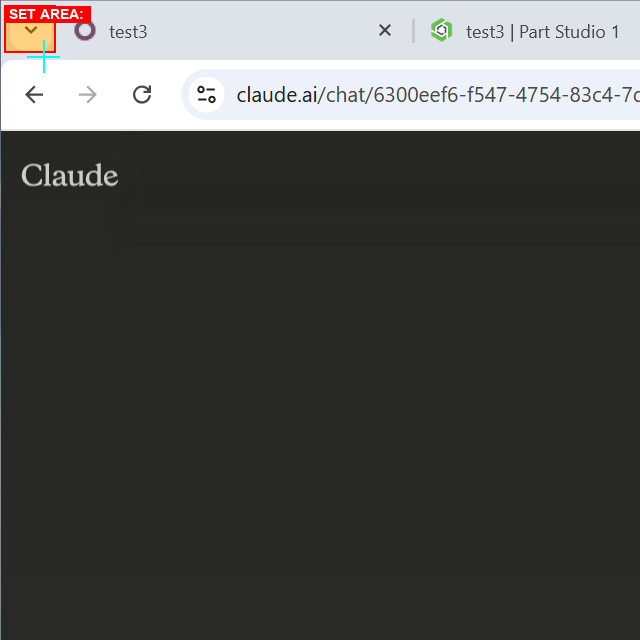

In [11]:
testx = collector.get_scope()
testx.render_preview()

In [ ]:
testx.find(tries=5)

In [ ]:
# testx.save_string()

In [12]:
# comment: Automated step generated with pyPeriscope V2 
payload = '''gASVnZEAAAAAAAB9lCiMBGFyZWGUWJwEAABpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBRE1BQUFBdkNBSUFBQURCMTJXZEFBQURPMGxFUVZSNG5PMllPM0xhUUJpQTl5RUpTUWlFWVVLVktsekRMdHh5QWhmWU0rSU1MdHliR1h0OEE0NWdYMEtOaDRZVFVDUk4wc1FKRGtqb3NYcnNwcEFIeTJaNVM4S1p5VmVobGREL2FYZTEyditIWDcvL0JCOFNkR2lCcGZ3MzJ4NWhxNnNSUXFvc0tTVkpFakhHQ0NNRUlWejdMOFpZSE5PWTBpQ01YRC93U0VncHpjd01RWGlrbDZ1YXVsNWtBUWloSUdBQjRKSWtWc29LQThDeTNUKzJReW5iMTZ4U2x1dFZEZU5zaGg0Q29GZFVUWlhIMDluTTlYYzNxMVhVdXE1bDRwUUdZOVNzVnpGQzA1bkx2V0NOMmFkNnRhTEttV3ZOYWRRMFFVRGp5V3p4MUtvQjBqVTFWNjE1RkYxVEY5dVhtaWtscVZITGZoQzVOR3FhSWt2dkd2bG1FTUptdlpxLzBpdk5vK3E3QllodnBtdEtWbS9paG1DTXFtVWwzYkxNakRQd2VWT3J2QW5LTVN0SllzRWRsb0F4S2tuaS9KQmpVRlpLQmZvc0RjMHhrMVBpQlNPdjdyT0RET1ZpYUo0Wk9wd1pXbW1HMEE3N2lXeEloLzY0TzhkOXpZYkRvV0VZaEpERlU0UVF3ekNHdytGdWQ5N0xiRFFhblorZm02YTVLT2Y3dm1FWXBtbGVYRnlNUnFPaXpWcXQxc25KQ1FCZ01CaWs1UWdoM1c1M01CZ0FBSTZQajF1dFZ0Rm1naUQwKy8xMnV6MlhDNElnR2NSRXE5MXU5L3Q5UWRndTIwaUFpNW53bDgvTnJXN0JHTHU2dXJxL3Z3Y0FuSjZlaG1INCtQZ0lBRGc3Tzd1NXVka2toVW56N2NkVDhtT1hwM2tIaFBEMjlwWXg5dkR3WUpwbTB0anBkSzZ2cjdmVlNwTlIwZ0hoM2QxZHA5TkpEcnZkYnEvWDIwY0xaTkpuYzNxOW5xN3JFTUxMeTh2OTc1YkJQTXVXK1R6N3A3NEJqSzFLblhNbG5iVnp6T0lOaWc0NWtRN05NNHNQWnhhdk5DTmhWS0RNRzRMb05UVEh6UFU0RzRkaVNJZm1tSGtrWEYwL3lnbEttVWVDK1NILzNiUWNyMENsRnl6SFM2OEsvUFZzWWprRnY2RXhwUlBMU2Jmd3pTaGpUODlXSVVvdlBJMHQrbllkWGZvTjhQemdlY29wYStYQmVESkx6N0NFVlYrbmllM2ErVTg0eS9HNFpjYzFlNDFmZit3Z2loczVWRU1UZms5c2E4Wi8rUFc3b0tudFJsSGNxRldFVEhQM0tJckgwNW16Zk8zY2FIL21lTVR4U0tVc1Z6VzFKTzY3cFNOaFpNMWMyMWxhMWQ3Q0xNRjJmTnZ4TVVLcUlwVkVVUklGVWNTYmxCcGlTc013RHNLSWhLSHJCUnV1UjF0M1FFeXA3ZmcyV1BQRSsvTVhnTlZOWERuTit6Z0FBQUFBU1VWT1JLNUNZSUk9lIwNY2xlYW5fcHJldmlld5RYHIwAAGlWQk9SdzBLR2dvQUFBQU5TVWhFVWdBQUFvQUFBQUtBQ0FJQUFBQ0RyMTUwQUFCbzNFbEVRVlI0bk8zZGVYd1RkZjQvOFBkbmNwUW1GQXBOcWdMU2dtQnBGUkFveUNFRlJCRjBCVmZBbjZzaWVDQ0t1eXR5Nkhvc25uaUFJSWl3b3VDQ0NMTExJYUJDRmZtQ0lJZFlXQVJ0cWFDMENDaE5DcVZ0VXBwalByOC9KcGxPMHFSTjJ5VFQ0L1Y4N0w1OTk5M0paRm9nbjN6bWM0VGRNK25wUWIyN0VBQUFBRVNSbGhHNzZaWmIxYjRNQUFDQXBrVlErd0lBQUFDYUlvR1kycGNBQUFEUTlLQUhEQUFBb0FJQkhXQUFBSURvRTRpaENRWUFBSWcyM0lJR0FBQlFBUnBnQUFBQUZXaHJmUU5hRUFSRE0zMXNqRjZ2MDJnMGdrWVFXQWgzc3pubmJyZm9Ga1dIMDJXLzVDZ3JkNHFpV050TENFYTZESkVUWTV3VGt5c0EwTEJ3NHNRWkkrSUNFemduSWg3dXA4RExCYWhHVzR1L2JRSmpyVm9hV3pRMzFPTHZLV05NcTlWb1NST2oxOFVaWXpsUmNZbjlRb2xORk1Qdzc0b1JjVTZjY1NZOWxUY0FRTVBFaUVtdlVJeHpUL3ZMaFBDMHduaTVBTlZwYS9wWExzN1lySFdMNWhwTmVPNWRNNktXY1libWhtYUZGMHRMN1pmcWRpN0dSZTc5NXdvQWpZMm5keW9TRTRqWHNRM0d5d1hVQTlvYUhSMGZaMmpkc25uWUwwS2pFUkpidDlBSXdzVlNlMjNQd2Noeit3Z0FHalZHbkVzZDJMcWRBaThYb0xZYWRHVE5yVnRFb3ZXVkpjUTNUNGl2emZrak16SUVBUFVZcitVL2VyeGNRUDBoaEhnbnAyVnpRNXloV1lRdmhsbzJON1JzYnFqWll4Z0diZ0NhSkZiekdTeDR1WUQ2SktRZWNHeU12blo5MDFwSWlHOGUyMHdmNnRGMXVnMEZBQTFjalc0azQrVUM2cG5xRzJER1dHTHJGbEc0RkZsaXF4YWhyR2dpWWhUMkZVd0EwS0J3VHFGMWhQRnlBZlZPOVExd3krYXg0WnJ6SENLTlJtaGhqSzMrdUZyY2dBS0FSb1lSc1JBNnRuaTVnUHFuK2xuUU5SNlVEWWY0T0VQMU02SkZ6R01FQUNJeGhNYTE1aThYbkhOT29zQTBidEY5ck9UZ25wTFBPc1JjYzMzTFcxcm9XeEZIY3c1aFVFMERIS1BYUmJuN0s5Rm9oQmk5cnR6aERIWUFJK0sxK2dkUWJMMXdzZUI4VVVHaHM3emM1WEl4WXJvWWZUTkRyRFpHMStweWM0dkUxanFkcnZiWERRRFJ4M3lHZDR1c2Z6akx5M1F4c2ZHbXk3M2ZyOW5MQmVlY0V4ZVl3RWh6eW5iaVlNbTI0NWQrY0x2Y0Y5M1czOTIvcHNYMHZTNHVRNnZWY3VLY2M0RmhRMStvcFdvYVlHTnNUSFN1SStCVFY5RUE4NXE4QlJWRmtUaDN1OXlpeUMybmZzODdlaXp2eU04Tys2VVlmUXhqekY1ZUZwK1lZR2hoN05nenJhTWhob3dHalViRFF0dFpFd0RxQStVTGd1T1NYWTZWdjFzdGtZc0NFeGl4RXNmRmZVVmJqemtQT0hnWmQ1Q1c5SzVMenVPWGpqcGEyYStMNnhGcnY2eU1PUmhqSW9tTUdMYjBnRnJRVmoxNDBreXZXbmV3NnFjTy9kOFQ1MXdRaEpMQ29qTW44ci8vN1A4dTJjcGNUamNSSncwcmR6bUlTTkFJRjYxRnhlZUxyS2ZQSGRuK1hkZkJmZHBmMDZuMUZZbWNjN1RCQUExQzFTOElJYjVjY001RkVqVk1jOGxWbGxQNjNYZWwyMHJaZVVlcFV5L0VNSElYdTRxTTJyaFJiZThiZmZVNERkUHVjWDc5WThGUDZjYWJXc1dZaVlpVHlQRFpObEJEMWZTQVZibi9ITXBUaDk0d2ltNTMwYm5DVTlrbnp1Ym1sWlhhbk9WT2FVOVp4cGlnMFVnSGNNN0pUYUxMelVVeC84aHhVZVJNbzJtWjBJcHAwQUFETkFCVi8wTU44Wjh4WTB4RG1oT2xSN0xzWDU5Mm5IQmVjbW5jR3AxR2IzZmFuQzVIZXVJTkk2LzZ5MVh4S2JrWGZ2ejg1SDhPVzc0enRteCt2T3p3ZGJHRGVyUVlIS3RWWWE0TU5IVFZOY0NDZWcxdzFVL05RN3Jsd3prWDNhNnpKL0pQSFBxcDlPeDVsOHZGQk1aSXd4aHBkVnBkakk2SUhPVk90OVBGT1JHSkxxZnJmUDd2YmhLYng3ZUlheFhIQkIwNndRQU5RTlV2Q0tHOVhKd3ZMOWhUdFBtRTQ0aVRPNmhjb3lXZGt6bnNsMnh0RFVsM2QzK29WMkovSWpwd2J2ZkNIMTZ4TysyWEdkcVFuUzZ5ODN2cDgyUDJnLzFhak9nUzF3c3ZGMUFqMVRUQWdxRGEzNmRxbmpxMDYzSzczWmZLSEllMzdiR1hsTHFjTG9FRWJUTjkvT1VKM1lmME0xMTVlWXZXOFVSa0x5NHBLamgvNExQL3UvQkhvYXZjWVhkZWN1U2YrZTc4eGFScnI5YnE4TThKSUp6T0YxcVhMMTF5ei8wUFhINUZHNzl2L2ZINzJkVWYvWHZpWTMrTmE5R3l4dWNOUnhmNDhJVnZUeHFPT292ZG9rakVYS1dPNGhiYStORlgzWDlINTN2SUlYejc3YmR0MjdXOTlvcWVUM1I3NGZPVGEzT0xqamJUeGVxWTNsM0t6emMvdSsvUzUrMmJkVGJxYTM3bDZ0bnkrYWJQTjY1ZnZQUWp0Uzhrc2lZL2ZQK2Y3aGg5NjU5R3FYMGhBZFRzd3hnYW5LSS9yR2VPbjdTWDJsMU9GeEhwamJGSlhUdTNUNzBxc2YwVmhwWXR0SG9kRVJsYU5HY2FUZmNoZmZOemZzay9ldnlTM2VaeXVzcHNaYWR6VHBpVHJtaGhhcTMyRDBFem41bG10VmlrZk1EQVFmZU9mMGpkNndHb3RSWEwzajl4UFBmdE9hODlPZU5aWlJ2OHgrOW4zNTd6V2tseDhZY2YvT3VKYWY5UTVkb0VwbkdXdWhnblRxTEw3YnloemMwak85N2Rybm55a1I5K1dQL3ArdThQWktXbnA4OThmbWI2NVFONlh0NDM4K1NubWZrYmJPNFNMZW5jNVNUeW11M0tGVGxoZWJuNGJ0K2VGY3VXS0N1UmJzTW1QM3kvOHN0WDM1elhPc0VVOW1kWnRXTFpudDNmMVAza001K1pObVg2TTNXL3dtb21ZZFhJOTk5L3Yzang0dmZlZXk4bXhuL3VkSGw1K2FPUFBqcDU4dVRldlh1SDd3bXJkK0VQeXk4SHM5MU9GeGU1VnFlTFMyalpzWHRxeCs1ZGxNZG85Zm80dlQ2dVR6ZXRYbi9oYklHenZOemxkTHFjenJ3ZmY5WWJZbXJVQUU5KytQN3hEMDI2dnQrQXVsenpncmx2bUV4bStaL05pWjl6K3c3SWtQL3FUMzc0ZnF2Vm90WXJGRUFkM2YvZ3hQbHZ2VkZvdGN4LzYvVXAwNStSMnVBL2ZqODcvNjNYUzRxTEUwem0rOVI4ZjhtWndFaWdzbkw3L1NtVGIwNjY0OXp2NXhiOGU4SGViL2RxdGRxLy9PVXZOOTk4ODFkZmYvVy93Lys3ZGZpSVczdU82Vzd1TSt2QWRJZFlybUVhWHZOMWtmWC81VUp1cUU3OG5EdHY5cXdMaGRiYU5lZFYvNlJTWTY4OFlOV0taU0UrTnZxa1gwVzR6aWFFYTNQVTNOemNjZVBHN2RpeDQ0RUhIaWd2TDFkKzY5S2xTdzg4OE1DT0hUdnV2Ly8rM056YzhEeGZhTndPWituRmk0d3hSb3h6M25ma1RlYjJiZHh1dHlqNjdFb25pcUxiN1c3VkpySDcwSDZjYzJuRDlsOStPSGF4NEVMb3ozVyswQnFXYXk2MFdwUmZkcm82UmZuR2MveERrM0p6c3NQMVhBQlJsbUF5VDVuK2p3U1R1ZmppeGZsdnZmN0g3MmVsMXJmNDRrWDVXMnBkR3lPQk9IRXVFcWVyV25jcEtTcCtmZmFzZlh2MjllclY2OFVYWHh3M2JseENRc0lmZi95UmUrelluTGx6dnZ0dWY5dm03WFZNN3hKZHhHdmMramFzbDR0T1Y2ZU1mMmpTbnQzZjFPSlUxVDdraTgwYkJnd2NwR3hpN3gzL2tOVHdoLzJGN3Q3eER5MWUrbEh0ZXE3bkM2MlRINzQvakswdjFlampDS3QyMVZWWERSdzRrSWoyN3QycmJJUEx5OHNmZlBEQnZYdjNFdEVOTjl4dzFWVlhoZXNaUTNISmZzbGQ1cERlMkdyMXV2akUxckhHV0kxR0kvak84QklFUWFQUkdPS01waXV2ME9wMVRHQkVuRnp1OGt1WG9ubTFBRTJCMU5DMmFObXkrT0xGZWJOZm16Zjd0ZnJRK2hLUnczM0pLVG8xcEdHTXViakQ2WFQ5OGNlNTY2Ky9mdnIwNlowN2QzYTczWXl4Qng5OGNNS0VCOHJLeXN2TG5VU2l5RVdOSVBEYWZ6cGlnNUhnYVJFTEkzSHlWaEc0Mnh4MjBzLys2cHZ6eGo4MEtWem4xSVpyMkVLcjFTNVpzdVN2Zi8zcmxpMWJwRFo0K2ZMbG5QTUhIbmhBYW4xdnZmWFdkOTk5VjRqdXRPcnlTNWZJUmFKSVRCQjBlcjJ4VlF1TlJoUHNZSDFzVEh4TWdrNnZjem9jb2tneEdvM2I1UXJ4aWFTaEJTSmFzV3pKaW1WTFVsTFQ1TnMreXJFTjVYd0h2MXNaaTVkK0pJKzdXQzNmU0dlclBEK2lzTkJxTXBzak1Ub0NFRFVKSnZPVTZjL01tLzFhYVVreDV6eXVSVXZWVzE4aVNvN3JsT2Y0MzI4WFR6UE9SVkdNajI5NTFWVlhTZnNCT0oxT3JWWXIzVHlMaTR0alRGcW1JVERHUkNJdFl6WGFhcnFodjF6NGpSQlBmZXE1VGxlblNQbk1aNmFsZEVscmxXRDZmT042azltYzBpVXQyRThxU3pDWlA5KzR2dklBYzhEZjBvSzVieENSOGlRQks3azUyZksxS2M5WmVkNlovQ3hFWkRLYlgzNTlickNmdXRQVktkNEhodTArYmpnbllRbUNzR2pSb24vODR4Ly8rYzkvOXU3ZE8yblNKS2ZUS2JXK2Q5OTk5K3V2dng3OU9mcU1NYTc0eEdOVzNhWnh2Z2Y3UExacTk0NS9hTVNmUmozLzlGVGxjTVg1UXV2elQwK1ZKeStzV3JGczhzUDNTMytFMHQ5ZytTK3VOT1p4ZmI4QjEvY2JJUDBORGpqV2N1TG4zTTgzcnZmN0t3WFFFRWw3dnRhcjdXNzZKR1FNTm1Vc0V4WitjM3Fydysza2pQLzlpYis3SEM2MzJ5MzFIS1FYQktmVDZkMzZpaE1SNDV4Q2ZxR1FOTVNYaTU5L1BrWkUwZ1Y4c1htRDNJWnQrWHpUdk5temxOT2FjbzlscDNSSmt3K28vSlA2ZVdMYVB5WS9mSC9sdWNvQmYwdlZtdm5NdEFTVFdYNTJ2N2xkbFE4bXhSdVhCWFBmbVB6dy9SR2EveFZRbVB1ampMRTMzbmpqcnJ2dUlxSWRPM1o4KysyM1JIVGZmZmVwMHZvU2tVYXJkWE8zSUJDSm90UGhLRHBuY1pTVkJ6dlk1WERhaW9xZERpZUpYQkNJTkJUVHJGbGRubjNsOHFVcHFXbnlYeW5wSDhtV3p6ZVI5NTJwL0xheDZxa05XejdmSlAwRi9lamY3eTllK3BIOEtJQUdxdEJxbWYvV0c2VWx4WEV0V2phUGExRmFVaXpOekZMM3FvN2JzeDNNT2JucjA5TjZ2SHBaOHlzS3psbmVudmQyWGw2ZU5FVEZPZGZwZElJZ2FBU055KzF5dVYyZVRpL3pmQjVUSFc5QjErZVhpKy8yN2ZsODQzcjUxcXV5bXloZDhQR2ZmVHFGTloycnRYanBSd01HRHZwODQvckpEOTh2L2NpMXMrWHpUVmFMejZTekt0NS9TQWNyZjVZbnB2M0RaRFp2cmNNRjFGVDRseUV4eG1iUG5xM1g2ei8rK0dNaWV2REJCMmZPbkJuMlp3bFJUTE5tWEtzaGg4aEYwZVZ3RnY3MnU2RFJhUFJheHBqeVpyZ29pcHp6TWx2WmhYT0ZMb2VUaTV3SmdxYVp2bGxzblJyZzNKeHN2OUdDbE5TMEM0VldJa3BJTUZrdGxsVXJsb1h5Ti9YV1A0MlMvcFpMc3dDcXZrOENVTTlKclcraDFkS2laY3NwMDU4aG92bHZ2UzRWMWIwUmZmRGMzbzNGUzI1cS9lY2IyOXhLQXAwM25uYzRIRysrK2ViMTExOC9ac3lZTGwyNjVPZm5sNVNVdU53dWc4SFFxblZyTjdta3ZpOW52TzZmZGxnUFh5NmVmM3FxblB2MUMvMXVpUmNxWmt1bGRFbXJ4WFBkTy82aGU4Yy90R0R1RzU5dlhIODhONmQyTTdlUDUrWU1HRGhJV2FuaS9VZmxnNGtvcFV0YTdySHNXangxN1dnajlLbGFyNzc2YXN1V0xSbGowNmRQajhUNVE5UXlNYUZqOTlTZnZ6L0NpVFBHRG0vZm56NWlVSHhpZ3Q5aFVtTnN6VCtidGZVYnhwajBJU2ZOVzhkcm0rbHIvZFRTL0QxcDlNTG5HNmxwUkhSOXZ3RUpDYVo1czJjRkc3d0pxSFdDYWZIU2o2UTNpZlZ6WFRsQTFmeGFYMmtaMHBUcHo5U0hOamhXWnlpOFpQMTM5anU3ejN4NVI4ZHgzYzNwYjh4NmM4Tm42ek8vMlByU1N5OE5HalJvMzc1OXZYdjNIajFtOUt5WFozWHMxTEhVVWF6VmFzbEJBaE5xZUJQYVgvMTh1UWg0TTFhNlZhNzhidFczZVd2a2lXbi9rSnIyNy9idHFjWFNvMEtyeFJUeVg1NkFCMGQ1T2xnRU4rS1lNV05HNUU0ZW9wYm0rT1N1blg4OW5PMFUzVzYzcTdqdzRpOC81TGdjanNzN0o4VWFZN1Y2UFJFNUxwWGJMNVpZOHMvbTUveFNmUDZpMisxaUF0UG90QjE3cExhNnJQWi9HTkpmelNwR0wrUWgvWm5QVEt2UndJUEpyUEpjRllCYSsrakREd3F0bHJnV0xlVFdsNGd1djZMTmxPblB2RDNudFVLcjVhTVBQM2p5cVdkVnVUWTNkK21aVHFlUE9YSHgyTnovUGQvdjhpRzNkaGp6bDd2K011RDZBUnMyYmRpMmJWdHloK1FoTjk1NHhlVlhGRnc2KzRmdGRPdFlzOGc1Y2VKdVRucnU1bUwxenhGRUEzcTUyUHI1cG9qZWhPdDBkWXJKYkQ3eDg3RklyLzBOK0Q3dlFuUlhlQXIxWmdKRVJMUXd0YjR5OWFwWVk2eFdweVZpRG52WnljUEhmdGo1M1lYZkxmYmlVcGZENlhJNFM0c3VGcHc2KzhPTy9TY1BIM1BZeW9oSXE5TWFtaHM2WHBmV3NpWU5jT1YvRDlKZm8yb2ZLTjJGa3dkUnFuMzdiN1ZZRWpBTEdocW04UTg5MHFseml0ODJXRVIwK1JWdG5wenhiSEtIanVNZmVrU3RhOU96WnFSajVWUVdwMnRoMEJwMy83N3R0UU16VnVlOGI3b3lZY3JmcDd6KzJ1dXpYbnJ0bXJTMGJmbWJudHN6K2RpRm96b1dJMzNRVWt5Y1JzOWpZNFFhZkhocmczNjVVRDdwaVorcm1SSmN1d2xOVWs4MHdHL0paUGFiSzZEOHN2SU41Ty8yN1FuMkZKMVRVdVg1ejdMY1k5bDlCMlRVNG9KcnB3YXpncU5NRkt0NjZoQXZqSE91MFFwOVJnNDFKN1V6NkdJNGNhZWp2Q0QvOXk4V3IxNHo2NzJQWnk3NGVPYUM5Vzh1M2I1aVk4R3BQNXlPY3M2NFFSZmJ1czFsM1cvcUgydU0wV2lEcmxrS3lPK2YwUDBQUExKbjl6ZktPUVVMNXI0aDNXdGF0V0tadk1aYytyZlUyVHRXWVRLWmxYK0g1SWRJWmo0enpXUTIxNTk5WVFCcXBIV0NhZXJUejFYZUNKcUlMcitpelZQUHZWakxDYWhWdmg2RStITFJwL1ZOR2NLZHJYU0paQkJGSnNicldydko5ZG1wL3p5NzY3SC9PL1ZGaDVTazA2NWZYdDcvNUVmSEZwYzRMK3FGWm94STIxeUlqWTFONHdOSG1SNkowY1hXNkpJYjZNdEZxd1JUYms2MjNPNkdzakZGMWU4dC9PNWdyMXF4ekdxeDlQVmVzOTlqTzEzZHhXcXh5TTJxZExEODNSRi9HbVcxV0tTRlNVUjB2dERxZjB0ZlFib3RMMDJFbGl5WSs0YlZZb25tNkY0MVcxRzZSVkViZk9Gc1JMbkZxdTduaFA3NVlvS2dUVXh1YTd0WStoc1R6dVg5NW5RNE9YY1JrZWgydTUyZVJQNkFRbDJNTHJIVGxXMVNrdHQwVGhZMDJwck8zTDcvZ1Vla2NScHB5VnFucTFPbVB2WGN2Tm16UHQrNFhqcmdUM2VNbGw1ZldpV1lnazF3dUhmOFE5SWtSaUphdlBTanppbXB5aVByN2E3aUFHcGlWWDNtYjRqL2pIVmFmYS9XUXpvWnV2L1B0dk1IOTI2bjVwSlFxbW1sVDdqZ3NDN0xmbnZINlMxLzJNK1V1VzB0OVBIRmptSkJJeENqSzRXVXRGWjlyMnB4YlMwdXVZRytYTno2cDFFWENxMXl1eXNOTTFmOUVMK2Z0UElCeWpPWXpHYmxJTGZmWTYvdk42Q3cwQ29QbG85L2FKSlYwUU51bldCNjljMTV6ejg5VlRxaGRLb3FMbS94MG8ra3BVZlNseW1wYVZIK2FBcDI3K1RuWG43bTc4RyszVGF4Vll4ZUY4MExrbDBxZDU2MUJOMEprb2Y0QVdQZWhZYm4vN0NjK3VuRTBSMzdMOW5LWEM0WEY0a3g3bm5YektUL002MU8wOHdZbTM3N2tMYWRrbG9rdEtwWEt4UUJvQXJLRjRTQzA3OUtTV0s3anBXL1d6V1J1d1dtSWFJL2JLZStLODdNdmZRL3pqaHpNTVlFbTdNa1J0dE16L1FPN3VDeDdudmJUTDZtMllBTFpjVTZyVjdrYmtaQ2czdTVhQ0tmaGxTZlZUTUpxOXpwVXFzQmRsUzVDeFVMOVIrVVp6K05lSFByNWpmMDdOUXo3Y1Qvc244NTlKTzkxRlo4N3J4Qkg4dUpsenZLOWNhWTl0MnU3bkJObHl0VHJ4STBUS1BWaUtJWTVVMjdBS0RXcW41QkNQM2xRbUFha1l1Y2k1Y2IyNDh5UG5LOCtJYzlGN1pZWS9ORmw2czVqM09UbXh2Y1JqR3VhN01CWnZIcVV1Y2xxZldWMm15QW1xcW1BYmFYbGJjdzFteGdJMXpzd1hmTUlDTEdhckRzblRIR05CcTlSaU1JbW5aWGR6UzJhTzV5T3N0dGw1emxEazVjcTlYcW1zWEVKeWEwTUxXS01kUmdHZ1VBMUJOVnZ5RFU2T1ZDWUFJeFFlUWlZNnh6aSs3dERTay9sWHozUC91Tzg5cHp2SnhmcGUzVnUvbU43WXhYS1k1SDZ3dTFwSzM2ZldGWnVWTVV1U0JFKzlhS0tQS3lja2NWQjNER1NLeng1MjlxZFZwVHU4dE03UzZyMDhVQlFIM0NPVEdCVmJFZlpDMWVMZ1FtRUpISXhSaHRzNTZ0QmwxbDZIcnc0dmJXeHN1N3Q3cUJNWVplTDRSRk5UMWd6bm14clN3K3poQ2RxNUVWMjhxcW1iZkllZFhUTGdDZ2lmRGJ0VjJqMWJsZFRvMVdNWFpXMjVjTHdidDdmTXVZMWpjbWpsWFVHMFBySysrWkJXcXBmaWVzb21KYm5MR1pKb29Eb201UkxDcTJWWDhjWTlKbjkwYitpZ0NnbnVMRUJXTEt0K3NKbDE4WjREaThYRUQ5VTMyektuSmVjTDQ0Q3BjaUt5Z3NGa05adDhkSndEOG5nS2FOTVJiYW5nQjR1WUI2SjZSK2Jka2x4L21McFpHK0ZFbGhVV25Wbzc5SzB1cmRTRjRPQU5SanJBWWZRb1NYQzZodlF0MktzcWpFWG1JcmkvREZVTEd0N0dLcHZXYVA0WnpYOVhQQUFLQUJxc1ZIQU9MbEF1cVRHb3pzV2k2VUZFYXlIMnd0S3JGZUtLbkZBeG5lMWdJME1ZeHFPWjZMbHd1b1AycjJhVWdYUyt3dWx6c2hQazZyQ2VlY0xKZkxYWGl4MUZibHd0K3FjVy9FUHkyQVJvNXp4VDUydFRxQk4rTGxBdFJWNDQ4anRKV1YyOHJLNDR6TldqUTN4T2pxK21tRzVVNVhjYW05eEhhcGp1ZVJNQ0ppaklzY2IzRUJHaC9PaWJHd1RXVEd5d1dvcnBZdGFJbnRVb250a2tZUURMSDZHSjFPcjlQcWRKcFFsaXE1UmRIcGREdWNybktuMDE3bXFQb1RGMnFEUy8rY0dESGkzby9ueE5vRGdJYUlFNWRtV1RFbWtOVHZEZThJTGw0dVFGWFY3SVJWTmJjb2x0Z3VsVkI0K3E5aHhZbmpIeEpBdzhhOG41UlN4UzVYNFlDWEMxQUhQbThBQUFCQUJXaUFBUUFBVklBR0dBQUFRQVZvZ0FFQUFGU0FCaGdBQUVBRmFJQUJBQUJVZ0FZWUFBQkFCZmlFTGdBQUFCVUUzUWxMRUZqejJHYUdabnFkVHF2UkNLRithaElBQUFDRUlFQURyTkVJOGMwTkxackhNalM2QUFBQWtlRy9GYVVoTmlheGRRdjBkd0VBQUNMS3B3Y2NIMmRvM2JLNVdwY0NBQURRZEFoeVZ6Zk8wQXl0THdBQVFIUjRHbUM5VG10dTNVTGxhd0VBQUdneVBLTzlyVm9ZMWI0U0FBQ0FKa1FnSW8xR01NYkdxSDBsQUFBQVRZaEF4SnZITmxQN01nQUFBSm9XcmNBWXVyOFFkbTZSTzF4Y0ZMbkl1U2lTeURubmFsOFRBRUI5b21XTTlQcWcrMkVCMUlqTHpSMHUwZUVVUlRTM0FBQlYwcEk4RVF1Z0Rod3UwVjd1RmtXMXJ3TUFvSUhRRWo2TkFlckc2ZWIyUzI0Mytyd0FBRFdoUmZzTGRXRzc1QzUzb3RzTEFGQmpHUDJGV2hJNWxkaGQ2UGdDQU5RT0dtQ29EYWVMbDVhNTBQWUNBTlFhR21Db3NiSnlkNWtEdDUwQkFPb0VEVERVak1NbFZ0djZhZ1NtMHdvNkRlbTBRckJqbkM3UjZTYW5TNHpZVFd6R09jY0Vmd0NvdDdUWUh3RkM1M0x6MGpKM0ZRY0lqTVhHQ0RHNm9PMnVUS2NWZEZxaUdLSGNLWlk1eERBdUhHYU11RWpFMFBvQ1FMMkdIakNFU3VSVVV1WUs5bDNHcUpsT2FLYlgxTFRaaTlFSmVxMXd5ZUcrNUJUci9tNlFFWW1jMFBRQ1FQMkhCaGhDWlN0ekJXc2dHU05qTTQwKytBM25xakZHc1RFYWpZYlpMcm5yMkFaekxHd0hnQWFpbHErWTBOUzQzTnpwRHR3MkNnS0xpOVhXdXZXVjZiVkNYS3kyMXZ1eW9kY0xBQTBMR21BSWliMDg4TkF2STJyZVRLUFZoS2YxMDJwWTg5aGFuZ3U3WUFKQXd5SmdEaFpVeStFU1hVRzZ2OGJ3dGI0U3JZWVptMmxxOFVEMGdBR2dZVUVQR0twbnZ4UzQreHVqRS9RaFRIaXVLYjB1cEhuVUFBQU5XalFtWVowN2Q0NXpmdm5sbDBmaHVXckhack14eGd3R2c5b1hFb0RkYnYvcHA1OU9uejVOUkpkZmZubHFhbXA4Zkx6MHJYUG56bjMxMVZkRU5HN2N1TWhkZ05QTkF5NFJZb3dNTVlHN3FpNlhLemMzVjYvWGQrellVYU9wVFhjMk5rYmpjSVZoVWpRQVFMMmxKWXJzaTV6VmFwMHhZNGJMNVpvelowN2J0bTBqK2x5MVUxcGF1blBuVGtFUWhnd1pFaHNicS9ibFZQamhoeC9XcmwxNzZOQWgwWGQ0czJQSGpnODg4RUR2M3IzUG5UdTNhdFVxaW5BRDdBanlXUXV4UVZZY0hUOSsvTDc3N2p0Mzdod1J0V3ZYN3VPUFAwNU9UcTdwa3dxTVl2V2FZQVBQTmJmckgxMGYraXI1dWM4L205QW1UR2NNN016eU80ZlBvcWQyYkJqWExnSm5QNzN1M2lHdm5ibnozUy9mN0I5VCs1TnNmdUt4TlRUK3JRVmpJdnVyYUxUT1pTMmE5ZDZlazNhbkx1UFpEWS8ycU92cExBZm16MXUwSzkvdTFBMStjY1hqdmNKeGhkQmdSTFlIYkxWYXAwNmRXbEJRRUJjWDUzYUg2OFUwek54dXQ4dmxjcmxjTzNic3FDZHRNT2Y4L2ZmZi8vVFRUNlV2MjdkdjM3Smx5N0t5c3J5OFBKZkw5ZXV2di83em4vOGNQbno0b0VHRG9uQXhEbGVBQmxnanNHYjZBSGVKUzB0TDc3bm5Ib3ZGY3UyMTE1NCtmZnIwNmROMzMzMzM5dTNialVaalRaODNSaStVT3lPM1QxYmpjL1M5OGM5bTlYbHQ2ZU5kMWI0U0lxS2lMNlpQWGs3ajNuOXJSQ3R2NmNMUnJSOThzUDd3U2J1VGlIU20vbE5lZmpJalhqcjR3UEwzMW00L2NhYkk3aVRTR2ErNFpzeERrOGVrdGZJL3ArWEFvb1hMdDUrd09JbDBwdXZ1ZWJUeU1RWDdsODMvWU5meEFpZVJ6dHh6OU9OVFJsNVQ2U3gxVXBvMSs0bDUzMVBTelEvZjN2YWtWZm56L3JScDJmSlBqdVRabkVTa1MrejMrRnQvRzFEOVU5c092UHJNbk84b2VmaTRPOXJsRjBpMS9Rdkh6dHJuZDF6LzUxWS8yVGZnR1lxK21ENTVlZTRWOS94cjdwL2JCWDI0Vjc4Wm4vMnRUN1VYVmZlVDEvRkhxSWFqWU5mSytTdThmOG9wR2ZmT0dEZmdNcjM4N1F2N1AxbThldGZQcHkvYW5VUTZRNXV1SXgrcC9WK0QwSy90N0tlUFRsOTlKdkQzMmdSOXZ4dkJCbGh1ZlpzMWF6Wjc5dXoyN2R0SDdybnFvbVhMbG9NR0RkcTVjNmZkYnE4bmJmQUhIM3dndGI1RGhnd1pOV3BVbHk1ZHBMb29pai84OE1PNmRlc09IanlZbVpsNTVNaVJTRitKeXgxNHE3UmdZN1RMbHkrM1dDeGp4b3g1NjYyM3lzdkxuM3p5eVMxYnRxeGV2WHJpeEluNzl1M2J2MzkvNVllMGI5OSs5T2pSbGV1TVNLdGhhSUFWMm8xWmRYeE1rTzg1OXF6YlpVKzgvZGJvdEw2TzdFOW5yZHpZYXZTS0tlbUJEL2gxNnhlNWROMk1vZDdYUGR0UGk1NTVNZE9xYTl2dHRvY3prbHRkek51MUwrK0NuU2llaUlqeXY5OXROL2NkZVd0WGs5NWhQWnk1ZGVlS1Y2ZjhPblh4VSttS3QyMW5QLzM3OU5VblczWWVldmZZbnJyam16ZHZxM1RNbVhYUFRGbVJINStTY2M5ZnV1bHpNemRtcm5ueHNmd1pTLy9XcDNuWWZ1NEx1emQvYnpNTWZ1MzFSNVMvNTlMczk1OTRkVnVCcmszUDRST0dKc1ZmeU4rek83L0lSbFR0aS82RmZSdS9zeHVHUGovbjhUUzVWbkR1TEpFaCtmcjBaTVZsZDA0TWZBTEgvcFgvemZVdEphWU9IcXFyZE56Wnc3dFBGUFhzZGsxMVZ4U1drOWYxUjZqU21YVXZURm1ScjJ2YjY1NG4rc1VYN2R1NGV2djhoMDhVL090MXVZSE0yNy9QbHBoK3g4alVSTDJ6NE5EMkxkdHIvOWVnSnRkbVNPNmJNYmpJdjFwMGJOL2hNeTJ2Nnhuc2JsT2tHbUM1OVkySmlYbjk5ZGM3ZE9nUW9TY0tpMWF0V2cwYU5PaWJiNzZwRDIzdzNyMTdOMnpZUUVRUFBmVFEyTEZqbGQ4U0JLRkhqeDQ5ZXZSWXZuejVtalZyenA0OUcrbUxDZGo5SlNLZE52Q2M0NXljSENJYU1tUUlFY1hFeEF3Yk5tekxsaTAvL3ZnakVlM2Z2My9CZ2dXVkg5Sy9mLytBRFRBUjZYVUNQbXc0TkJlMmYzR0lPajg4SWtyL3pncE83RHlVYng4WTlQcy9iZDV1TVdZOG51SHBsOWkrWHZoaXBqVjU5R3V6SmlSTHBRRVpJeFNIZDM5OFdYZjVpd0UzRGUzOTZoTnpkbiswY1V6NnZSMDl4UXViM2x0OTB0RC91YmVlN0dza29pRVpHZGZOZm1MTzd2ZVdqL0QyK0M5c1hiUWkzekJ3Nm55cFNiNnAvK0JlQ3lmUDJyZG82ZEErVTlJb1RPdzJHMUhMTmo0dHEyM0huRmUzRlNUZHNlQ2xlenRLUDF6L0FhTkNPNTNOYmlPS2J4ZXZyRG1kRHFJMk56Lys2TERxTzIxNXF6N1laL2VyZGJ6cDhTazMrZFhPckp1MmMvY1Y5MHdjVkpQN1VMVS9lVjEvaENwYytIclJpbnhLZVhEUld6ZTFJaUxxUDZUdkowODg5dG5xRDc2NTdhVkIwbSsveDVSM0tzWUZNZ1lONnp0MzhxeDl5OWZkM21kQ2N1alBVL05yaSs4eG9kSjRoQ1ByN2Z0M0dRYmVMLzgxcmtRYmlYa3VjdXVyMCtsZWZmWFYxTlRVOEQ5SHVMVnUzWHJnd0lHN2R1MVN0dzB1THk5LzU1MTNpT2lPTys3d2EzMko2Tnk1YzlMWWFzK2VQYk95c2s2Y09CSHA2M0VIV1gya0VRSTN3TzNhdFNPaXI3NzZhdGl3WVp6emJkdTJFWkYwODZOdjM4QTNvS3E0TmFMVE1NWUlVN0dxZDNMVDF1UFViY3FJZUxVdmhJaUlISHMzYnJlYlJ3LzNkb215VnkwOVFpa1BQdXR0ZmF0ajdITlRkL3B1WDBFQmtlZVZLMi9MNWhPVU1tNUNYMlBGTVJOSGQ5NjljdWZXck1lN3BwUG5OOUJwd3NTS0RyR3g3N2k3VXZZdDM3Nzl3SlMwbXR4M3JhR2phNVlmb3M2VG4vYTJ2blZXU2tUbStCQnVtWjdadEdSTFFiZGJoMXUyWkZaNW5DUHJ2K3QrTnd5Y2VsdE41aVhVNmVSaC94Rmt2K1ljSjJyVFZ6SDAwRzdRNExhZnJUNTMwVUlVY0lxUnNlK2c2K2pnM2dJclVYSm96MUhiYTZ0OGhzMmY3TFZkY2M4OTZjSC9ab1MvQnl5M3ZscXQ5dVdYWCs3YXRWNk1TSVhDWkRMZGNNTU51M2Z2VnJFTjNycDFhMUZSVVlzV0xSNTQ0SUhLMy8zcXE2K2tXVmRSVTlPMmIrellzY3VXTGR1MGFkUHUzYnRkTGxkeGNYRk1UTXhkZDkxRlJQMzY5ZXZYcjE5TkwwQWpzR0JMa0FNcFB2TGZtYTh0M3Zaem9ZT0k5QW1wazk3Yi9FQ1hRQWVXbjk0eC8rbUZtdzdrbFJBUk5VKzU4NlgzM2h4aThueno3TXBiL2pTYnBtVitlYS9pbjNTZ1l2R1JsVSsvK0srdjgwcUl5TlRydnBkZnZ5dlFVNTNadHZENVdldXl6amlJS0M3MTlsY1hQM3RqdTJDVHFFcCsrR1RXSysvc3pMVTZpRWpmZHZDVStTK051eTdPODgzVHEyNGZNamZ2dG5lUHp1L3YrNmpzTFpsV3c5QkhCL2o4UXkvNmFkT3k1ZXVPNUJVNWlVZ1huelQycGRmL3JId25maTdyL1RrZjdjeTFPa2xuNk5EdjhlY2U3WE5aeFRjZDUvWXVuN04rejYrL1N3TnB5Um1QenBpU25ramtNOWExZTk3WTNVU1ZodmN1Yk0wOFRKMG1qRXIyZkwxLyt6YWJZZkQ0bTJvL0duc3U1M0FCdFJuWTNlY01yYnBmMDNibDhWK1BuNkgwdG1USlBtU2x0djJ1OHpraS9ycHJyNkRjdk9PbnFZKzNlVkNPUStzU3U0MmQ4dWlmdThZckh4UDBBTVc0NXVySDdsbE5SQU9ucm4wcS9jRFc3WFpqeHIwMWZ1dVQ5ZmJ0OC9aSzZZcnBZMWVRUElaNnB1RDNrSnFLMDF2bkw4M3ZQSG54TU5zclc2bzhNSVJtSU13bkQvdVBVS0ZqYW1mYVp6bG5VNVNLemhZUnRhdnBFaFpId2E2VjgxZnZ5enZqbVhiUWUvSS92VE1TYW50dC9zOFE1SDNQaGV4UDV5L2JlUFIzdTVOMGlXRnVnT1hXVnhDRW1UTm45dWhSNXptQzBaV1ltRGhnd0lBOWUvYW8xUWJ2M3IyYmlHNjg4Y2FZbU5yUGN3MmptcTRFNnRTcDA1SWxTNlpObTNiKy9Ia2lNcGxNYytmT3ZmTEtLMnQ5QVRYWVhxUDR1MWxqNzF0L2xoTFN4ejg3OC9xRThqTUhOMjA0YXcxODdON25oMHpMTkhVZDlkenJON2FsTXh2ZW1iMWgya2g2ZDBlTlpoZi9zdXJlNFhPUFVFSzM4YzgrZEgzY21hOVhMNXQ4NS9lcE1VUnh5cU5PTGg4L2N0YlBDWDN1K2VkenZlTE83UHg0eVdkUERNbDlLblBOdUtzQ25QTE04dkgzemNwTEhqamhuMy9wYXJJZVhEWm45ZXl4RTJuSG1xcm5WRHQyYmQ1cE05MHhVbkdqMVRzcWFVN0ptREF4TmQ1aC9XbjNOMmN2S0I1ekx1dnRKOWJuWFR0NjRveVdSYnMyci8xdTE1d25uTTkrOUxjZW50ZlJyRVVQdjdzM3Z0UGdleVpkbDBnRnU5YXYzajV2aHVQcEQ1N3FyaWRUbjRsL1RUeTliL25TZzBVcHc2ZU03RVJFNWhUbDVlUnQyWHlDZXY3MVptOWIrTlBCSDRoU2U5ZmtqZmpKbzhlSnV2WHBLWDk5SW8rb2Z4ZS9nYlEyblRzUzdiYWVJV3BMK1QrZkpCclkyYThQMUxaTE10RytndE5FN1lpSWJQc1hUcG0xejltMjE5Z24raVhhOG5kdXpWejk3UFM4NXhZODZlMVlWM1ZBeXZBcE0zb1Y3VnE1L0R2cS9mQzRBYTJJRWpzUlpSOCtSSFJ0ZW8zR1ZvbUlxTk50TS83YTU4Sys1VXNQMHZYakptUzBKREozcnJqdXBPcldpNXo5ZFBiS3ZBN2o1bytJcDNWVkg1bTljZDN2MVBPdk5lbitodVBrNGZ3UkZGcmQ5UGo0N1ZOV3pKdWQ4czhwTjdYUk84N3VtRFZ2cHkzcG5pbkIzOTc5bW4yYzZMcSszWlJQL2RVek16LzQwYTZUL3FEMWZqTVNhbnR0dmk1czNielhacnBqak8vN250TmJaL3g5Wlo2elplZmg0MjdyYWlnNEZNNWxTRmFyZGRxMGFRVUZCVVNVa3BLU201dWJtMXY5Q0haRWw5RDR5YzdPRHVXd1ZxMWFuVDkvWHBVMldGcnZlKzIxMXdiODdyaHg0Nkw1NnlLcXplM2ZvVU9IWm1WbDFYRWRzRXhnTExTL29zVmZQblhmK3JOeHcvNjE4NDBiV2tpbElTTW1CRDI4MnlQTC96bWptK2ZBbS91YkhoejAxSVovYjUzZS93NXppQmRtM1RoejdoRzZ1cUlwdmZtV2NZK3NHak44cms4RGZIald2YlB5aGkvK1pzN05jWjVMdW5Qd2pIN1Racy9jUEdMVlNGUGxzOFlOZm1YSHBEczgvZU1oTjNiWDN6SnErZndsUjhhOTBxM3lzVjVGMnpZZm9aUnh0MWIwYnFWUlNVTi9SZE15NEthUnlzZWN6ZHljL056aUJkSjNNd1pkOThIZm45cThiOHV1U1QxdWtsNHVkRmVQZkg3Q1JPK052b3owK0JjbUx0NjlmdWZFN3NOYTZkdjI2dC8yTXV0L2x4NHNTa3dia0ZGcEV0YlJ6SzhLRElPbjlQZSs3aFNkT1dtbnRtM01GN0kvbmYvZTJrTldKNUhPbURSZzh0U0pHZWJLZlRKSGFkN2hkU3NYYmJhblBYRy8zS0cvY01GQ1JGUnA5ZzhSRVZtS0xoQlJVVlZIWENnaWlxY0xYOCthdFM5KzlHdHpQSGZDK3c4WU5XalZvOU0zemw4emJNMUQxeEJWYzBDcnpnTXlPcDhwV0UvZlVlZGUvUWRJVGM2RnJEd2J0V2xudW5CMDgrTDU2dzhYT0lsMGhnNzlIbm51UWVXODNFRGlyODdvZi9WcDYzK1hIcVF1M1Fka3lPOHRpb29LaU02c21YTDdHaUxTR2E5SUhqaHk0ajJET3ZnMkwyZldMVng5TXVtZWY0MW9TeFJrNHEzM1Y3ZHB6VTZiNlk3eC9VUHYvdGI1NUdIK0VmeTBIZlBTckhQVG4xc3cvVjdQaEJMVHpYTmVDanhGMldFN2VXano4dm1adG1zblRjaW91TWFUSDd6eHdZLzI1UEZ2emZIT1RQYWRrVkQ3YTFQSVh2M0pDZXI1MTdFK283OUZYODFmbWVkTXVrZWVNcFlSemg3dzdObXpwUkZLSXNySnlaSG00MVNySGpiQU1ydmRmdURBZ2VpczlwR1VscFlTVVMwVzdVUkk3Y1pmdFZydE5kZlV2Rk1RaUJCa3NObmZtUTFMOXBCKzdML2sxcmRxL2NmTlVINFoxeTBqbVhZWGxwU0hmRjIvclA3WEFXcnp5T3MrSGRtcjduMzY3b1VQcnBHL0x0KzZaSDFKeDJsVGJsWTB5UzJHM0hlblBuUE4zaU0wOHNaS1oyMDcrdTgrL1lhMDlHNjBQTE9rdEtvcjhaOXZUSFI2KzhaRFpCZzY5Y20rd2Y4YXBZeFdqS2RTaHhIOTJteityT0MwbFVoNlNlcCsyMFRsMGNhcnUxNUJoMnkyNm1mMlZwNk1iYmVWRXRtT0xIN3NzNkoyR1dPZjZKWm95L2xpM2ZhZGM1N0lLNmg0QlpSV0ozdm1GQnBUSjh4WmNGc1hvK0lVTnFJcmtoVjN5QlZzTmhzUjJXMUViVG9HZnZka3M5bUo0azl1Mm55YytzM3dHWWR1Yyt1b1Roc1haeDgrVGRlMG8yb1BDSFJxdTQzSWZtakpsUFZGYlllT250elRaRCthdVRGejEveUg4NVh6Y212RWZHM0dIUU83SmJlaW9sK1BITjYvNzNEbWtxZDI3NXI4MWorSGVNL21PTGp3MlJYNXlRKy9GY0w1UFdQbnR3YWRCT1F2TENjUDY0L2d4L2J6QjY4K2wzbXh6ZlYzMzVGaDBsL0krV0xkOW0zUHZ0RDJuZGNWdlhEbGlpQkQyc012TFI3VldmRXZJV3ZqWml1bGpIczJ5RHI0T2x5YjRpUzdOdSswR1FhUDhYMXI4dXZXamJsa0hqMUpjZVp3TnNEVHBrMmJObTJhMVdvbG9pdXV1TUprQ3ZBT1gxMGhYbEpaV1puMHJ6bzJOclozNzk0UnZpZ2ZjWEZ4UlVWRnhjWEZvUnk4YTlldXp6NzdyRVdMRnYvODV6OGpkRDBSbWdQbGRydC8vdmxublU3WG9VT0hxcnZJWW1qTGtNcVA3TW9qdXYzRzYwTy9odktUMyszOGR0dmVJemxIdi8vMWJLSFZRVVJIZnZYY3E2eVc5ZkRSczZRZmU3UC9wT00yVnluL1ZlZCt2NHZJTVhkNDU3bVZUdkR6bWRPQm42dmNrdnY5MTE5bUhzNDl0dXZuczliQ0VpTEtPWG1HK2dlN29lYzMzNWlJSE1leXp4TDFIMWpWMU44MjEvcU9wNUtSaU00V25QVTJ3RVRrT0hOMDM0RmRPY2RQSGo5K3pscFU1Q1NpdkNEWFhDSFlaT3lpZkJyLzFnZWVsN3orQTBhTitQVHYwMWV2ZU8rTG9TL2ZKbDFIWXZxRUdTWTdrYU1nWisvWHU1YlBtTGp4K2ttem5oK2tXTHBpTDNJRWZFcHpmQ0pSQVJHUi9VTGdJeExqVFVSRngzKzBFbG5uM0I1Z0dXdkJhYUoyMVI0UTlJY3VPa24zL090ZjNqNU4vOXRHYlo3eDJKclY4N2NPbHRaQSt5K0tyWHBScVdJeWJVYi8yeVk4ZW1IL3dpbXo5aTMrWU8rQWwvcnJpYWcwYTlHY2ZUUnc2b3VqUXRoSDVXam1Wd1YwM2ZpaGZ1K2F6cXliTm1YRjc0cUNkd2x2T0U0ZWpoK2gwcHJhZ1ZQWFBwVk9SSTc5SDg3YW5LL292SHIrTGkyZnZyQk54UUNLcWMvRXZ5YmFpQnpXbjNaL3MzUHBDeFBXOVpyODFyUWgwaHU0WDdPemlaSUhwZ2QrSjFtSGExTW8ycmI1Q0ZWYUUzZ2hOOGRDaHB0N0pTdHE0V3lBTDd2c3NybHo1MDZkT3JXd3NOQm1zNzN5eWl2U25OajZZL0Rnd2RVZVUxSlNzblBuVGlKcTFxelprQ0ZEb3J3L1pkdTJiWXVLaXJLenMwUHBkbi85OWRkSGp4NU5Td3ZiSW92S0JNYnErZ205bFd6ZnZ2M3BwNStXM3FnbEppYk9uajI3aWorWEVBZWhDNjFuaURwZUhlb2luRjgyUHpEMnhhd1MwcHV1N3AzUmRjVE5rem9jZnV1Vkx3cERmRFFSbFpjVUVyWHBVTTM3dWRJU0IxSDNleFpNcXJ5L1VWeUhBTDIxa3UvL2VmZURhMzRuYXA3Y3AzLzNqTnZ2dXNteGFmTHFxaFo3Kzg4M0ppS3lGRm1DOXhlOXFsNFRlZnJyRjZaL21HMGpYWHpTTmIwNjkrNDdzdTJ4TmN1L3UxamxZNGlxbW96ZGE2eFBoNlBOYlNPN3JWNXc1S2RjdWsyYXZhVnYwOE56RzdiL2tERVAyZll2bkR4cnlZeEY1aFdQcHhGUjIzYkpSUHVLS2laRkt4bU5lcUoyYlpLSjlsNElQTlBWMEZ4UFpMV1ZFc1gzbWpDeFgrV0xNNmVRcDZkZTFRSEJYVC9hcDBGdE4veldubXNXSDhvK1RpUDZFRW1EeDhvTFRnNnlJamFnVnRKYzdrTUhmNkwrUGVqc3A4L08yMHREWC9SWklSM1VUOXV6N05UdjVnei8yOC9tdnZkUFNWVE9ZNUtHbjhOejhuRDhDTjRXVkpiWWlZaUlISHUyN3JNYmgwN3cvYnYwNTRrWkc1L2RwUmhBMGJmdDVYbkRPdUNta1krVVpyMzk4THpGVHl4TGxBWWFDaTRXRWFWZEZ2Qm1TVjJ1VGVIQ3ZqMjUxR2I4SUwrWEkya05tOW1uNVEvekpLekxMcnRzM3J4NVVoczhkZXJVZWZQbTFiYzJ1R29sSlNVN2R1eHdPQnpObWpXNzhjWWJvNzg3ZEk4ZVBYNzY2YWNkTzNZOCtPQ0RWYy9EY2pxZGh3NGRJcUpldlNLNGZaM0FLTHdibVAzNjY2K1BQZmFZdytHUXRzb3FLQ2lZTkduU3RtM2JnaTFHQ3ZsREJtT0lmc216QmxtSzRNdjYzNmRmekNvZnR1RGdHemQ2NzFlZldiNkVhdElBRXhGUmliVzZHeFV4Uk9TNEl1WG1JU0h0d2ZyZE80K3UrVDE1K3ZwMWt6cDQvK1QzZms5Vk5jRCs4NDJKaUVpbjB4TlpMQmRDN2MxWFV2VEYvQSt6cWRlVWo2Ykplem1kV2JlWnFtK0FBMDdHYnRPMkhkRVovNWRwZlhNakVWbk9XWWdDdkJRYSs0NGUxbmJmeHFNbnpsQmFXeUpLYkJsUGROYi80TFBIZnlYcTBDbVppTWdVSDA5MDJsSkFwR3pkemh6TEkwcTZ1Z01SNmZSNm9qUDZOaG45ZzB3TXJmYUFRTnExYVV0MHR0SVBaelFTa2RWeWp1Z3lvbGFkQjJSMER2VGdFTVdiRTRseXlVbEUrOWV2UGtsRTIxKzhmYnZmUWFzZnUyZTFmOTg2NjZ2dGRocllyL0lTTEgyNzdnTXEvOTBJMDhuRDhTTlV0S0MrckVYbmlPTE44WDdsVm0zaWlRcUtySXI3TndyTjArOGFmc1hlOWRrL1MrTUlPaUo1V29DZk9sMWJoVFBidno1T1Y5elROMkFmMnU5R1R2aVhJVFhjTmxqMTFwZUloZzhmdm5yMTZ1TGk0aFVyVmp6eXlDTlZITGxvMFNLWHk2WFQ2VzY1NVpiSVhZOGdNS3JCS2lBaW9yVnIxMHBUeWZ6MDc5Ly8rdXV2WDdObWpjUGhHRHQyN0p3NWMrU3RzdGF1WFR0dDJyU0Fad3V4Qjl5bVczYzk1ZXo5djErb2U2RFp4YjUrL3Y0SG90dEczcWdZTGJiK290elRSQjluSWpydzgwbWY1anp2eUs4VlBiQzJIYnNTZlpiMWc1WFNsTDFnNjU3UDh4U2RzS3ZUKzlDbUEzdVBsTi9iTm9UWjFXZHlEam9vK2E3Yk9sUWNhN0VHbWNYdHVTUy8rY2FTeEk2ZERKUi8rR0FlZFUwTy9MaHFuUGc1bDJqZ0lPVk9pa1huZkZ0Zm5TN0EvS25LazdHSmlLaHpyMDcwbmNWeXdXZjgyRkZxSTZJMjdVS2I4OVl4TFkweTl4N0tkb3dhcE5oeThJZWZ6cEI1ZEdvaUVWSHlOVjFweSs0ZmZuS01TS3c0b3Vqd2o3OVQ0dTFwbHhHUk9UbkZRQ2V6RC85S1BRSVBpRlo3UUVDZHJrdWg3d3Y4ZnppYmpZamF0S242SmtTb2lpd0ZSRWFEa1FKdlJHWDdOZXY3azVSOGZYcHk4NWJKeW83YjBSOE9FL1d2UEVzdW1BaWV2TFkvZ2orZFhrOVVjTGJJNzMzMmhiTkZSSW02d0ZQdy9IVk03VXo3anUvUGRveW9OREd0VHRjbUsvcHAvKy9VOXU0K2xWcTl0aDJTaWZZZFAxcEVIZU85dFlqc2hOVVEyK0Q2MFBvU2tjbGsrbi8vNy85OThza25HelpzWUl3OStPQ0RsWWRJUlZGY3RteFpabVltRVUyYU5DbWlZKzFhRFN0M0JxaTczRHpZeHdDdlc3ZnV1KysrQzNBcXJmYjY2NjgvZGVvVUVkMTQ0NDFFRkJNVGMvUE5OMi9ac2tVcVZ1WU1zaEZtQU4wbjNOTm16ZklQbi96M0hXc2Y2QkRLV3FMVFo2MUVudC9jTDZ0ZVdhTjhYMnJxY2wwQ0hmaHkwN2JwTjNqblQ1MWM4cGJQY3Z5TTI4ZnFQMXM3NTYxdmI2dVk5bFc4NjYzNVB5Z1BNdDF3Wnk4NnNPK1ZwL2NPbU45ZmJ1N0xmMW0xeVhydlhZR0hxOCtlUENQM1hFdStuZlZXVmhVL2d2OThZNit1UTRjbGJ0KzRmc21xakpkcXZ6dUVzbEU1dlhsNXB1K09RSmVaMnhEbDJXd09Jbm0yYzZYSjJCNnRoZzYvYnZHNy8vMGdhM0RGbmIyemE5Y2RJZVBRWWIySWlQNjNmQm1OZXFpSG9nV3o3Vi8vMVJreWorN21mWjFOSHpiY3NEZHo1UWRIK3ozZVZYcEMyNEVQMWgrblRoTzl2ZjgrSTRZYWRtOWZ2amg3d0pRMHp4SDdWLzQzbHpwUDlneElYNVBSejVDNWZjdjh6Y1BlR1ZueDhuMGg2NHVEU2JmZFpBN2xnRURpQjQvczlzR2M5Y3YzWjFSTWVUdTlmdU1oTWd3ZkdwWTFtQmQyTGZ0dkxwbEhENzJHZ201RTlmMUo2ai9oVWI5eDVaUDdzK3pVN2JxZUZLcUluYnpXUDBJbDV2NURPeTFmdW12NXVwRVYwL2NjZWFzKzJHV25Ub016ekVSRUJ6OTVuMFk4MGl1KzRrR2xXZi9OL0owU2I3OU9Pbm1yak50NmZqai8wSWVMOXFjOTJUZmU1L1IxdWpZdnh3L2Y1MUw4eUc0QmVzbTloZzQyN3R2NXljb0RRK1Y5TVNPMUZXWERhb09MaTR0Mzd0eXBldXNyR1RkdTNJOC8vbmowNk5IMTY5Y2ZQSGh3MHFSSjExeHpqVjZ2SnlMTytjR0RCMWV0V2lYTk1PL2Z2LytmL3ZTbmlGNk1UaXRRb0p2UURwZW9EVEo1YXN5WU1RRTN2ZXJUcHc4UlNXdUN0MjNiZHROTk40bWkrUFhYWHhOUng0NkIreHpCUG9ncGtLdisvdDV6QjBmT1dqaXk1NWNESm95NTZ6cHBIWEQ1Zlp1ZnU4SC8wRjZqN215ZXVlRzFNV1B5SmsvcVJZZlhyWHovcUtsUE1oM0lrNC9vOHBjSktlL1B6Wng4NTlueGt4NjZucjVmc3VSalI2L2hIZk1VYlhENmxIOE55M3pvcThkNi9UemdrWHZ1dW81KytHVDFoN3NUeHQ2ZHZMWmlGalNaUmovNzFDZWpaMy94MXdFNS9SNmNNS1o3M05uLysyVDVwZ09GdzVmZGV4Y1JVZm0zVC8vcHNRMDBhdG5ucjJiRXRMMXBkTXFzdVd2dnU3UGt1VWtqVE5iL1c3NThVMHhLTnpvWTVCWjBGWnMvSjkvNzByakRmMSs1OFltSkIzb09IelkwU1ZvSDdCdzVON1FQMitrMmVLQmg3KzZWVDAwL2U4ZklWUHAxMTFlYlR4aFRycUJjNWJTZFRsZW4wTjVESzJjdHAyR3RqdVMxKzl1OXJTcE54cGJwKzA5NCtMTVpTK2ROL0xYYmJTTXkyamlQYk51MDYzaFJ5LzdQM1MwTlhUc0x0cys1ZjFjYjZWSXY1Ty9admU5d3J0WFo0ZTdYRkhzSFhqUCswZjY3NSsxODlva3p3MGZlMXBWKzJyeDVXNjQ5ZWJ4aXM4T3VkejgrY04rYzdhOCtmbnJvSFNOVDZXam14c3dUOWc1M1B5NFBTSGU5Ky9HQldYTjJyNWt5TG12d3FLSFhKZHJ6dG4vOXhhSGZ6ZVBmdWkzRUF3TFJaOXcvWWQwenkyZE56dXM1Zk5qUU5vNUQyN2RzUDFFVTMyL0crRnBOelRpOTlka1g5c1gzVE8vZDFhUy9rTDluOTY3dmN5K1M3NjhpTkpic294ZXBiZExWWWRxZXF3WW5EOXVQRUVDclVZL2VzMzM2NmhYVEorN3YxYnR2bXZuY0R6dTNIem5ycE9UeGozcG04em10MjJaTjN0bTIyMjBqUEZ1Tzd6bDB3dUpNdXVldHYzaEhaUFVEWmt3OThOaTh2Yk9lT0o3UzcrYmgzVHpyZ0xzKytsd29VOCtxZGZUSVlhTGVnVzgrcFUyWTB1L0FySDF6N3MrN2J1Uk5nenRTM25adDVMYjU4MnVENTh5Wms1U1VGTEZucTczaTR1SWRPM1k0bmM3NjBQb1NrU0FJTDd6d3dzeVpNN096cy9QeThwNTU1aGtpU2s1T2pvdUxzMWdzZi96eGgzUlk3OTY5cDArZkh2R0xZU1FJQVFaaUhTNHgySWNCVjk1QlUrbisrKy8vejMvK3MySERocDA3ZDBwYlpiVnUzZnJ1dSs4T2VMQXp5RTdVZ1hXWXNHTFBkZXRlbWZsTzV2dXY3U0VpZlVMS3pkTURUY3VLdWVITkRRdm9yODl2V1AzSzVOWDZ0b09uclAzaXhzUGpoeDlRSE5MdTNnL1gwdk5URnU1WThkb1RLL1J0YnZyYngyOE9PVEwySzJVbnVFWEdHNWxydXo0L1plR085MS9iUS9vMmZjWXMyRHM5NVlzNzEvcGUxTGgxMzNSYi9zTHo3K3o4Y09ZK0lvcnIyT3UreFN1bVpBVDZBYnhQbWpucm1VeHFubkxuU3p2ZWpIbXpjNUFHdU9yTm45dU5tTE1zNll0RksvOTc2TFBsaDRoSUY5K2gyNFJRNzRqcWV6ejErZ3o5dkVXN3RpK2ZzMTJYMkczc2F3djYvRGh6aXMrYS92amJaa3pOZTJIaHp2VkxzbldtVzE4TE1CbGJxZTJvMXhkMTNMeDQvdnFOUzQ4UTZjd3BRNmU4VmZFSk5uMG1Qai9Cc1hLajkxSU5iWk1HUHpGMTdFM0pQbTE1OC9Rbmw3NlVQR2ZoMnN5Vjh6TkpsOWpwNXVkZWZxU3ZzbU5xN1BQVWdsa2RGODVmdlgzNW5PMmtNM1VlUG5YVzQrbUp2Z2NzNnZ2aG5BLzI3Vnl4WkNlUkxqN3B1b2VmbjFqeHNsdnRBUUcxdWUyZEJjbnIzbHUwK3JQbGg0aDBwczdEL3pwcll2L0UyclY4eGpadGpaWUQyOWQ4bjBsRXBJdFA2djN3M3lhT3F2ekJVTlVLdkROSm1GUjU4ckQ5Q0FHMStmTTdpNi9ldEd6NUowZTJyVGhJcEROMDZEVmg0a08zeWR1WjlSMzM0c09PNWV1T2JGeDZoS1JWeUVNbnpmQmJoZHc4L2NsbEMvcDhzSERWOWwyckYreVMvc29OR3hXZUc0bG5UdVlSWGRFNVNHL1QyUGR2ODE5TFdqeC8vZUgxS3crVHpwekNIdmpic3grK015c3NUeDNRdVhQbnBrNmR5amwvODgwMzY3SWpVdVFVRnhkLzg4MDNqTEg2MFByS0hBN0gyclZyMTY5ZmI3Zjdid2R1TXBuR2pSc1gwYUZmSlh1NSs1SWpRRU5vYktZSjlwbElWVHQ5K3ZRTEw3eXdmZnQySWhvNmRPZ3JyN3pTcGsyQWw3aHlwMmk3VkU4L3dsSjlKNWYvL2FuMWJhYXMvOGVBaUhSeGFzaXhkOWJvZDgrTWZtMXhPSG81QUUxR3hCdGdJdnJqano4WVk1ZGRGcDRwQ1pGZ3M5a1lZL1duOVpVNW5jNkRCdytlT0hGQ0dnc1ZCT0hhYTYvdDJyV3JJTlNtNWF2bE5iaDVpZDFWdVM0dzFySjVrQTlGQ29IRlloRkZNZGpmQ2s1MHNkUlYwNDB3bTQ3c1JYZS9lcUR2OHl2Qzl6ay9kWEZoMDh4SGx0S0VqN3lMZWdFZ0pORm9nS0doTzE4U2FDSVdrU0ZHMDB3ZmtiY0NseHlpdlJ6ZFh3Qm96S0xYa1lLR3k5Z3M4SEJ2V2JtN0poOVZGQ3FYbTVlaDlRV0F4ZzROTUZRdlJoZDRTMlpPVkZMbWNvZTJXMlNJM0NJdktYUFY1b3k0WHcwQURZb1E4a0pMYU5JTVFUckJuRk9KM1IydXdWcTN5RXZzdGQzN01vcmo0Z0FBZFlmWExBaUpYaXRvZ253d2tjajVSWnZMVWFNbFE0RTRuR0t4clE0VHIvQldFZ0FhRkFFdldoQ2l1TmlnYzU0NXA5SXl0KzFTTGJ2Q0l1ZTJTKzdTUzJFWVQyYTFucFlOQUJCZDZBRkRxQVNCbWh1cTJqcXQzQ2xldExrdU9XbzJmK3FTUTd4b2M1WFhZTk9ycWtodkFEQ3dBZ0QxbnhhdlZCQTZuWVlabTJtcTJCK0RjN0tYaStWT3J0Y3l2VmJRQk5rdm1vamNidTV3aVE0WEQrOGNMZ21UUDhjWVBXSUFxSzhpdFJjME5GWXhPc0V0OG9CN1k4bmNJaTl6OERLSEtBaE1JekNCRVdPZU5wRnpMbkp5aTF5TVFMdnJRMnA2R1NOT2pIRk9MUFNQTmdRQWlBSTB3RkJqaGhpTlZtQ2xJZXdUS1VhaG9hMGE1M0pBYnhnQTZoV01BVU50NkhWQ1M2TVdMUm9BUUsyaEFZWmEwZ2lzcFZFWDdGT0JBUUNnYW1pQW9mWUVSaTBNV21PellDdUVBUUFnS0l3QlExM0Y2SVFZblZEdUZNdktJekdqR1FDZ2NVSURET0VoTmNNdWFYR1JVK1dwVndBQTlSOGFZQWducllacE5ScERqTVl0Y29lTGl5SVhPUmRGRWpuMnhnQUE4SUVHR0NKQ0k3QllQVWFHQVFDQ0VvandLZ2tBQUJCdEFtNE1BZ0FBUkI4YVlBQUFBQlZnSFRBQUFJQUswQUFEQUFDb0FBMHdBQUNBQ2dST0dBUUdBQUNJTnZTQUFRQUFWS0Fsb2xPblQ2bDlHUUFBQUUwTGVzQUFBQUFxMEhKT045MTRJL04rdERybkhIbXRjbUtNR0NQT2lUekQ2b3lJUzNVcDkyNDZ4b21ZOTdIY2J5Y3k1VG05SnlIdm93QUFvUEhRRXBIeUZSOTViWE5TZnVWN1RJQzIwL3RZLzMxQUdXUFMxaWh5eTE3NXNRQUEwQWpnRm5SNFNPMmxiOXRKQWZmWnJtTHJNYzQ5SFdnVzRIRUFBTkNvNE5PUXdrTnVWcjEzb1pVM2szMDZ1MUpOUGt4K09HT01NVjc1U0FBQWFKUzBGR0RjMFFQMW10YWxabFdxQjN5STRyRWtEd0J6emhrVC9PNDJNK1ovZmtXRDdUOXlqRHJxcUtPT2VvT3IrNDhCSzZGZXd6cVRQblMrNnFZMzRKbXFPSCtnVzliQnpvODY2cWlqam5xRHFXTU1PSXc0K2JlWDhtZ3VWOFNRbW1kcFBCaWZWUVVBMEZpaEFRNHZuM3ZHM2kva093OEJtdDZBVFN6YVhRQ0FSazhnNXJseEtrRmV0N3lpNHIyQnpPWFViNVJYYW84VlhXU21lQ3hWaVNOSGpodzU4b2FlQzh5MzE0YTg3cmxFbW8wbGZjZmJQRFB5cE1vL0NXVWJMUCt2YWd3NWN1VElrVGYwWE1CaWw0Z0owUHFTcDZWbVJOSjlacjlmdnZ3bGxnSURBRFJ5MnBwUDJZV3F5TDlPenFWVzFyLzFsYnJGMHBHS0RTa3JUdUI1ZEtVMVRoZ1lCZ0JvVExBUlI1aFZXcTNMNUZ6WitpcjJqdWJlRWVLS2h3ZFpnSVFXR0FDZzhkRGlaVDI4L0hyQVV1clgrcEtuKzF2eCtRMXlaMWVhRWhkazZ3L2Nxd0FBYUR6UUF3NFh6NjFteGRSb3BreThyVy9nTmxpaG91VlY3aThOQUFDTlROQjF3UFZtZTZtR1VwZnZOZ3VWOXFIMEdRWlczbklJTUhXYWM3a0p4MFljQUFDTldOQWVNQS95Mm85NjFYVjVXWFdsZTlIU2ZXWHUyeEw3dCtMeWtpVDVjd2tCQUtCUndrNVk0ZVQ5akNNdU5kQnlGOWE3UmJTOENMaWk5YTNVa0VzOVlMUytBQUNOSE1hQXd5akFoekhJczVxbDJjN3l1Sy9jK2lxbVg1SGZvNVVybE5BZUF3QTBNZ0xtMW9hUDFINzZsQlMzbEQzM291Vm1WZEg2U2w5V25NZlRVK1krM1dnQUFHaE0wQU1PUDcvMmtqRVNSV0xNTTZ6cjdmNXllYk5vM3g2emZ4OGFBQUFhSll3QmgxbmwzbXFsUmxlZUZFMUVQcmVnaVVnNWc3clNiR29BQUdnODBBT09CTDlHT05pR3p4VzVkd0RZKzNocHdqUnVQUU1BTkY0K1BlRDY4RkZDRFQ4bkJYbUlWOW5ySmUrWGN2dksvVnBmQWdDQXhrNVFOaGhxZjVodXc4NFpZOUx5SVZhQnZCdDArT3p0N1AyY0J2bExDbmhhQUFCb3hEQUdIQjdlZlRQOFAwWXdoREZjdExnQUFFMlJsakcwd1ZIaXUvbXpQQXRhc2YyVnQvc2JiTzRWK3NjQUFJMkdWaEI4eGpLVmJRRHkwSE1pOHQzeldaNzhYUEhiOWZhUG1YS25TZVdjWi9LRjVVa0FBSTJZVVBsVkhua3RjdVZYaW5yRitDNWpYSmxVYm4zOWVyZktiakU2dmdBQWpZOGdDQnExcjZFcHE2WmxSZE1MQU5CWUNSb054b0NqS3ZRbUZhMHZBRUFqSm1nMEd2TGU4RlE5R28yR1JMT3BQbHhKcmE5TnlidTVWZDMraUFBQW9ESFNTZzJ3dlB0L3VLTFJhR2pmdmowUkdZMEdveUhXWmkrejJleGxkcnZOWnJOWUMvMk9OeGhpMjdkdm4yaE9TRTVPTnNRYVB2cDRsYzFtajhSVjFTSksxM1pOV2hlajBVaWNyMWk1T3NpUkFUYXVrZ3JveHdJQVFHV2VCamlNekthRXBPU2thOUpTazVLdUpDSkRyTkZvTk5oc2RudVp6VzZ6MjJ4bGVmbjVlZm1uY25LT3ljZmZldXZ3cEtRcnpTYXoyV3dpb25VYlBwVWFZTlVsSjdVZk5HaGdVdEtWYWFtcFJKU1hsNi8yRlFFQVFDT2hEZS9LbHRUVUxvTXpCaVlsdFRlYkUvSlBuU0tpL1B4VDlqSzdJZFpnVGt4SVRlMWlOQnJUYlQzeVQ1MzYvdnREdTNaL0t6ZTBobGlqMVBvU2tkMWVMMXBmV1ZMNzlsSmlMNnZpd3REUEJRQ0FHdEFxV3c3bStkejRpaGg2dlhselk2K2UxdzBhTkRBdE5kVmlzYTVidnpILzFHK2M4MEtyMVdhM0cySmpUV2J6dGRla3BxYW1wS1dtcHFXbUpyVnZuM1h3a00xbXQxZ0wxMi9ZT1B5V201T1RQZTJjM0NyWDVYckNVcy9MUDJYZHNER3AvWlZwYWFrQmYwdUtpclRQaHQ5U0l2TFc2LzRuQlFBQWpZcFdGUDNYdGlwajZQV0JOd3k0ZGNRdFpyUEpZckd1VzcvaG0xMTdsRThqTmJTblRwMzY4YWVjc1dNb0xUWFZhRFRLM3kwdHRWbXQxc29YVjVmckNWZTl0TlJXWUNsTUMzSlZpZ3JHZ0FFQW9BWUVNUnp0UTJwcUY2bjFKYUl0VzcvMGEzMWxOcHM5SitmWWxxMWZTVjhhRFlhNlB6VUFBRUJESklSbHNlbllNWGRJclc5ZTNxbGR1Nyt0K3VDY25HTlpXUWVKeUlBR0dBQUFtaXF0dkNlaTMyaG82TEZEY3BJMFNaaUl0bVorWmJQWnF6N2ViaS9ic3ZVcmk3WFFZckhJZGIvTDhudVV3UkNibEpSa05yVW1ZZ2FEd1c2MzIrejJZOGR5UzB0dHltTVN6ZVptc2JITm14c01zYkZHWS9NdFc3OE04YnZLa2V3cnI3eXllWE9ES2NFa1BjdXAvRk5WWDV2MEcyZ1dhMGcwSnhnTUJtdWhWZXJvay84WXNHZVA2TkNIaEN2dlR3a0FBSTJHVm5xQnI4dEsyZUczREpOUGw1MlRFOHFqOGsrZHlqOTFTcDVzRldqMHRPTDRwUFpYU211QnpDYXp4V294eEJxTVJxUE5aczg2ZVBDbjdHTlNVOGM1VCsvVnMzZDZUNFBSSUMxOE1oaGl0Mno5VWo3UGlPSERrcFBheTkrMTJXeks3MG94TmJWTG45NjlrcEt1bEk0aElwdk5ucDkvS2ltcGZiQnJNeGhpMDN2MTZKM2V5MkEwbUUxbWd5SFdZaW0wbDlteXNnNmR6RHZsdlRiUDR3TDkvbG5WMDZmUkJnTUFORmJhdXIrOHA2ZjNrUE1RVnhDRnZzelhiRW9ZTS9xTzlQUmVSTFJ1L2FjV2k0V0lwTG5XWm5OQ1dscVhmLzNyQTJsbkQwbFMrL2JLNlYxKzVKNjZ4V3J4KzlhSTRjTjY5KzZabHBxYW5aT1RkZkNneldZM0dnMUdvekZqNElCZ0o1UldNS2YzNmtsRU9Ubkg4dk4vTTVzU2twS1NrcFBiSjdWdm41MXp6R3F4eU5jbS81NlZ2M0M1Y1EzNEZrVGVZQXR0TUFCQTQ2T3Q0eVFzcVpXU2NvdkZHdllOTk5MVGUwbXRiMTdlcVhYck4wckZBa3ZoK0hIRzVPVDJhYW1wZ3dZTmxPcFpCdy9sNTU4YVBmcU8zdW05aU1obXN5blBzelh6SzdQSmxKU1VKSzgyVmhxVU1XRE02RHVNUnVNMzMzeTdjOWR1ZVpNUXFhODhadlNmQTE3Ym9FRURSd3dmSnMzNnpzbkp0ZG5MekthRXRMUXVvKys4dzJnMHBxVjJ1WFhFTFI5OXZOcTN4WlYzcHVSRTB1Y0JWOXlCVjY1ckl0OVdHVzB3QUVBakkzQlJwRHJza0d3MlZiUm5OcHV0THZzdEt5bDNZSllxMHMxdHFYN3NXRzdXd1lOU1hlcUFNc1pzTm52K3FkK3lzejF0cDkxZXBqeVA5TjI4L1B6S3o1Sm9ObzBaZmFmUmFMUllyT3MzZkpxVGMwejVxTXd2dDFrczFzcVBTa3RMSFpReGtJaTJiUDF5MSs2OUZtdWgzVzdQeXorMWEvZWVnd2YvUjBSR296RWo0d2F6S1VGK25OejZlcGNuK1hkLzVWOUQ1ZVkydlB1bEFBQ0E2clIxR2YzbG5DdG5NaHVOeHJxY1RVbXVaMmNmeTBvNmFMT1ZmWjkxU0ZuUDk4Nk5rbnEwY3IzTWQ3TXF2MmV4MmNvcWY3ZFhyNTdTU2JJT0hpeXdXUDBlVlZwcXk4dlBWL2FicGZxSTRUZWJ6U2FiemJacjk3ZmU2MmRtVTRMSmJEWVlZcVVqN2ZZeWs4bGNZSkh1UXZ2OWpBSG1aRlhkeTBVYkRBRFFtR2lWcitxVmQ0T3FObGNPK3NvTlR5M09FL0RpR0dQNXAwNnRXNy9SWnJOWkM4OUxSYVBSa0dnMm03dzliNlBSczlkMDFlY0plQXRYcXZkTzd5bDlLVGZxZnRmbTEyeExrcE9TaUVqcUhLZWxwUm9Nc2NsSjdjMG1zOEVZYXpBYXNySU81dVdmc2xnc0ZvdkYyL1JLMThhOVRXK0FTOFZ3THdCQTArSFRBQWNiZEt3aXR5aDJzRElhaldaVGdzVmFXSXZ6Qkx3NHpybk5acmZaVGhHUjlQRkswaWNtbVUwSnlwNjN3V0JRZm5wU3dQTlVVWmNuT1FlY2xSM3NzZks3alRHai81eVVkS1hVcEZvS0NyT3pqK1hsNTVmWjdYbVYxaStGTWhFYWJUQUFRQk9oOVg1bWJTM1hBZHRzOXJ5OFUvSTJ6cjE3cHdkY1gxczVKcHBOQ1NiVHNXTzV2THAxd0dscHFVbnRyMHhNTkNjbFhXbUlOZGpMN0RrNXVZYlkySUQ3TTFkeG5vRGZOU1cwbGllUkJWdkJYUGxSMG1JbUlqS2JUZll5ZTM3K2J3VUZscno4VTFhTHhWb292ZitRSHVYVDJaVkdscjFKeFlpdjN6TjRueGQ3V0FJQU5HWmFRVEhodG5ieG0xMjdrNVB2bFU2WDNxdkhON3QyaC9KcHZoa1pONlNsZFprNzd4MmJ6VjdGR1BDZ2pBR0RCZzFNYXQvZWJpK1R6aXg5bEdGYWFwY1JJMjZwZkh5dzh3VDdybktKa2RtY2tKMFQ2dmkweldZekdvMUdvOUh2WTUza282U1luTlErTC8rM1NyOTJwb2drM1R0WFBnOWpyTm9sd2dBQTBLQUpHazFGLzB2WjJ3czl6OG82S004VFRrcHFuOTZyWjdXUFRVNXFQeWhqb0x3cXQ0cXgyekdqNzVRK3VXRnI1bGZyMW0vY212bVZQRXM1NFBFMXJTdHZvVXZybmFyNGVXVTJtMTMra1pPVGtxUVoxOTdqaVVocVBpazFOVlZld2hTd3Y2dDhub0NYNTUyUEhmRHlBUUNnQVJNMGdpQi9VYnV4VzR1MWNNdldMNlYxdDBhamNjVHdXN3AwU2FuaWVLUFJNR2pRRGRJVTRxckhicFBhWHlsUFA4N096bEdlUjE2ZXBDU05HVXU1UEVhclBML1JHRnY1ZUxrcFRVdnRrcHJhcGZJMSt6MUtrblBNczk0cFBiM0g4RnR1OXJzZW85R1FudDVyN0pnN1RDYXo0aG9xcis2dGVCYS9WdFozaGhxVEcyTUFBR2djUEQzZ3VxemZaWXp0MnYxdDVwZmJwRFk0T2JuOTJERjNwS1oyQ2JKdU9HSE02RCtuOStwRlJCYUx0ZXAxd0ltSkZZdC9wQkZmcWQ0aE9XbFF4ZzN5dDR3R2czd2V1VFUxR28zcDZaNitlUFBteHVTazlyZU91RVdhdWt4RWhsaURmTGF0bVYvSkQ1R3VQTkZzSXU4cTVFRVpOd1I4MUs1ZGU2VG5NaHFOWTBiZklXMmtsWnpVUGpXMVMycHFsekdqL3p6bXpqOG50VysvWmV1WFJLUVlDYTQ4LzFsZURlejlyekx6VmVVZkpRQUFOQ1JhcmFDaHVvMEJTLzFJYVd2bDlGNjlwQTJxeG82aDc3OC9aTEZhclJhcnpXWXptYzFFbEdoT1NFdE5HelRJMDNaYXJGYnBEQVpEckhLLzVmVDBuams1eDJ3MmUwRkJ4ZjNoaklFM2NNN3RkcHZaYkU1T2FrL2VVVmdpR3BSeHcwODV4NlNQUUxEWjdSYUxWZW8zajdueno5SStJWW1KWm1uaXRNMW1ONXVKaU14bTA0amh3eXhXYTFiV29XOTI3VTVQN3lIZEQ1ZXUzRkpRbUplZkwyM3lsWlIwcGQrajdIYmJON3Yybk16TDM3TDFTMm4vTEtQUk9HTDRNSXVsMEdxMUdJd0c4dTU1dVdYTGx3Y1BIVkkwc1hJM2x4UEpNN3o4cG5wSmM3QUNUUDRDQUlER2hQM2p0UVVibGkvMGZGRnBEbkNONmdaRHJQU0pDQ2FUT1RtNXZjMW1zMWdLclZhcnpXWTNKeVlRa2Rsa2x1NDg1NTg2bFovLzIwL1pPVmxaaDVLVDJnOGFORERkdXhzR0VlWGxuY281ZG16ZCtrOFpZNDgrOHBBOE5HdXoyZXoyTW9NaDl1REIvMjNaK3VXdEkyN0p5TGhCcWxzc2hkL3MycDM1NVRhRElYWlF4c0RSZDQ2UzJtWjVROHFjbkdQZjdQNDJZK0FOdmIxbnMxaXMzMmNkL0dqbGFzWllseTRwdDQyNEpUVTFSVEVqMm1ZMEd2UHlUbTNOL0RJMU5YV3cvS2JCWXJWWUxTKy84b2IwODQ0WVBpd3RyWXM4bUMyeldLeFpCdzl0MlpKcHNWb1ZjNkdsOXlzVmJhdWlvUTNRTTJhTW9kTUxBTkJZYVRXS25sYXcyYjhoMW0wMnU3UWhzOGxzdWlZdFZkcUYwV0EwR0l5eFJHUzMyYk1Mamxtc0Zta204eW52cHlFWkRBWkRyRUhlUWxJaTNld3RMYld0VzcvUllpMDBteEtrbnFXMDRDY3I2NkJuNE5sdWw3NlZuLzliVHM0eDZScSsyYlZiMmhaRGVuYXBPNXVUY3l3di8xU3ZuajJ6YzNJc0JZWHlaVWhYbnBOenJNeHVUMC92YVRhWmpjWlk2VkVXcXlVdi8xUlcxcUdrcFBiS1I5bnROdm5uM1pyNTFVL1p4L3IwL3MwUWE1QWVhTGZaTFZaclhsNSsxc0ZEaXFuUm5uMG9wYmNyY3ErWE1ia05ac3BmcmJkblhQR2I5djdDNi9qSERRQUE5UVdiT1h2aG1xVUxhcjBPT0ZpVVBuK1hjMjR3R3FXSzNXYXoyKzBGRm12bEk0MEdRK1V6eUVjMmIyNDBKU1JJNS9udHQ5OENmZ1p3d0xyMDdKYUNBbXZoZWFuZXBVc0tZMHhacVh3bEJvT2hSbytTcmpDMldUT2owUmhyTUZ3cXN4ZFlMSFo3bVR6cnltK3pTZVY5Qk1ZODdhN2NLZmFkZXdVQUFJMFdlMm51NGxWTDVxbDlHWTJaOXdNWWxEZVp1ZHpscmR3R2UrOVVvdzBHQUdqTXRNSDJRVVJldTl5WHB5bVZqcElxMHIxbjd5MW9ycndYTFcvUXdSZ3BwbXVSNGlRKy9Xbmt5SkVqUjk1d2M2Mnk0YWc4dm91OHBybUNYSlJ2UkhNaXp4Z3c4NDcrS3RwZ3FTc3NyUldXRzJEbE5wYUVIRGx5NU1nYlRTNUliVWZBTmJ1SU5ZbGNXWkYvejFLQmVkN3lNRyt4b2czMlBvS1Q5OCtCTVdJc1lJc09BQUNOaDVaN2JwTWkxakY2N2tLTFl1V09MeWxXR1VuZFhmL3VyL2RiOHFPVXJUaGhGalFBUU9PamxScU15ak43RVdzYXBWK29mOVBwb1d4OTVlalhCbGQwaFRrblFWQXVRMkpWbmh3QUFCb2VyYWgrMzdHUnhHQzhBN3B5MzVkNWg0RXIybUI1OU5kN0h6dEFaeGZkWHdDQXhrUXIzVEd0RHozSUJoMUZVYXhVOTNSWXZmMWFxZldWdnF5WUJTMDN6RktyVEpWMnk1S2grd3NBMEpob3BmL1VoeDVrZzQ1U0srdHRjVDI5V01YdmxzbFRydVFXMXpzd3pLVW1Xekg2eTcyTnNmVHcydi9wQWdCQXZlVnBnRlh2UVRiODZQZUw5Y3lMRmtWdlkrc1phaWZGaldnaXo2Y3lrR0wwVjI2SnZTZnlOc1RrczZjMElpSWlJbUxEamxwNWZCS3hMdEczQWViUzc5ZmJNNWI3dkQ1Tk5oR1RFcWs5Sm1MZTVwWjdtM0R5dHR6eWw0aUlpSWlJalNScUdST0kwQU91YTFTMnVJb1JYS251bmQrc09KeDdwbHdSVmVvQk04WDRzZmNZV2IxNDE0YUlpSWlJV1Blb1plZ0JoeWN5dWJGVTNEUW03ak1GdW5JUG1LUWVNQkZUTk1tZWlrL0R5K1VXSFJFUkVSR3hNVVN0UEcrb1B2UWpHM2lVbWx2UGpHanBWOHlZTkJMczMyR1dvcUlabG5lL1lsSkZFSHltWDJFa0dCRVJFYkdSUmM5ZTBQV2dCOWtJb3ZTYkZMMDNvTG5VZEhyYjVzbzlZS201RGR3RGxyNnNoQ0VpSWlJaU5vNm81VndrcXRqN2tDc0dNSkdIbmt2dmFMamlYclMzQmVYeW1LNTg1MW5lTkpwekltSnlUMWN4Y2l5ZFg3bVdpUUFBb0RIUmtxSVBKMEZldTl6YjVaV0xUUEg5d0RldGxXUEE1RzFsQTA2L3dpNGNBQUNOakNBMUVSV2RNc1E2UkhsQVhlNE5NLy81ejNLMzJkTlJKbUlCVzErWjk4NDJJaUlpSW1Laml1enAxeFo4dW53aFFWakp6YXdpSWQvNXp4VjE4bTZocFd5SmxTZUw1cFVEQUVCMGFFVVJZOERoekRrbmFSNlczTnRsekdjZUZubW1QWHViWEc5djJJdExLN01WN1M3dVBnTUFORUphVVNRaXFnOWpxQTA2NTF4cWc0bTg3Mlk0RjZXMlV4VGxGVXJFT1NQdnRDeEZJcTlCSW1ua21BTDBnd0VBb0ZIUmltNU9oSFhBZFkza1hkZkZLajVKME5QM0ZRUW10OEZVTVdETTVmblB5dGJYMjA1elFaRG5WS01wQmdCb2hMUnVsMGplbmh4aTNhT1N0eTdLWFY1U0xBc20veFhBWEs1NGo1ZHVQdU1XTkFCQUk2UjF1ZDJWaGlGbEhQVVE2N3ppMDMrbFpsalpQeGE4ZDZmbGsxUU1BWHNmVXZFdDd4R0JuakRxUHhmcXFLT09PdW9ScW12ZGJyZTNjeFlRNmpXcmk2THlreFZFSXVZZERPYlMzQ3RwT3JUMy9qTW5iMXNyYjl3aFZhb2JBNjR2UHkvcXFLT09PdXExcStQemdNTVdGWXVMdUhjOFdQRGVmNWJtTmt1TnE2ZWhGUVJXc1JxTXlmM2dpcmRJMkh3REFLQVI4elRBOVdIMHRFRkg3dDNUU3FwNFdtU1Nlc0JjMFE4bWIvUE1PRmNPRzFjMHZWTE5ld1lBQUdpY3RONEdJMEJ2eTl1ZlF6Mmt1cnpXU0dwaUdlUGVHODVTbERjZEUrU21OZUJwR1pOT0lxQUZCZ0JveEh4NndKV2hIbnJkTy9vck5jUEt2cThueWplcmxTMTN3RGRBVXI4NmhKRmdBQUJvcUFST0ZUdGhJZFk2OG9yTnJhUytyMEFrUjZZYy9lV2NDNEt5Mzh4OFcxL1BQVzNsT1JFUkVSRVJHMkdjT1AyVmJ6YXZJQWdIZVlhelBBK0xQUE9mcGQrMk12SDhBWGhiWE04WnZFVUFBR2prdElRWC9URHhUbVlteGJpdk5NOVprRmY2ZW4vVGdyejdsYlR6YytVcFY5TGJveWhlUGdBQVJKV1dnZzl3UXVqa2pUaThLNHM0RVJORmFUYVdLTzk3SmM5d2xqdkIzbDgrOTM2THlTY012cGdNQUFBYVBPbURkOVMrRDk3d0kyTnlyNWU4dDVlNUlEREd1TlRmbGIvcjNZV0RDUUtUUjN5SkJDS21IQnV1aENNaUlpSWlOcVlvU0lucTYyZ2JRWlErY1VFVWlURXVmY2FqMUE4bWtudkFuSE5TNU55N0M3VGNQK1pFbnZ2WWpNbjNxeVVNRVJFUkViRXhSWXdCaDR2VTFrcjdXekZCOE15M2tsWUFTKzkzR0JPOHQ1eVo5QWZBZkQ2RmtIei9LRHlOTVFBQU5FcGEzLzJZb0M3OCtzR2lLRXB0c09odGpFWHZvbC9QL1FmRmhoeWV6UGVQQW44dUFBQ05Wc1ZlMEZMaXQwY0U4dEJ6K2JmSXViSWZURVNDbEhET0JFR2VwVVdNQ1lJZzNjSDIvQ0VReWF1WTVHUFUvN21RSTBlT0hIa2tjczlXbEZ6UjgwSmV1NXlJUzV0aE1WYlJEeWFTaDRUSk93YnNtYlJGSkVwZmtxZnBsaHRqOVg4VzVNaVJJMGNlNlZ6THFhSlpobHJqRll1QTVkOG5Gd1RpbkhrVEloSVVPVWtqd2RKSE9NZ25BUUNBSmtKTEdBTU9FM2t2YUZIazBwMWthVVkwRVJkRlJrU01pZEpoaWx2K0lubmFYZVp0djFXNmVnQUFpSzdBNjRDWjl5WXA2cUhYQllGNXYrbjV4UW9DRVhIR21DQklqU3VUZXIxUzNmdjdGNlErczl6MHNvbzFTRkxuV1BxR3NtWG1sU0xxcUtPT091b05ySzdseElrOG5XQmw5RHdDOWREcTBuL0owdzlXRHVoSzM1WGFhVTRralJBenhaUXJMcmUrVWxlWWV3ZUdwZHgzM1JncGN0UlJSeDExMUJ0d0hldUF3NE41UHd5WVZYd3FzR2ZjVnhybGxjZUF5ZE16bGc1ZzBwK0VvcWRMM2k4QkFLQXh3MTdRNGFUOFNHQWlJdUpFbkhPcEkrc1pBeVlpUmNWek8wTHhKK0RmOXVJUEJ3Q2dVZkpmQjB6RTVUWkFNYUVYOVdycVV1N3Q2WHJxM1BzWkRJeDViaXhMaHpQRmp0RGUwekx2eVN2SVhXby84bmxRUngxMTFGRnZ1SFd0UEU2cFBGTHhHTlJEclV0cmZ4VzU5QzBtaXRKRGxNdU5tSEpVV1BxdTl6UVZmMFRCYmtTampqcnFxS1BlQ09wYXdqcmdNR0dLMFYvbW1mTXNqZmd5b29vdnlkTUQ5cVNLYVZaK2NPc1pBS0F4d3hod2VNaTNvLzErbDV4TDMvTDBocVdpNkJrTGxuckFQdDhDQUlBbW9tSWRzSEp0Sy9LYTVzb3ZwZCtvOXhjck5jeUN0N05MUkNRSXhCZ1hCT2t3UVY0ZjdOY2hWcmJseUpFalI0NjhrZVZhNzlkYzhUM2t0Y25KWnhpWWsvZTNMRTkrWnQ0dU11ZEV4T1Nlc1hJRVFEcEVrUk55NU1pUkkyK1VPZFlCaHd1bmlsNHZ5WW52WkN0Uy9ySVZVNkNWQndBQVFKT0F6d01PRDg0NVZhdytrdnE0RmIxYnFjdExGVDFtL3o2dXNqRUdBSUNtQUQzZ2NHSGVGbGZxOHNwdEttZktqcTYzayt6M25nYzlZQUNBcGdhem9NTkc2dlg2N3RwQjVOa2VTKzc0Qm42dmd6OEJBSUNtQmozZ3NKRzZ2dkxOWjdub3JTdC95Zjd0TGY0RUFBQ2FHaTFqNkFHSG4vYzN5bm5GOW1OQnU3K2tXQm1zUEVja0xnd0FBT29KOUlERHcrL09zKzlZcjg4d2NNQ0hCL29UOEI4bkJnQ0F4a1JMeE5BRHJqc3VmZXB2a0laVzBjRU4wTlVGQUlBbUNEM2c4R0NzcXM1dXNJWTUwRHNmdkJrQ0FHZ1NNQVljWm9wSldGVU4rZ0lBUUJPSEhuQWtLSWR2cTVqd2pGODdBRURUNWJNT21ER0dQTnk1L0t0bW5JdEV4RGtKZ25RTUoyTDE1anFSSTBlT0hIbFVjLzhlTVBKSTVvTDBhK2NWYTVQcXo3VWhSNDRjT2ZLbzV0Z0pTeDJLWHpsKytRQUFUUkhHZ0FFQUFGVGdOd1pjMFROalB2ZXNVYSttTG9xZWpUanF5ZldnampycXFLTmV6K3VWeDRCSmthTWVhdDA3cjhybmZyNGlEYlpWVm4yNWZ0UlJSeDExMUtOY3h4aHdtT0dYQ1FBQW9jQVljSmhWL21VcW0yVDhxZ0VBUUJKZ0hiQXlvaDdHdWlpSzByZnF5ZldnampycXFLT3VadjJCS1MvdTNicUtBQUFBSUlvd0Jnd0FBS0FDakFFREFBQ29BSHRCSTBlT0hEbHk1Q3JrV2thTStheFBRbzRjT1hMa3lKRkhQTWNZTUFBQWdBb3dCZ3dBQUtBQ2didzlZRVJFUkVSRVJNU29SZmJna3kvdDJmSXhBUUFBUUJSaERCZ0FBRUFGR0FNR0FBQlFnY0NJcVg0ZkhCRVJFUkVSc2FsRjl2Q1RMKy9lc3BJQUFBQWdpclRjMnhyN1lZcmRPbEJISFhYVVVVY2Q5ZkRXcXhvRFJoMTExRkZISFhYVUkxUVhPSEhWNzRNaklpSWlJaUkydFloMXdBQUFBQ3JRRXZlMHhuN3EyNzF5MUZGSEhYWFVVVzlNZFl3Qm80NDY2cWlqanJvYVk4QlVEKzZESXlJaUlpSWlOclhJSHB6eTRwNnRxd2dBQUFDaXlHY3ZhT1Y5YXVUSWtTTkhqaHg1NUhML01XRGt5SkVqUjQ0Y2VSUnlqQUVqSWlJaUlpS3FFREVHREFBQW9BS01BU05Iamh3NWN1UXE1QmdEUm80Y09YTGt5RlhJTVFhTWlJaUlpSWlvUXNRWU1BQUFnQXJRQTBaRVJFUkVSRlFob2djTUFBQ2dBdlNBRVJFUkVSRVJWWWpvQVFNQUFLZ0FQV0JFUkVSRVJFUVZJbnJBQUFBQUtoQjRQWGdYZ0lpSWlJaUkyTlFpZTJES2kzdlJBd1lBQUlndWpBRWpJaUlpSWlLcUVORURCZ0FBVUlIQUZKL01RTjZXR1RseTVNaVJJMGNlMFZ5Z2V2Q0pFTWlSSTBlT0hIbFR5ekVHaklpSWlJaUlxRUprRHo3NTBwNHRIeE1BQUFCRWtVREVLcmZNRXRSUlJ4MTExRkZIUFVKMTl1Q1RMKy9ac3BJQUFBQWdpakFHaklpSWlJaUlxRUpFRHhnQUFFQUZBbU9lMWxpQ0hEbHk1TWlSSTQ5Q2puWEF5SkVqUjQ0Y3VRbzV4b0FSRVJFUkVSRlZpT3locVM5Lyt3WEdnQUVBQUtLcW9nY3NRWTRjT1hMa3lKRkhJY2NZTUhMa3lKRWpSNjVDampGZ1JFUkVSRVJFRlNMR2dBRUFBRlFncUgwQkFBQUFUWkhBdWRxWEFBQUEwUFJnREJnUkVSRVJFVkdGeUI1NDh1VzkyQXNhQUFBZ3VqQUdEQUFBb0FJMHdBQUFBQ29JUEFZc1FSMTExRkZISFhYVUkxUm5EMHg5ZVMvV0FRTUFBRVFYYmtFREFBQ29BQTB3QUFDQUNnUmlyUEs5YVVSRVJFUkVSTVNJUnZiQXRGZjJmdjRSQVFBQVFCUUppbzlJQWdBQWdDZ1JDQzB3QUFCQTFBbk1Pd1lzUVk0Y09YTGt5SkZISVJjWUU1aWlFNHdjT1hMa3lKRWpqMEtPTVdBQUFBQVZDSXhoS1RBQUFFQzBZUXdZT1hMa3lKRWpWeUVYQklHcGZoOGNPWExreUpFamIycTV3QVRjZ2dZQUFJZzJRY0FZTUFBQVFOU2gvUVVBQUZDQmdEdlFBQUFBMFNjSUFxditLQUFBQUFnckFWMWdBQUNBNkJNRTMzWEFTcWlqampycXFLT09lb1RxQW1OTXVUNUpDWFhVVVVjZGRkUlJqMUJkSU1JWU1BQUFRTFFKRkxpN0RBQUFBQkVrQkx0aERRQUFBSkVqb1BrRkFBQ0lQalRBQUFBQUtoQkV4U0N3Nmg4TmdSdzVjdVRJa1RlUjNLY0JWdjNERVpFalI0NGNPZklta21NYkxBQUFBQlVJcE9nT0F3QUFRSFFFM1lpREJXbVlVVWNkZGRSUlJ4MzF1dGNGSHFRRHJMeFBqVHJxcUtPT091cW9oN2VPRHlNRUFBQlFnY0N3RnpRQUFFRFUrZXdGWFIvV1JTRkhqaHc1Y3VSTklmZnBBZGVIZFZISWtTTkhqaHg1VThpeERoZ0FBRUFGQXVIekNBRUFBS0pPVU03QnFnLzN4SkVqUjQ0Y09mS21rUHYwZ092RFBYSGt5SkVqUjQ2OEtlUVlBd1lBQUZCQjBLMG9BUUFBSUhJOFBXRHByalFpSWlJaUlpSmlsT0xVMll1K1dEYWZBQUFBSUlvd0Jnd0FBS0FDTk1BQUFBQXE4SHdhVXIyNEc0NklpSWlJaU5oMDRyVFppejdIR0RBQUFFQjBCYjBGTGJYUHFLT09PdXFvbzQ1NkpPcEI5NEpXN3RhQk91cW9vNDQ2NnFpSHQ0NTF3SWlJaUlpSWlHckVhYlBmL1h6WkFnSUFBSUFvd2pJa0FBQUFGUWo0T0dBQUFJRG93eGd3SWlJaUlpS2lHbkg2N0hjL3d4Z3dBQUJBZFBtTUFVdHRNbkxreUpFalI0NDgwcmxQQTZ4Y3E0UWNPWExreUpFamoxeU9NV0JFUkVSRVJFUTFJc2FBQVFBQW9nOWp3TWlSSTBlT0hMa0tPY2FBa1NOSGpodzVjaFZ5ZkI0d0lpSWlJaUtpR25IR25IYzNMMTFBQUFBQUVFV1lCWTJJaUlpSWlLaEdSQThZQUFBZytqd2Z4bEF2M2dzZ0lpSWlJaUkybmZqVTdIYzNZUjB3QUFCQWRBVllCNnlNcUtPT091cW9vNDU2Uk9wUHoxbTBjZWw4QWdBQWdDZ1NpUHhiYVVSRVJFUkVSTVNJUi9TQUFRQUFvazhnNHFUNnV3QkVSRVJFUk1TbUZwK2U4KzVHckFNR0FBQ0lyc0E3WVVsUVJ4MTExRkZISGZWSTFaK2F2WERUc25jSUFBQUFvZ2g3UVNNaUlpSWlJcW9SbjU2OWNDTjZ3QUFBQU5FbE1Ld0RSa1JFUkVSRWpINzh4K3lGbjZJSERBQUFFRjBZQTBaRVJFUkVSRlFqL21QT3drK1hvZ2NNQUFBUVZWcnBQMUpyVEVTY2MrVElrU05Iamh4NXBIT3ROQW1MYzA1ZXlKRWpSNDRjT2ZKSTV4Z0RSa1JFUkVSRVZDTStNK2ZkRGRnTEdnQUFJTHEwaklpOHJURVJjYlh2aVNOSGpodzVjdVJOSWRmS1g1TVhjdVRJa1NOSGpqelN1U0MxeUZKcmpJaUlpSWlJaUJpbCtQeGJpOVorTUo4QUFBQWdpclRFUEUweEFBQUFSSTJXK2Q2WUJnQUFnQ2pBT21CRVJFUkVSRVExNHN4NWkvK3o1RzBDQUFDQUtOSXliMU1NQUFBQVVhTWxoakZnQUFDQWFNTTZZRVJFUkVSRVJEWGlpMjh2L3VROWpBRURBQUJFbFphOFRURUFBQUJFalpZNHhvQUJBQUNpRGV1QUVSRVJFUkVSMVlndnpsdjhDZFlCQXdBQVJCZkdnQUVBQUZTZ0pld0ZEUUFBRUhWYTZUOXlKNWh6amh3NWN1VElrU09QZEs0bDV2bWF2SkFqUjQ0Y09YTGtrYzYxeERFR0RBQUFFRzBZQXdZQUFGQUJ4b0NSSTBlT0hEbHlGWEl0Y1M1OVRWN0lrU05Iamh3NThram5XQWNNQUFDZ0Fvd0JBd0FBcUVCTGpGR1FUakJYM0xOR0hYWFVVVWNkZGRURFdOZkszNnY4QU5SUlJ4MTExRkZIUFVKMWpBRURBQUNvUU11SUIydXVBUUFBSUVMODF3RXIxYXQ3NWFpampqcnFxS1BlbU9wYXFWUi83b21qampycXFLT09lbE9vWXd3WUFBQkFCVmdIREFBQW9BTDBnQUVBQUZRUXRBZk1HRU1kZGRSUlJ4MTExQ05VcjZvSGpEcnFxS09PT3Vxb1I2aXVaUmdEQmdBQWlEcU1BUU1BQUtoQVM4VFJBd1lBQUlneTlJQUJBQUJVb0NXR01XQUFBSUJvUXc4WUFBQkFCVDdyZ0pWcmxaQWpSNDRjT1hMa2tjdTFqSWdwZXNESWtTTkhqaHc1OGlqazJBc2FBQUJBQlJnREJnQUFVSUhQVGxpc0h0d1RSNDRjT1hMa3lKdEM3dDhEUm80Y09YTGt5SkZISWNjWU1BQUFnQXEwUkZ6Wk1nTUFBRUFVQ09UdEFTTWlJaUlpSWlKR0xiSlo4OTlkK2Q0N0JBQUFBRkdrWlZReEl3c0FBQUNpQSt1QUFRQUFWQ0FRY1JsVnVrT05PdXFvbzQ0NjZxaEhvczVlbS8vdVJ4Z0RCZ0FBaUM2c0F3WUFBRkFCeG9BQkFBQlVJSkIzRmpRaUlpSWlJaUppMUNKN2JmNmlqOTViUUFBQUFCQkZHQU1HQUFCUUFjYUFBUUFBVklDOW9CRVJFUkVSRVZXSUdBTUdBQUJRZ2M4WU1HTU1PWExreUpFalJ4NkYzSDhNR0RseTVNaVJJMGNlaFJ4andJaUlpSWlJaUNwRWpBRURBQUNvSU9nNllLYTRUNDA2NnFpampqcnFxSWUzWHRVNllOUlJSeDExMUZGSFBVSjFqQUVqSWlJaUlpS3FFREVHREFBQW9BSlBEMWhDbGRwbjFGRkhIWFhVVVVjOUVuWDBnQUVBQUZRZ2NBcmNWaU1pSWlJaUlpSkdMckpaYjcrN2NzazdCQUFBQUZHa2xYdkE1THRXQ1RseTVNaVJJMGNldVJ4N1FTTkhqaHc1Y3VRcTVBSWpUMnVNaUlpSWlJaUlHTFhJWnIyOWFPV1NCUVFBQUFCUmhKMndFQkVSRVJFUlZZam9BUU1BQUtnQTY0QVJFUkVSRVJGVmlPelZ0OS85R091QUFRQUFvZ3Rqd0lpSWlJaUlpQ3BFOUlBQkFBQlVJSERPVlg4WGdJaUlpSWlJMk5RaWUyWGV3bFh2THlRQUFBQ0lJb3dCSXlJaUlpSWlxaEF4Qmd3QUFLQ0NpaDZ3QkRseTVNaVJJMGNlaFZ5Z2V2Q0pFTWlSSTBlT0hIbFR5ekVHaklpSWlJaUlxRUxFR0RBQUFJQUtNQWFNSERseTVNaVJxNUJqREJnNWN1VElrU05YSWNjWU1DSWlJaUlpb2dvUlk4QUFBQUFxOEI4RFZrSWRkZFJSUngxMTFDTlU5eDhEVmtJZGRkUlJSeDExMUNOVUYxZzl1QStPaUlpSWlJalkxQ0tiOWZhN0t6RUdEQUFBRUYxWUI0d2NPWExreUpHcmtBdWNxNzhXQ2pseTVNaVJJMjlxT2RZQkl5SWlJaUlpcWhEWnEvUGUvZmg5akFFREFBQkVsVUNzK29NQUFBQWd2QVMxTHdBQUFLQXB3aGd3SWlJaUlpS2lDaEY3UVFNQUFLZ0F0NkFCQUFCVWdBWVlBQUJBQlFJbkx0MlBsaUJIamh3NWN1VElvNUQ3ZnhvU2N1VElrU05Iamp3S09XNUJBd0FBcUFBTk1BQUFnQW9DcndPV29JNDY2cWlqampycUVhcXpWOTVldUdySlFnSUFBSUFvRWhRdE5BQUFBRVFKeG9BQkFBQlVVREVHTEVHT0hEbHk1TWlSUnlISE9tRGt5SkVqUjQ1Y2hSeTNvQUVBQUZTQUJoZ0FBRUFGQXE4SDk4R1JJMGVPSERueXBwWmpEQmc1Y3VUSWtTTlhJY2N0YUFBQUFCV2dBUVlBQUZBQkdtQUFBQUFWb0FFR0FBQlFBUnBnQUFBQUZRaWttQnNOQUFBQTBZRWVNQUFBZ0FyUUFBTUFBS2dBRFRBQUFJQUswQUFEQUFDb1FDREYvbGdBQUFBUUhRS2FYd0FBZ09qRExXZ0FBQUFWQ01wVndLcC9OQVJ5NU1pUkkwZmVSSEpCOVE5RVJJNGNPWExreUp0Z0xsQkZEZ0FBQUZFaUVLditJQUFBQUFndm4wbFk5ZUdlT0hMa3lKRWpSOTRVY3A4R3VEN2NFMGVPSERseTVNaWJRbzVsU0FBQUFDcEFBd3dBQUtDQ0FHUEF5b2c2NnFpampqcnFxRWVrL3VMY2Q5Wjg4QzRCQUFCQUZPRVdOQUFBZ0FyUUFBTUFBS2dBNjRDUkkwZU9IRGx5RlhLc0EwYU9IRGx5NU1oVnlIRUxHZ0FBUUFWb2dBRUFBRlRnYVlDbHU5S0lpSWlJaUlpSVVZcFlCd3dBQUJCOXVBVU5BQUNnQWpUQUFBQUFLc0FZTUNJaUlpSWlvaG9SWThBQUFBRFJoNTJ3a0NOSGpodzVjaFZ5b1Q3c0JvSWNPWExreUpFM3RWd2dZdVJ0a3hFUkVSRVJFUkdqRkYrWSs4NS9NQVlNQUFBUVhVR1hJVW50TStxb280NDY2cWlqSG9sNjBBWlllWjhhZGRSUlJ4MTExRkVQYjEyUTZ2WGliamdpSWlJaUltTFRpVFBmZXVlL1N6RUdEQUFBRUZWWUI0d2NPWExreUpHcmtQczB3UFZoWFJSeTVNaVJJMGZlRkhMc0JZMklpSWlJaUtoR3hCZ3dBQUJBOUdFTUdEbHk1TWlSSTFjaHh4Z3djdVRJa1NOSHJrS09NV0JFUkVSRVJFUTFJc2FBQVFBQW9nODlZRVJFUkVSRVJEWGlQK2NzV0x0c0VRRUFBRUFVb1FlTWlJaUlpSWlvUmtRUEdBQUFJUHJRQTBaRVJFUkVSRlFqb2djTUFBQVFmZWdCSXlJaUlpSWlxaEhSQXdZQUFJZytRZG9VcTE2OEYwQkVSRVJFUkd3NjhmazU3NnhiaHAyd0FBQUFva3JMaVpPM05TWWl6amx5NU1pUkkwZU9QTks1VnY2YXZKQWpSNDRjT1hMa2tjNHhDeG9SRVJFUkVWR04rTnljQmVzeEN4b0FBQ0M2QXZlQUphaWpqanJxcUtPT2VxVHF6ODZlditIRHhRUUFBQUJSaERGZ1JFUkVSRVJFTlNKNndBQUFBTkhuV1lZa3RjWit1R0xkRXVxb280NDY2cWlqSHNhNlZpb3AxeWY1UFFaMTFGRkhIWFhVVVE5N0hXUEFpSWlJaUlpSWFrU3NBd1lBQUlnK3JkUXBsbHBqOHIxUGpSdzVjdVRJa1NPUFVJNjlvSkVqUjQ0Y09YSVZjb3dCSXlJaUlpSWlxaEd4RGhnQUFDRDZ0T1J0aWdFQUFDQnF0T1I3WXhvQUFBQ2lBR1BBaUlpSWlJaUlhc1JuM2x6dzZiK3hEaGdBQUNDcU1BWU1BQUNnQW93QkF3QUFxQ0R3R0xBRWRkUlJSeDExMUZHUFZCMWp3QUFBQU5HSE1XQUFBQUFWWUF3WUFBQkFCVmdIaklpSWlJaUlxRWJFR0RBQUFFRDBZUXdZQUFCQUJSZ0RCZ0FBVUlGVytvL2NDZWFjSTBlT0hEbHk1TWdqbld2bHI4a0xPWExreUpFalJ4N3BYTXN4Qmd3QUFCQjFHQU1HQUFCUUFjYUFrU05Iamh3NWNoVnlqQUVqUjQ0Y09YTGtLdVJZQnd3QUFLQUNMWEd1YkpZQkFBQWdDdEFEQmdBQVVBRm1RUU1BQUtnQVBXQUFBQUFWYUlrWWVzQUFBQUJSSmkxREN0d0g1cHhRUngxMTFGRkhIZlZJMUxWRXZJcFJZTlJSUngxMTFGRkhQUkoxakFFREFBQ29RTXQ1OFA0dkFBQUFSTWIvQjN2ZkEvQTNaalBTQUFBQUFFbEZUa1N1UW1DQ5SMDmltYWdlX21ldGFkYXRhlH2UKIwIYXJlYV9ib3iUKEsESwVLN0s0dJSMC2FyZWFfb2Zmc2V0lErZ////Ss3///+GlIwJYXJlYV9zaXpllEszSy+GlIwIY3JvcF9ib3iUKEsASwBNgAJNgAJ0lIwJY3JvcF9zaXpllE2AAk2AAoaUjAtjdXJzb3Jfc2l6ZZRLIIwKaW1hZ2Vfc2l6ZZRNABRNcAiGlIwMbW91c2Vfb2Zmc2V0lEsrSziGlHV1Lg=='''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))
step.render_preview()